In [1]:
import scipy.io
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import re
from pathlib import Path
import datetime
import math
import swifter
import math
from scipy import stats
import itertools
from collections import Counter
from statannotations.Annotator import Annotator
import pingouin as pg
import scikit_posthocs as sp
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase, update_from_first_child
# pd.set_option('display.max_rows', None)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
from openpyxl.styles import PatternFill

In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

/home/morteza/anaconda3/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Functions

In [18]:
def load_data(df):
    fpath=df.path
    mat_data = scipy.io.loadmat(fpath)
    mdata = mat_data['Otot']  # variable in mat file 
    # covnert connections to ROIs names
    group=df.group
    convert_func = np.vectorize(lambda x: groups_ROIs[group].get(x, ''))
    
    # extracting order information
    dic_data={}
    for order in range(3,6):
        for name in mdata.dtype.names:
            column_data=mdata[name][0]
            if column_data[order-1].size!=0:
                dic_data[name + '_' + str(order)]=convert_func(column_data[order-1])
                    
            else:
                dic_data[name + '_' + str(order)]=np.nan
    return pd.Series(dic_data)

In [19]:
def preprocess_meta_data(df):
    timepoints=['BI', '4D','7D','10D','12D', '14D', '15D', '16D', '25D']
    epochs=['REM', 'SN', 'VC', 'SLEEP','RUN']
    splitted_path=df.path.split('/')
    
    name_group = [s for s in splitted_path if "Group" in s][0]
    group = int(list(filter(str.isdigit, name_group))[-1]) 
    
#     covnert rats name to their sham or non sham type
    convert_func = np.vectorize(lambda x: type_rat.get(x, ''))
#     remove spaces and convert RAT to R in each name
    name = name_group.split('_')[0].replace(" ", "").replace("AT", "")
    if name =='R12':
        name ='R012'
    df['rat']=name
    df['group']=group
    df['timepoint']=[s for s in splitted_path if s in timepoints][0]
    
#     df['epoch']=[item for item in epochs for s in splitted_path if item.upper() in s.upper()][0]
#     if item.upper() in s.upper()
    df['epoch']=splitted_path[-2]
    df['rat type']=str(convert_func(name))
    return df

In [20]:
def load_data_raw(df):
    dict_data={}
    fpath=df.path
    mat_data = scipy.io.loadmat(fpath)
    try:
        mdata = mat_data['Matrix_2D'] # variable in mat file
        max_timepoint= mat_data['Matrix_2D'].shape[0]
    except:
        mdata = mat_data['Averaged_Samples'] # variable in mat file
        max_timepoint= mat_data['Averaged_Samples'].shape[0]

    return pd.Series({'data':mdata,'data length':max_timepoint})

In [21]:
def rename_type(_type):
    if _type=='red':
        _type='RED'
    elif _type=='syn':
        _type='SYN'
    return _type

In [22]:
def sort_date(order,timepoints):
    timepoints=sorted(timepoints, key=lambda x: order.index(x))
    return timepoints

In [23]:
def plot_text(text,title,ax=None):
    if ax==None:
        fig, ax = plt.subplots()
    # Remove the axis and tick labels
    ax.axis('off')

    # Add the text "There is no data" to the center of the plot
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=18)

    # set the title of the figure
    plt.suptitle(title)
    return ax
    

In [24]:
def remove_SE_rats(df,time):
    df_nse=df[(df['rat type']=='NSE')]
    df_sham=df[(df['rat type']=='Sham')]
    df_analyse=pd.concat([df_nse,df_sham])

    return df_analyse

In [25]:
def remove_sham_rats(df,time):
    df_se=df[(df['rat type']=='SE')]
    df_sham_se=df[(df['rat type']=='Sham/SE')]
    df_analyse=pd.concat([df_se,df_sham_se])
    return df_analyse

In [27]:
def timepoint_to_number(column):
    column=column.replace({'BI':0,'4D':4, '7D':7, '10D':10, '12D':12, '14D':14, '15D':15, '16D':16, '25D':25})
    return column

In [28]:
def rename_epoch(epoch_name):
    if epoch_name=='VC':
        return "REST"
    elif epoch_name=='SN':
        return "SN"
    elif epoch_name=='SLEEP':
        return "SLEEP"
    elif epoch_name=='REM':
        return 'REM Sleep'
    elif epoch_name=='RUN':
        return 'Running'

In [29]:
def rename_group(group):
    if group==5:
        return 'CAT A'
    elif group==3:
        return 'CAT B'

In [30]:
# change legend to text
def subtitle_handler_factory(inherit_from):
    """Class factory to subclass Handlers and add our custom functionality
    """
    class SubtitleHandler(inherit_from):
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            handlebox.set_visible(False)
            return inherit_from.legend_artist(self, legend,
                                              orig_handle, fontsize,
                                              handlebox)
    
    #HandlerPatch class needs a special unpdate_func
    if inherit_from is matplotlib.legend_handler.HandlerPatch:
        return SubtitleHandler(update_func=update_from_first_child)
    return SubtitleHandler()

def subtitle_handler_map(subtitles):
    defaults_handler_map = Legend.get_default_handler_map()
    handler_map = {}
    
    for orig_handle in subtitles:
        handler = Legend.get_legend_handler(defaults_handler_map, orig_handle)
        
        #Subclass the Handler
        new_handler = subtitle_handler_factory(type(handler))
        handler_map[orig_handle] = new_handler
    return handler_map

In [31]:
def preprocess_meta_data_raw(df):
    timepoints=['BI', '4D','7D','10D','12D', '14D', '15D', '16D', '25D']
    epochs=['REM', 'SN', 'VC', 'SLEEP','RUN']
    splitted_path=df.path.split('/')
    name_group = [s for s in splitted_path if "Group" in s][0]
    group = int(list(filter(str.isdigit, name_group))[-1]) 
    
    # covnert rats name to their sham or non sham type
    convert_func = np.vectorize(lambda x: type_rat.get(x, ''))
    # remove spaces and convert RAT to R in each name
    name = name_group.split('_')[0].replace(" ", "").replace("AT", "")
    if name =='R12':
        name ='R012'
    df['rat']=name
    df['group']=group
    df['timepoint']=[s for s in splitted_path if s in timepoints][0]
    df['epoch']=splitted_path[-2]                                                 
    df['rat type']=str(convert_func(name))
    if 'Matrix_2D.mat' in splitted_path[-1]:
        df['file_type']= 'mat2d'
    else:
         df['file_type']= splitted_path[-1]
    return df

In [32]:
def extract_id_epoch(epoch_name):
    p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'
    if re.search(p, epoch_name) is not None:
        for catch in re.finditer(p, epoch_name):
            return int(catch[0]) # catch is a match object

In [33]:
def num_interactions(array):
    condition=pd.isna(array)
    if type(condition)==bool and condition:
        return 0
    elif condition.any():
        return 0
    else:
        return array.shape[0]

In [34]:
palette_epoch = {"REST":'#E24A33',
                "SN":'#358ABD',
                "SLEEP":'green',
                'REM Sleep':'yellow',
                'Running':'darkviolet'}

In [35]:
palette_time = {"D-7":"#e60049",
                "D4":"#0bb4ff", 
                "D7":"#50e991",
                "D10":"#e6d800",
                "D12":"#9b19f5",
                "D14":"#ffa300",
                "D15":"#dc0ab4",
                "D16":"#b3d4ff",
                "D25":"#00bfa0"}


In [36]:
palette_order = {3:sns.color_palette("rocket")[4],
                4:sns.color_palette("rocket")[0]}
#                 5:sns.color_palette("rocket")[0]}

In [37]:
def get_palette_order(_type):
    if _type.lower()=='red':
        palette_order = {3:'#ee4e4e',
                        4:'#f59696'}
    elif _type.lower()=='syn':
        palette_order = {3:'#3572EF',
                        4:'#90b1f6'}
    return palette_order

In [38]:
# palette_order(_type):
#     if _type.lower()=='red':
#         palette_order = {3:'#ee4e4e',
#                         4:'#f59696'}
#     elif _type.lower()=='syn':
#         palette_order = {3:'#3572EF',
#                         4:'#90b1f6'}
#     return palette_order

palette_order = {'RED 3':'#ee4e4e',
                'RED 4':'#f59696',
                'SYN 3':'#3572EF',
                'SYN 4':'#90b1f6'}
#                 5:sns.color_palette("rocket")[0]}

In [39]:
epochs=['SN', 'VC', 'SLEEP']

# Constants

In [40]:
rats_names=['R012', 'R304', 'R305', 'R391', 'R303', 'R319', 'R347', 'R358']
DIR_path=Path(os.getcwd()).parent
SAVE_PATH=DIR_path / 'figures' / datetime.date.today().strftime('%Y_%m_%d')

rat_analyis='R322'

SAVE_PATH_FIG=DIR_path /'results' / datetime.date.today().strftime('%Y_%m_%d') /'figures'
SAVE_PATH_ANALYSIS=DIR_path /'results' / datetime.date.today().strftime('%Y_%m_%d') /'analysis'

# analysis_group='group' # either group or rat
# group_condition=8
# SAVE_PATH=SAVE_PATH 
timepoints=['BI', '4D','7D','10D','12D', '14D', '15D', '16D', '25D']
all_timepoints=['D-7', 'D4','D7','D10','D12', 'D14', 'D15', 'D16', 'D25']

In [41]:
for i in [3,5]:
    if not os.path.exists(SAVE_PATH_FIG/ f'group {i}'/'occurrence'):
        os.makedirs(SAVE_PATH_FIG/ f'group {i}'/'occurrence')

In [42]:
for i in [3,5]:
    if not os.path.exists(SAVE_PATH_ANALYSIS/ f'group {i}'/'occurrence'):
        os.makedirs(SAVE_PATH_ANALYSIS/ f'group {i}'/'occurrence')

In [43]:
groups_ROIs={}
groups_ROIs[1]={
    1:'MS',
    2:'Thal',
    3:'SuM',
    4:'dHPC',
    5:'Subi',
    6:'EC',
    7:'PCC'
   }

groups_ROIs[2]={
    1:'MS',
    2:'dHPC',
    3:'Subi',
    4:'vHPC',
    5:'EC'
}

groups_ROIs[3]={
    1:'MS',
    2:'SuM',
    3:'dHPC',
    4:'EC'
}

groups_ROIs[4]={
    1:'MS',
    2:'dHPC',
    3:'EC'
}

groups_ROIs[5]={
    1:'MS',
    2:'dHPC',
    3:'vHPC',
    4:'Thal'
}

groups_ROIs[6]={
    1:'MS',
    2:'PCC',
    3:'Thal',
    4:'SuM',
    5:'Subi',
    6:'EC'
   }

groups_ROIs[7]={
    1:'MS',
    2:'Thal',
    3:'dHPC',
    4:'vHPC',
    5:'EC',
   }

groups_ROIs[8]={
    1:'MS',
    2:'Thal',
    3:'PCC',
    4:'dHPC',
    5:'vHPC',
    6:'EC'
   }


In [44]:
type_rat={
    'R391':'Sham/SE',
    'R012':'Sham',
    'R304':'Sham',
    'R305':'Sham',
    'R303':'Sham',
    'R358':'Sham/SE',
    'R319':'NSE',
    'R347':'SE',
    'R322':'SE',
    'R326':'SE',
    'R011':'Sham',
    'PILO1':'SE',
    'PILO2':'SE',
    'PILO3':'SE',
    'R322':'SE',
    'R326':'SE'
         }

# Loading Files

In [31]:
# Specify the parent directory where your files are located
parent_directory_path = f"../data/"

# Use glob to find all files in the parent directory and its subdirectories that end in ".mat"
file_paths = glob.glob(f"{parent_directory_path}/**/results_HOI.mat", recursive=True)

In [32]:
df=pd.DataFrame(file_paths,columns=['path'])

In [33]:
def convert_epochs(epoch_name):
    for epoch in epochs:
        if epoch.upper() in epoch_name.upper():
            return epoch
    return epoch_name

In [34]:
df=df.swifter.apply(preprocess_meta_data, axis=1)

Pandas Apply:   0%|          | 0/5751 [00:00<?, ?it/s]

In [35]:
df['id epoch']=df.epoch.swifter.apply(extract_id_epoch)
df.epoch=df.epoch.swifter.apply(convert_epochs)

Pandas Apply:   0%|          | 0/5751 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5751 [00:00<?, ?it/s]

# Load higer order interactions

In [36]:
df = pd.concat([df , df.swifter.apply(load_data, axis=1)],axis=1)

Pandas Apply:   0%|          | 0/5751 [00:00<?, ?it/s]

In [37]:
df=df[df.epoch.isin(epochs)]

In [38]:
df['timepoint'].replace({'BI':'D-7','4D':'D4', '7D':'D7', '10D':'D10', '12D':'D12', '14D':'D14', '15D':'D15', '16D':'D16', '25D':'D25'}
                                       ,inplace=True)

In [39]:
df.groupby(['group','epoch']).count()

path  rat  timepoint  rat type  id epoch  index_var_red_3  \
group epoch                                                              
1     SLEEP    13   13         13        13        12               13   
      SN      157  157        157       157       157              157   
      VC       91   91         91        91        90               91   
2     SLEEP    16   16         16        16        15               16   
      SN      203  203        203       203       203              203   
      VC      107  107        107       107       106              107   
3     SLEEP    72   72         72        72        71               70   
      SN      643  643        643       643       643              583   
      VC      402  402        402       402       401              377   
4     SLEEP    69   69         69        69        69               54   
      SN      692  692        692       692       692              470   
      VC      434  434        434       434       434              293   
5     SLEEP    70   70         70        70        69               65   
      SN      687  687        687       687       687              628   
      VC      419  419        419       419       418              386   
6     SLEEP    30   30         30        30        28               30   
      SN      118  118        118       118       118              117   
      VC       76   76         76        76        76               75   
7     SLEEP    28   28         28        28        27               27   
      SN      230  230        230       230       230              229   
      VC      183  183        183       183       183              181   
8     SLEEP    11   11         11        11        11               11   
      SN      166  166        166       166       166              165   
      VC      129  129        129       129       129              129   

             sorted_red_3  index_red_3  bootsig_red_3  bootsigCI_red_3  ...  \
group epoch                                                             ...   
1     SLEEP            13           13             13               13  ...   
      SN              157          157            157              157  ...   
      VC               91           91             91               91  ...   
2     SLEEP            16           16             16               16  ...   
      SN              203          203            203              203  ...   
      VC              107          107            107              107  ...   
3     SLEEP            70           70             70               70  ...   
      SN              583          583            583              583  ...   
      VC              377          377            377              377  ...   
4     SLEEP            54           54             54               54  ...   
      SN              470          470            470              470  ...   
      VC              293          293            293              293  ...   
5     SLEEP            65           65             65               65  ...   
      SN              628          628            628              628  ...   
      VC              386          386            386              386  ...   
6     SLEEP            30           30             30               30  ...   
      SN              117          117            117              117  ...   
      VC               75           75             75               75  ...   
7     SLEEP            27           27             27               27  ...   
      SN              229          229            229              229  ...   
      VC              181          181            181              181  ...   
8     SLEEP            11           11             11               11  ...   
      SN              165          165            165              165  ...   
      VC              129          129            129              129  ...   

             index_red_5  bootsig

# Removing outliers

## Loading MI

In [40]:
# Specify the parent directory where your files are located
parent_directory_path = f"../preprocessed_data"

# Use glob to find all files in the parent directory and its subdirectories that end in ".mat"
file_paths = glob.glob(f"{parent_directory_path}/**/*.mat", recursive=True)

In [41]:
df_meta_mi=pd.DataFrame(file_paths,columns=['path'])

In [42]:
df_meta_mi=df_meta_mi.swifter.apply(preprocess_meta_data_raw, axis=1)

Pandas Apply:   0%|          | 0/13921 [00:00<?, ?it/s]

In [43]:
df_meta_mi['id epoch']=df_meta_mi.epoch.swifter.apply(extract_id_epoch)
df_meta_mi.epoch=df_meta_mi.epoch.swifter.apply(convert_epochs)

Pandas Apply:   0%|          | 0/13921 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13921 [00:00<?, ?it/s]

In [44]:
df_meta_mi=df_meta_mi[df_meta_mi.epoch.isin(epochs)]

In [45]:
df_meta_mi=df_meta_mi[df_meta_mi.file_type=='mat2d']

In [46]:
df_meta_mi = pd.concat([df_meta_mi , df_meta_mi.swifter.apply(load_data_raw, axis=1)],axis=1)

Pandas Apply:   0%|          | 0/3800 [00:00<?, ?it/s]

In [47]:
def num_interactions(array):
    condition=pd.isna(array)
    if type(condition)==bool and condition:
        return 0
    elif condition.any():
        return 0
    else:
        return array.shape[0]

In [48]:
df_meta_mi['timepoint'].replace({'BI':'D-7','4D':'D4', '7D':'D7', '10D':'D10', '12D':'D12', '14D':'D14', '15D':'D15', '16D':'D16', '25D':'D25'}
                                       ,inplace=True)

# Concat MI and Interactions

In [49]:
df_total = df.merge(df_meta_mi, on=['group', 'rat','timepoint','epoch','id epoch'],suffixes=('_interaction','_mi'))
timepoints=sort_date(order=all_timepoints,timepoints=df_total.timepoint.unique().tolist())
df_total['timepoint'] = pd.Categorical(
df_total['timepoint'], 
categories=timepoints, 
ordered=True)

In [50]:
df_total=df_total[df_total.group.isin([3,5])]

In [51]:
for order in [3,4]:
    for _type in ['red','syn']:
        df_total[f'num_{_type}_{order}']=df_total[f'index_var_{_type}_{order}'].apply(num_interactions)

In [52]:
for _type in ['red','syn']:
    df_total[f'num_{_type}_total']=df_total[f'num_{_type}_3']+df_total[f'num_{_type}_4']

# Find Q1 and Q3 4th order interactions

In [53]:
df_quantile_time = df_total[df_total['num_red_3']==4]

In [54]:
df_quantile_time = df_quantile_time.groupby('epoch')['data length'].quantile([0.10, 0.80]) \
         .unstack() \
         .rename(columns={0.10:'Q1', 0.80:'Q3'})

In [55]:
df_removed_outliers=pd.DataFrame([])
for epoch in df_quantile_time.index:
    min_data = df_quantile_time[df_quantile_time.index==epoch]['Q1'].values[0]
    max_data = df_quantile_time[df_quantile_time.index==epoch]['Q3'].values[0]
    df_epoch = df_total[(df_total.epoch==epoch)&(df_total['data length']>min_data) &(df_total['data length']<max_data)]
    df_removed_outliers = pd.concat([df_removed_outliers,df_epoch])

In [56]:
df = df_removed_outliers
df['rat type']=df['rat type_interaction']

In [57]:
df['timepoint'] =(df['timepoint']).astype(str)

In [58]:
df=remove_sham_rats(df,'ALL')

# Helper functions for analysis

In [73]:
def find_unique_interactions(column,axis=0):
    data=column.dropna().values
    if data.shape[0]==0:
        return None
    data=np.vstack(data)
    unique = np.unique(data,axis=axis)
    return np.sort(unique)

In [74]:
def get_inetreaction(column,rat,epoch,timepoint,unique,region=False):
    df_interactions=pd.DataFrame([])
    data=column.values
    index_nans=np.where(pd.isna(data))[0]
#     data=np.vstack(data)
    for session in range(data.shape[0]):
        df_session=pd.DataFrame([{'rat':rat,'epoch':epoch,'timepoint':timepoint}])
        if region:
#             print(unique)
            for ineteraction in unique:
                if session in index_nans:
                    count=0
                else:
                    count=np.count_nonzero(data[session] == ineteraction)
                df_session[''.join(ineteraction)]=count
                df_session['session']=session
            df_interactions=pd.concat([df_interactions,df_session])
        else:
            for ineteraction in unique:
                if session in index_nans:
                    count=0
                else:
                    count=np.count_nonzero(np.all(np.sort(data[session]) == np.sort(ineteraction),axis=1))
                df_session[','.join(ineteraction)]=count
                df_session['session']=session
            df_interactions=pd.concat([df_interactions,df_session], axis=0, ignore_index=True)
    return df_interactions

# Analysis per group

In [75]:
def analysis_num_interactions_group(df,_type,group_number,region=False,SE_rats=True):
    if region:
        axis=None
    else:
        axis=1
    df_group = df[df.group==group_number]
    df_analysis_group=pd.DataFrame([])
    
    for rat in df_group.rat.unique():
        df_rat=df_group[df_group.rat==rat]
        
        for epoch in df_rat.epoch.unique():
            df_epoch=df_rat[df_rat.epoch==epoch]
            
            for timepoint in df_epoch.timepoint.unique():
                    df_timepoint=df_epoch[df_epoch.timepoint==timepoint]
                    
                    if SE_rats:
                        # remove sham rats
                        df_timepoint=remove_sham_rats(df_timepoint,timepoint)
                    else:
                        # remove SE rats
                        df_timepoint=remove_SE_rats(df_timepoint,timepoint)
                    
                    
                    df_all_interactions=pd.DataFrame([])
                    for order in [3,4,5]:
                        if region:
                            unique_interactions=list(groups_ROIs[group_number].values())
                        else:
                            unique_interactions = find_unique_interactions(df_timepoint[f'index_var_{_type}_{order}'],axis)
                            if unique_interactions is None:
                                continue

                        # find interactions
                        df_single_order=get_inetreaction(df_timepoint[f'index_var_{_type}_{order}'],rat,epoch,timepoint,unique_interactions,region)
                        df_single_order['#session']=df_timepoint.shape[0]
                            
                        if region:
                            if df_all_interactions.shape[0]==0:
                                df_all_interactions=df_single_order
                            else:
                                diffrent_cols=df_single_order.columns.difference(df_all_interactions.columns)
                                if bool((diffrent_cols).any()):
                                    df_all_interactions[diffrent_cols]=0
                                    
                                df_all_interactions.loc[:, unique_interactions]=\
                        df_all_interactions[unique_interactions]+df_single_order.loc[:, unique_interactions]
                        else:
                            # get common columns
                            common_cols = list(set(df_all_interactions.columns).intersection(df_single_order.columns))
                            # get unique columns for each dataframe
                            df1_cols = [col for col in df_all_interactions.columns if col not in common_cols]
                            df2_cols = [col for col in df_single_order.columns if col not in common_cols]

                            if df_single_order[df2_cols].shape[1]==0:
                                continue
                            df_all_interactions=pd.concat([df_all_interactions.reset_index(drop=True)
                                                           , df_single_order[df2_cols].reset_index(drop=True)], axis=1)
                    if df_all_interactions.shape[0]==0:
                        df_all_interactions=pd.DataFrame([{'rat':rat,'epoch':epoch,'timepoint':timepoint}])

                        session_num=[n_session for n_session in range(df_timepoint.shape[0])]  
                        df_all_interactions['session']=[session_num]
                        df_all_interactions=df_all_interactions.explode('session',ignore_index=True)
                        df_all_interactions['#session']=df_timepoint.shape[0]
                            
                    df_analysis_group=pd.concat([df_analysis_group,df_all_interactions],ignore_index=True)
        df_analysis_group.reset_index(drop=True,inplace=True)
    return df_analysis_group


# Stat

In [80]:
#overall
def stat_inteactions(df_stat,epoch):
    df_stat=df_stat[df_stat.epoch==epoch]
    pairs=[]
    p_vals=[]
    for interaction in df_stat.iloc[:,3:].columns:
        if interaction in ['epoch','#session','rat','timepoint','session']:continue
        if len(df_stat[interaction].unique())<=1:continue
        p_rm=rm_test(df_stat,interaction)
        if p_rm>=0.05:continue
        timepoints = sort_date(all_timepoints,df_stat.timepoint.unique().tolist())
        # post hoc
        p_post_hoc=sp.posthoc_conover(df_stat, val_col=interaction, group_col='timepoint', p_adjust = 'holm')
        
        pairs.extend([((interaction,timepoints[0]),(interaction,timepoints[-1]))])
        p_vals.extend([p_rm])
#         for col in p_post_hoc.columns:
#             for i in p_post_hoc.index:
#                 p_value=p_post_hoc.loc[i,col] 
#                 if p_value <0.01:
#                     p_vals.append(p_value)
#                     pairs.append(((interaction,i),(interaction,col)))
    return pairs,p_vals

In [82]:
def rm_test(df_test,col):
#     if pg.normality(df_test.num_interactions)['normal'].values[0]:
#         result = pg.rm_anova(df_test,dv='num_interactions',within='timepoint',subject='order')
#         print('yes')
#     else:
    pval = stats.kruskal(*list(df_test.groupby('timepoint').agg(list)[f'{col}'].values))[1]
    return pval

In [75]:
def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=600, bbox_inches=bbox)

## Plot

In [89]:
def calculate_sum_interactions_per_time(df_summary_ineractions):
    df_result=pd.DataFrame([])
    for rat in df_summary_ineractions.rat.unique():
        df_rat=df_summary_ineractions[df_summary_ineractions.rat==rat]
        for epoch in df_rat.epoch.unique():
            df_epoch=df_rat[df_rat.epoch==epoch]
            for timepoint in df_epoch.timepoint.unique():
                df_timepoint=df_epoch[df_epoch.timepoint==timepoint]
    #             df_timepoint.drop(['session'],axis=1,inplace=True)
                df_row=pd.DataFrame(df_timepoint.sum(numeric_only = True)).T
                df_row['rat']=rat
                df_row['epoch']=epoch
                df_row['timepoint']=timepoint
                df_row['session']=df_timepoint.shape[0]
                df_result=pd.concat([df_result,df_row])
    #reordering columns
    col=list(set(df_result.columns.to_list()) - set(['rat','epoch','timepoint']))
    df_result=df_result[['rat','epoch','timepoint']+col]
    return df_result

NameError: name 'stat_inteactions' is not defined

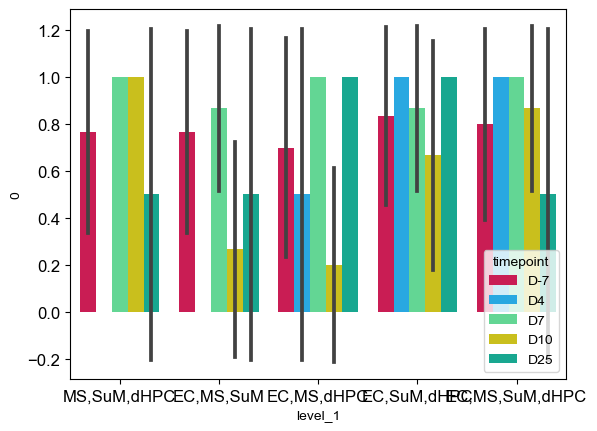

In [79]:
for group_num in [3,5]:
    df_summary_ineractions=analysis_num_interactions_group(df,'red',group_num).fillna(0)
    if df_summary_ineractions.shape[0]==0:continue
    
    df_summary_stat=df_summary_ineractions
    
    ylim=(df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).std(numeric_only=True) + 
         df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).mean(numeric_only=True)).max().max() * 1.3
    for epoch in df_summary_ineractions.epoch.unique():
        plt.close()
        df_epoch=df_summary_ineractions[df_summary_ineractions.epoch==epoch]
        df_plot=df_epoch.drop(['epoch','rat','session','#session'],axis=1)
        df_plot.set_index('timepoint',inplace=True)
        if df_plot.columns.shape[0]==0:
            ax = plot_text(text=f'No redundant interactions has been found in {rename_epoch(epoch)} group {group_num}',title='no data')
            plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_redundent_{epoch}',dpi=300,bbox_inches='tight')
            continue
        df_plot=pd.DataFrame(df_plot.stack())
        df_plot=df_plot.reset_index()
        timepoints = sort_date(all_timepoints,df_plot.timepoint.unique().tolist())
        ax=sns.barplot(df_plot,x='level_1',y=0,hue='timepoint',hue_order=timepoints,palette=palette_time, ci='sd')
#         sns.swarmplot(df_plot,x='level_1',y=0,hue='timepoint',hue_order=timepoints,palette=palette_time, color="0", alpha=.35)
        ##### stats 
        if len(df_summary_stat[df_summary_stat.epoch==epoch].timepoint.unique())>1:
            pairs,pvalues=stat_inteactions(df_summary_stat,epoch)
            if pairs!=[]:
                annotator = Annotator(ax, data=df_plot, x='level_1', y=0,
                                           hue='timepoint',hue_order=timepoints,
                                           pairs=pairs)

                annotator.configure(test=None, line_height=0,
                                   pvalue_thresholds=[[0.0001, "****"], [0.001, "***"], [0.01, "**"], [0.05, "*"]],).set_pvalues(pvalues=pvalues).annotate()
        # add legends for p values
        p1 = ax.bar(0,0, label="*      p <0.05")
        p2 = ax.bar(0,0, label="**     p <0.01")
        p3 = ax.bar(0,0, label="***    p <0.001")
        p4 = ax.bar(0,0, label="****   p <0.0001")

        subtitles = [p1, p2, p3,p4]
        handler_map = subtitle_handler_map(subtitles)

        ##### 
        plt.xticks(rotation=90)
        plt.title(f'Redundant HOIs during {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
        plt.ylim((0,ylim))
        # Bold the x-tick and y-tick labels
        plt.xlabel('HOIs', fontweight='bold', fontsize=15)
        plt.ylabel('Mean number of HOIs', fontweight='bold', fontsize=15)
        ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
#         ax.set_ylim(0,2)

        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,handler_map=handler_map,fontsize=12)
        plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_redundent_{epoch}',dpi=300,bbox_inches='tight')
        plt.show()
        

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,Thal,dHPC,vHPC_D-7 vs. MS,Thal,dHPC,vHPC_D25: Custom statistical test, P_val:1.442e-19
MS,Thal,vHPC_D-7 vs. MS,Thal,vHPC_D25: Custom statistical test, P_val:2.729e-06
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:2.213e-18
Thal,dHPC,vHPC_D-7 vs. Thal,dHPC,vHPC_D25: Custom statistical test, P_val:5.490e-08
MS,dHPC,vHPC_D-7 vs. MS,dHPC,vHPC_D25: Custom statistical test, P_val:8.599e-04


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,Thal,dHPC,vHPC_D-7 vs. MS,Thal,dHPC,vHPC_D25: Custom statistical test, P_val:6.335e-06
Thal,dHPC,vHPC_D-7 vs. Thal,dHPC,vHPC_D25: Custom statistical test, P_val:5.350e-05
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:6.306e-16


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,Thal,dHPC,vHPC_D-7 vs. MS,Thal,dHPC,vHPC_D25: Custom statistical test, P_val:6.687e-05
MS,Thal,vHPC_D-7 vs. MS,Thal,vHPC_D25: Custom statistical test, P_val:4.140e-03
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:3.849e-10
Thal,dHPC,vHPC_D-7 vs. Thal,dHPC,vHPC_D25: Custom statistical test, P_val:3.653e-02


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,Thal,dHPC,vHPC_D-7 vs. MS,Thal,dHPC,vHPC_D25: Custom statistical test, P_val:9.498e-03
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:2.348e-06


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,dHPC,vHPC_D-7 vs. MS,dHPC,vHPC_D25: Custom statistical test, P_val:1.893e-04
Thal,dHPC,vHPC_D-7 vs. Thal,dHPC,vHPC_D25: Custom statistical test, P_val:1.180e-05
MS,Thal,vHPC_D-7 vs. MS,Thal,vHPC_D25: Custom statistical test, P_val:3.516e-05
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:1.482e-04
MS,Thal,dHPC,vHPC_D-7 vs. MS,Thal,dHPC,vHPC_D25: Custom statistical test, P_val:2.796e-02


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,Thal,vHPC_D-7 vs. MS,Thal,vHPC_D25: Custom statistical test, P_val:2.961e-02
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:3.862e-05
Thal,dHPC,vHPC_D-7 vs. Thal,dHPC,vHPC_D25: Custom statistical test, P_val:1.180e-05
MS,dHPC,vHPC_D-7 vs. MS,dHPC,vHPC_D25: Custom statistical test, P_val:3.759e-05


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC,MS,SuM,dHPC_D-7 vs. EC,MS,SuM,dHPC_D25: Custom statistical test, P_val:3.584e-26
MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:3.655e-45
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:3.130e-16
EC,MS,dHPC_D-7 vs. EC,MS,dHPC_D25: Custom statistical test, P_val:3.260e-09
EC,SuM,dHPC_D-7 vs. EC,SuM,dHPC_D25: Custom statistical test, P_val:3.298e-09


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC,MS,SuM,dHPC_D-7 vs. EC,MS,SuM,dHPC_D25: Custom statistical test, P_val:5.924e-08
EC,MS,dHPC_D-7 vs. EC,MS,dHPC_D25: Custom statistical test, P_val:7.304e-05
EC,SuM,dHPC_D-7 vs. EC,SuM,dHPC_D25: Custom statistical test, P_val:1.068e-07
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:7.187e-07
MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:3.134e-27


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC,MS,SuM,dHPC_D-7 vs. EC,MS,SuM,dHPC_D25: Custom statistical test, P_val:4.425e-05
MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:4.476e-10
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:3.509e-03
EC,SuM,dHPC_D-7 vs. EC,SuM,dHPC_D25: Custom statistical test, P_val:8.802e-03


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC,MS,dHPC_D-7 vs. EC,MS,dHPC_D25: Custom statistical test, P_val:3.135e-03
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:4.280e-02
MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:1.345e-05


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC,MS,dHPC_D-7 vs. EC,MS,dHPC_D25: Custom statistical test, P_val:1.354e-04
MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:7.194e-04
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:1.255e-03


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:5.397e-04
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:1.574e-02
EC,MS,dHPC_D-7 vs. EC,MS,dHPC_D25: Custom statistical test, P_val:1.128e-03


/tmp/ipykernel_349392/1184137217.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)


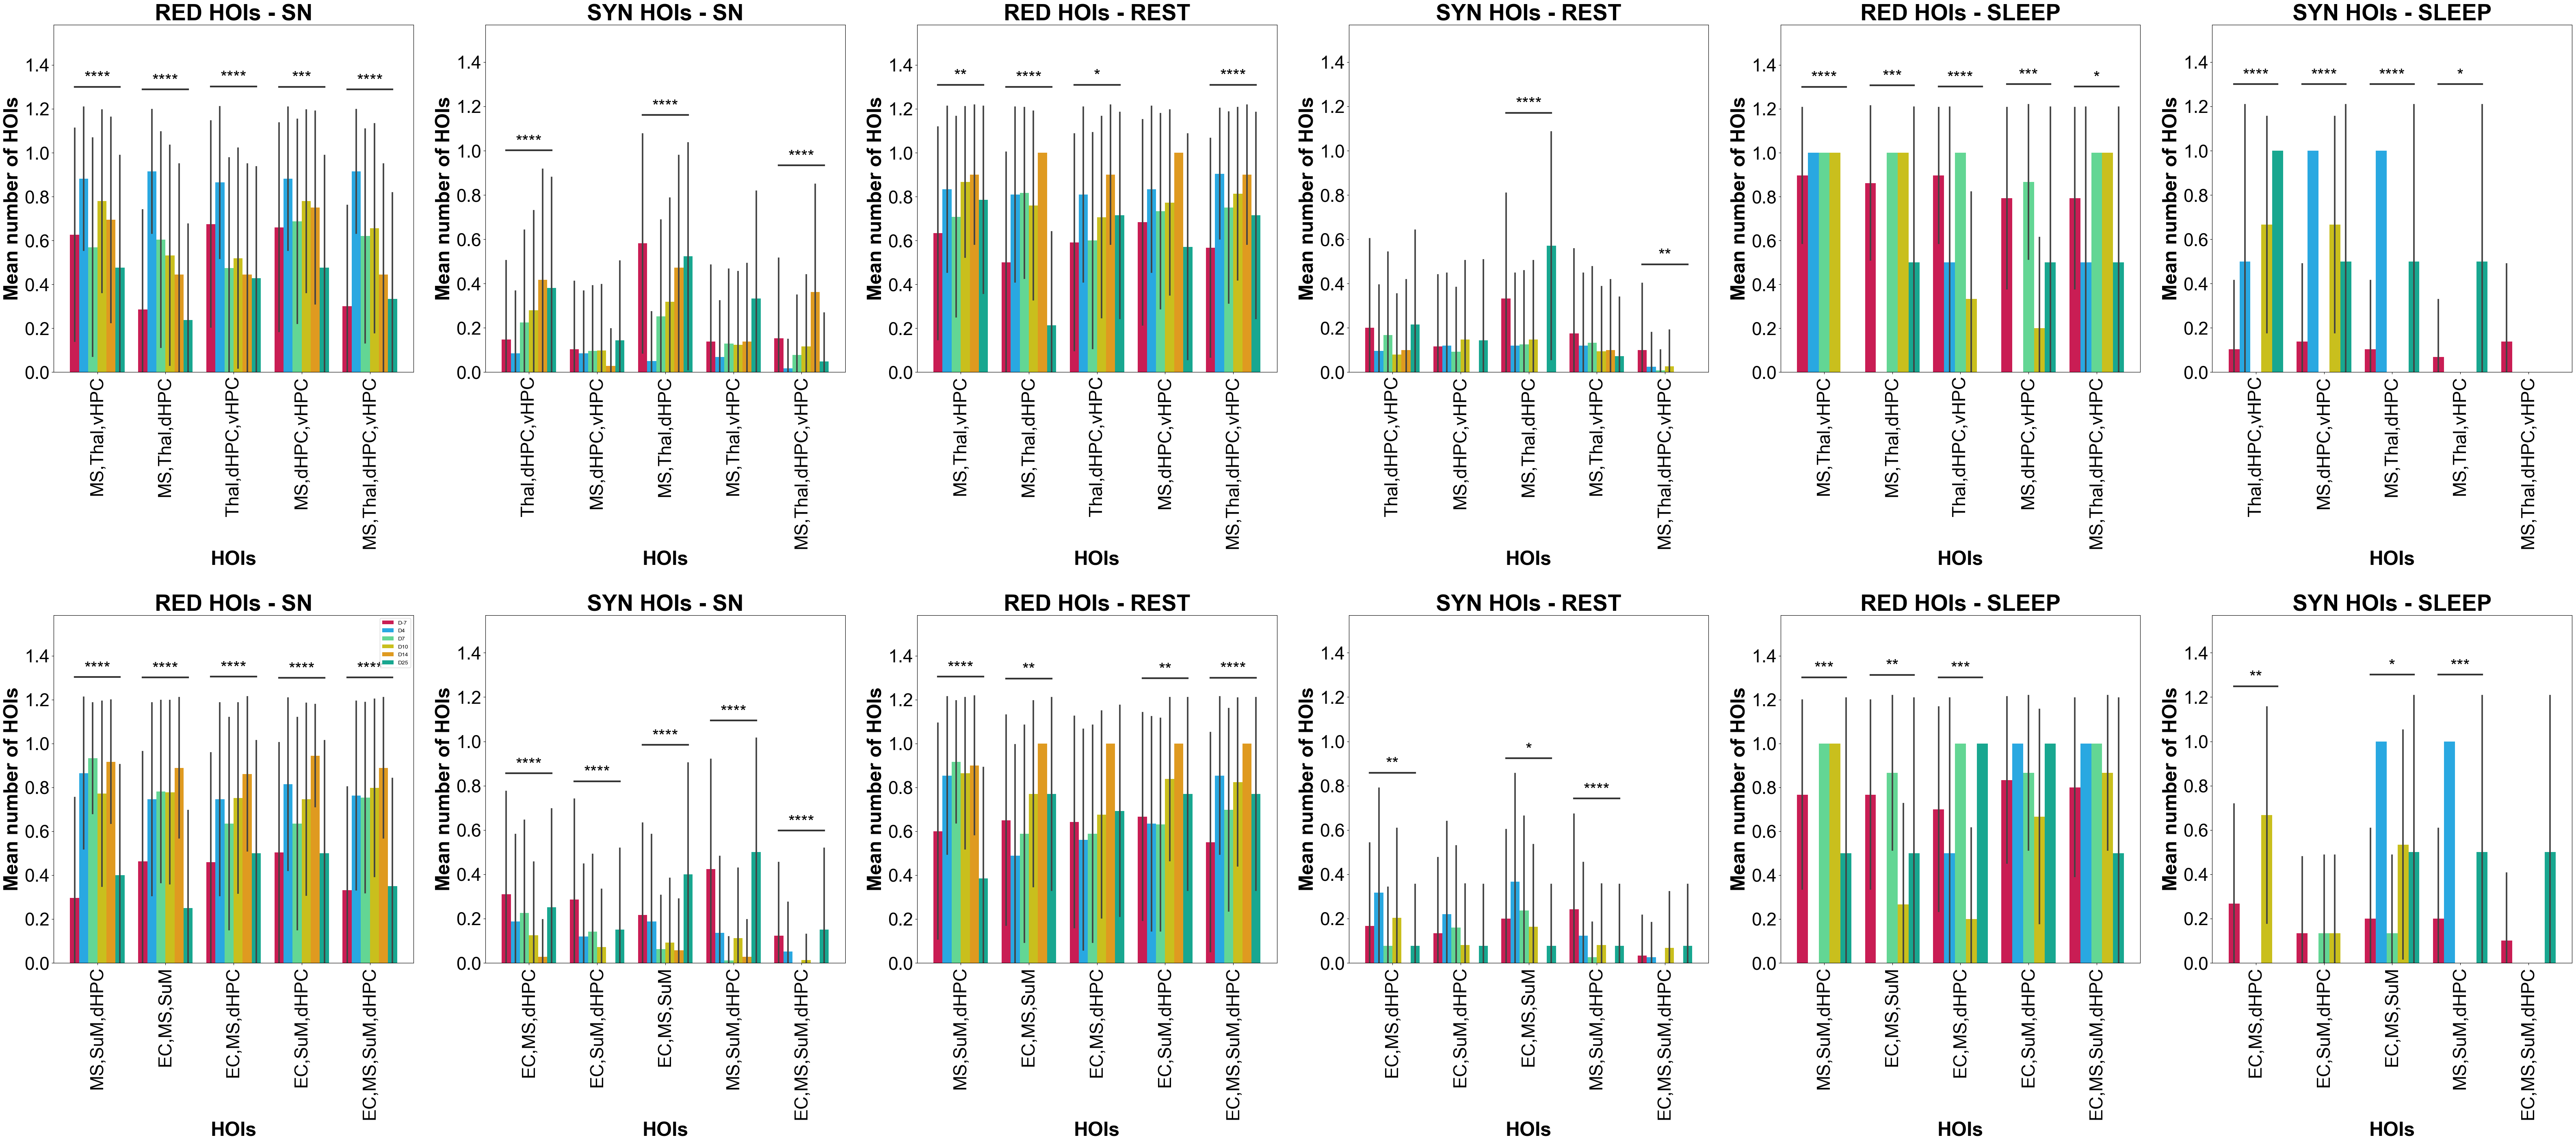

In [188]:


fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(80, 30))
axes_number_i=0
axes_number_j=0

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.7, wspace=0.2)  # Adjust these values as needed

for group_num in [5,3]:
    for epoch in ['SN','VC','SLEEP']:
        for _type in ['red','syn']:
    
            df_summary_ineractions=analysis_num_interactions_group(df,_type,group_num).fillna(0)
            if df_summary_ineractions.shape[0]==0:continue
            
            df_summary_stat=df_summary_ineractions
            
            ylim=(df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).std(numeric_only=True) + 
                 df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).mean(numeric_only=True)).max().max() * 1.3

            # plt.close()
            df_epoch=df_summary_ineractions[df_summary_ineractions.epoch==epoch]
            df_plot=df_epoch.drop(['epoch','rat','session','#session'],axis=1)
            df_plot.set_index('timepoint',inplace=True)
            if df_plot.columns.shape[0]==0:
                ax = plot_text(text=f'No redundant interactions has been found in {rename_epoch(epoch)} group {group_num}',title='no data')
                plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_redundent_{epoch}',dpi=300,bbox_inches='tight')
                continue
            df_plot=pd.DataFrame(df_plot.stack())
            df_plot=df_plot.reset_index()
            timepoints = sort_date(all_timepoints,df_plot.timepoint.unique().tolist())
            sns.barplot(df_plot,x='level_1',y=0,hue='timepoint',hue_order=timepoints,palette=palette_time, ci='sd',ax=axs[axes_number_i,axes_number_j])
            ##### stats 
            if len(df_summary_stat[df_summary_stat.epoch==epoch].timepoint.unique())>1:
                pairs,pvalues=stat_inteactions(df_summary_stat,epoch)
                if pairs!=[]:
                    annotator = Annotator(axs[axes_number_i,axes_number_j], data=df_plot, x='level_1', y=0,
                                               hue='timepoint',hue_order=timepoints,
                                               pairs=pairs)
    
                    annotator.configure(test=None, line_height=0,fontsize=30,line_width=3.0,
                                       pvalue_thresholds=[[0.0001, "****"], [0.001, "***"], [0.01, "**"], [0.05, "*"]],).set_pvalues(pvalues=pvalues).annotate()
            # add legends for p values
            # p1 = axs[axes_number_i,axes_number_j].bar(0,0, label="*      p <0.05")
            # p2 = ax.bar(0,0, label="**     p <0.01")
            # p3 = ax.bar(0,0, label="***    p <0.001")
            # p4 = ax.bar(0,0, label="****   p <0.0001")
    
            # subtitles = [p1, p2, p3,p4]
            # handler_map = subtitle_handler_map(subtitles)
    
            #####
            axs[axes_number_i,axes_number_j].tick_params(axis='x', rotation=90)
            axs[axes_number_i,axes_number_j].set_title(f'{rename_type(_type)} HOIs - {rename_epoch(epoch)}', fontsize=40, fontweight='bold')
            axs[axes_number_i,axes_number_j].set_ylim((0,ylim))
            # # Bold the x-tick and y-tick labels
            axs[axes_number_i,axes_number_j].set_xlabel('HOIs', fontweight='bold', fontsize=35)
            axs[axes_number_i,axes_number_j].set_ylabel('Mean number of HOIs', fontweight='bold', fontsize=35)
            axs[axes_number_i,axes_number_j].set_xticklabels(axs[axes_number_i,axes_number_j].get_xticklabels(), fontsize=32)
            axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)

            # if _type=='red' and epoch=='SN' and group_num==5:
            #     export_legend(axs[axes_number_i,axes_number_j].legen,SAVE_PATH_FIG/f'Figure3_legend.svg')
                
    
            axs[axes_number_i, axes_number_j].legend_.remove()
            
            axes_number_j+=1
    axes_number_j=0    
    axes_number_i+=1
#         ax.set_ylim(0,2)

        # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,handler_map=handler_map,fontsize=12)
export_legend(axs[1,0].legend(),SAVE_PATH_FIG/f'Figure9_legend.svg')
plt.savefig(SAVE_PATH_FIG/f'Figure9_occurance_connections.svg',dpi=600,bbox_inches='tight')
plt.show()
        

In [88]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'mean_number_per_interactions_red.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions=analysis_num_interactions_group(df,'red',group_num).fillna(0)
        if df_summary_ineractions.shape[0]==0:continue
        df_summary_ineractions['timepoint'].replace({'D-7':0,'D4':4, 'D7':7, 'D10':10, 'D12':12, 'D14':14, 'D15':15, 'D16':16, 'D25':25}
                                       ,inplace=True)
        df_summary_ineractions.drop(['session','#session'],axis=1,inplace=True)
        df_total=df_summary_ineractions.groupby(['epoch','timepoint']).mean(numeric_only=True)
        df_total.to_excel(writer, sheet_name=f'group {group_num}')

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:5.397e-04
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:1.574e-02
EC,MS,dHPC_D-7 vs. EC,MS,dHPC_D25: Custom statistical test, P_val:1.128e-03


/tmp/ipykernel_14824/3366376907.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


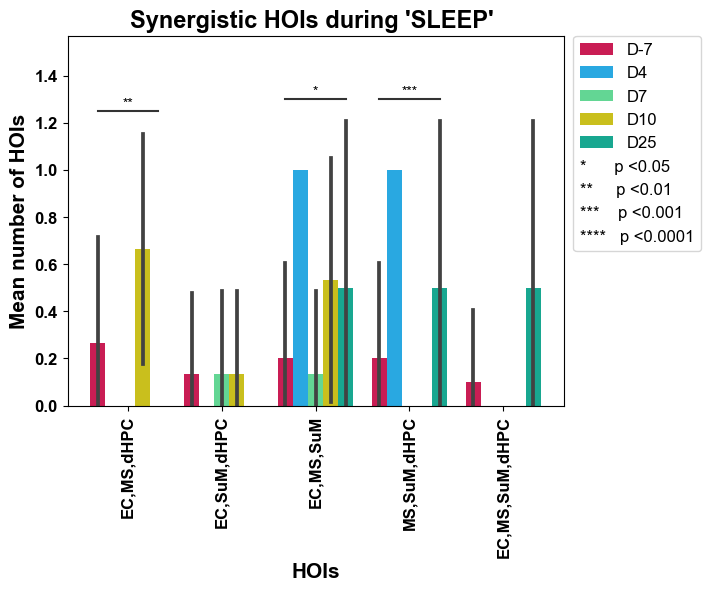

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC,MS,SuM,dHPC_D-7 vs. EC,MS,SuM,dHPC_D25: Custom statistical test, P_val:5.924e-08
EC,MS,dHPC_D-7 vs. EC,MS,dHPC_D25: Custom statistical test, P_val:7.304e-05
EC,SuM,dHPC_D-7 vs. EC,SuM,dHPC_D25: Custom statistical test, P_val:1.068e-07
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:7.187e-07
MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:3.134e-27


/tmp/ipykernel_14824/3366376907.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


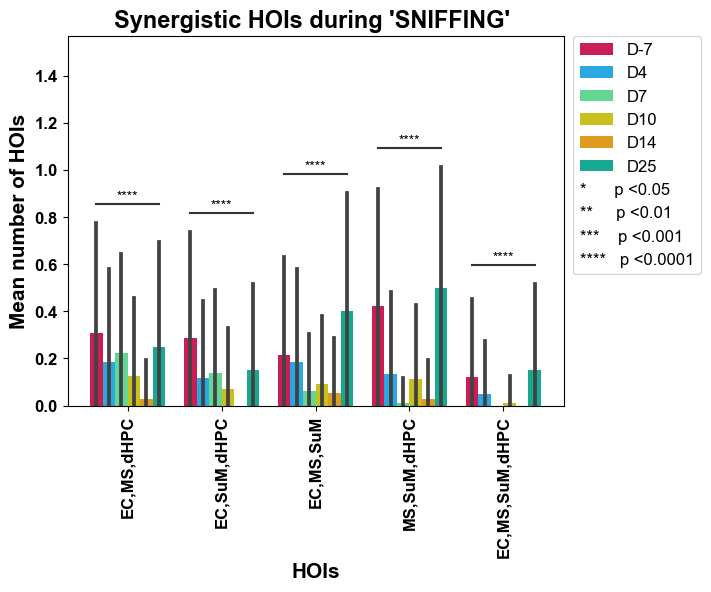

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC,MS,dHPC_D-7 vs. EC,MS,dHPC_D25: Custom statistical test, P_val:3.135e-03
EC,MS,SuM_D-7 vs. EC,MS,SuM_D25: Custom statistical test, P_val:4.280e-02
MS,SuM,dHPC_D-7 vs. MS,SuM,dHPC_D25: Custom statistical test, P_val:1.345e-05


/tmp/ipykernel_14824/3366376907.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


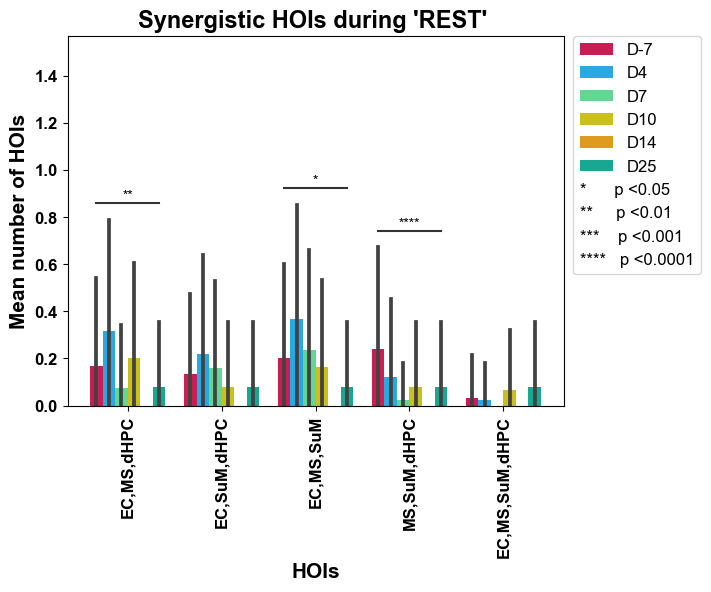

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,Thal,vHPC_D-7 vs. MS,Thal,vHPC_D25: Custom statistical test, P_val:2.961e-02
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:3.862e-05
Thal,dHPC,vHPC_D-7 vs. Thal,dHPC,vHPC_D25: Custom statistical test, P_val:1.180e-05
MS,dHPC,vHPC_D-7 vs. MS,dHPC,vHPC_D25: Custom statistical test, P_val:3.759e-05


/tmp/ipykernel_14824/3366376907.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


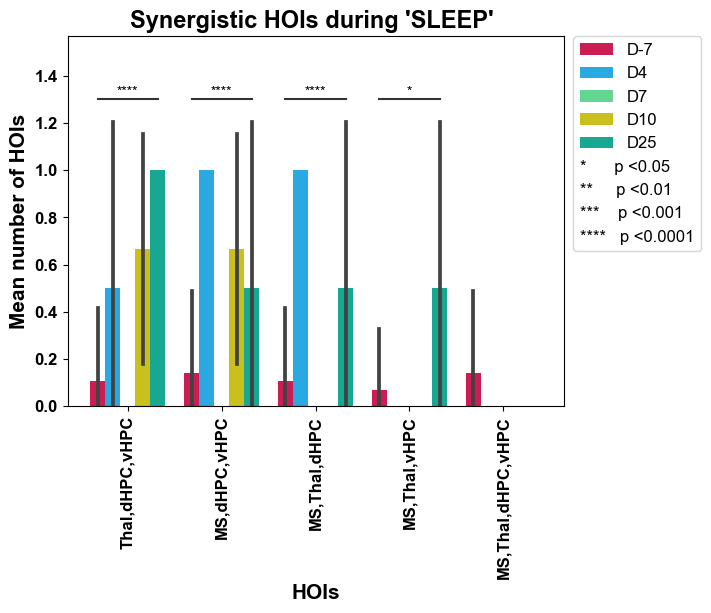

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,Thal,dHPC,vHPC_D-7 vs. MS,Thal,dHPC,vHPC_D25: Custom statistical test, P_val:6.335e-06
Thal,dHPC,vHPC_D-7 vs. Thal,dHPC,vHPC_D25: Custom statistical test, P_val:5.350e-05
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:6.306e-16


/tmp/ipykernel_14824/3366376907.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


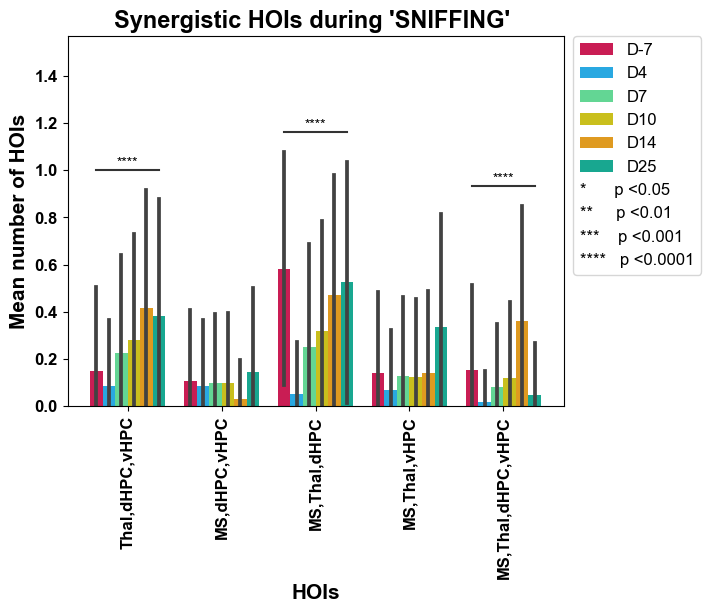

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS,Thal,dHPC,vHPC_D-7 vs. MS,Thal,dHPC,vHPC_D25: Custom statistical test, P_val:9.498e-03
MS,Thal,dHPC_D-7 vs. MS,Thal,dHPC_D25: Custom statistical test, P_val:2.348e-06


/tmp/ipykernel_14824/3366376907.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


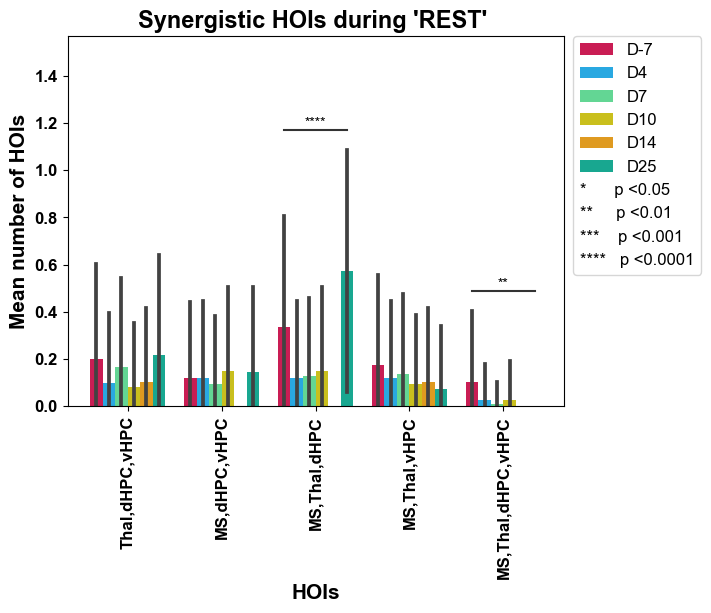

In [90]:
for group_num in [3,5]:
    df_summary_ineractions=analysis_num_interactions_group(df,'syn',group_num).fillna(0)
    if df_summary_ineractions.shape[0]==0:continue
    
    df_summary_stat=df_summary_ineractions
    
#     df_summary_ineractions=calculate_sum_interactions_per_time(df_summary_ineractions)
    
    
#     for col in df_summary_ineractions.iloc[:,3:].columns:
#         if col=='session':continue
#         df_summary_ineractions[col]=df_summary_ineractions[col]/df_summary_ineractions['session']
    ylim=(df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).std(numeric_only=True) + 
         df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).mean(numeric_only=True)).max().max() * 1.3
    for epoch in df_summary_ineractions.epoch.unique():
        plt.close()
        df_epoch=df_summary_ineractions[df_summary_ineractions.epoch==epoch]
        df_plot=df_epoch.drop(['epoch','rat','session','#session'],axis=1)
        df_plot.set_index('timepoint',inplace=True)
        if df_plot.columns.shape[0]==0:
            plot_text(f'No redundant interactions has been found in {rename_epoch(epoch)} group {group_num}','')
            plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_synergistic_{epoch}',dpi=300,bbox_inches='tight')
            continue
        df_plot=pd.DataFrame(df_plot.stack())
        df_plot=df_plot.reset_index()
        timepoints = sort_date(all_timepoints,df_plot.timepoint.unique().tolist())
        ax=sns.barplot(df_plot,x='level_1',y=0,hue='timepoint',hue_order=timepoints,palette=palette_time, ci='sd')
        ##### stats 
        if len(df_summary_stat[df_summary_stat.epoch==epoch].timepoint.unique())>1:
            pairs,pvalues=stat_inteactions(df_summary_stat,epoch)
            if pairs!=[]:
                annotator = Annotator(ax, data=df_plot, x='level_1', y=0,
                                           hue='timepoint',hue_order=timepoints,
                                           pairs=pairs)

                annotator.configure(test=None, line_height=0,
                                   pvalue_thresholds=[[0.0001, "****"], [0.001, "***"], [0.01, "**"], [0.05, "*"]],).set_pvalues(pvalues=pvalues).annotate()
        # add legends for p values
        p1 = ax.bar(0,0, label="*      p <0.05")
        p2 = ax.bar(0,0, label="**     p <0.01")
        p3 = ax.bar(0,0, label="***    p <0.001")
        p4 = ax.bar(0,0, label="****   p <0.0001")

        subtitles = [p1, p2, p3,p4]
        handler_map = subtitle_handler_map(subtitles)
        ##### 
        plt.xticks(rotation=90)
        plt.title(f'Synergistic HOIs during {rename_epoch(epoch)} ', fontsize=17, fontweight='bold')
        plt.ylim((0,ylim))
        # Bold the x-tick and y-tick labelssession
        plt.xlabel('HOIs', fontweight='bold', fontsize=15)
        plt.ylabel('Mean number of HOIs', fontweight='bold', fontsize=15)
        ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
#         ax.set_ylim(0,2)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,handler_map=handler_map,fontsize=12)
        plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_synergistic_{epoch}',dpi=300,bbox_inches='tight')
        plt.show()




In [91]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'mean_number_per_interactions_syn.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions=analysis_num_interactions_group(df,'syn',group_num).fillna(0)
        if df_summary_ineractions.shape[0]==0:continue

        df_summary_ineractions['timepoint'].replace({'D-7':0,'D4':4, 'D7':7, 'D10':10, 'D12':12, 'D14':14, 'D15':15, 'D16':16, 'D25':25}
                                       ,inplace=True)
        df_summary_ineractions.drop(['session','#session'],axis=1,inplace=True)
        df_total=df_summary_ineractions.groupby(['epoch','timepoint']).mean(numeric_only=True)
        df_total.to_excel(writer, sheet_name=f'group {group_num}')

## Region

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC_D-7 vs. EC_D25: Custom statistical test, P_val:2.825e-03
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:5.845e-03
MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.755e-03
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:7.288e-03


/tmp/ipykernel_14824/3685678831.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


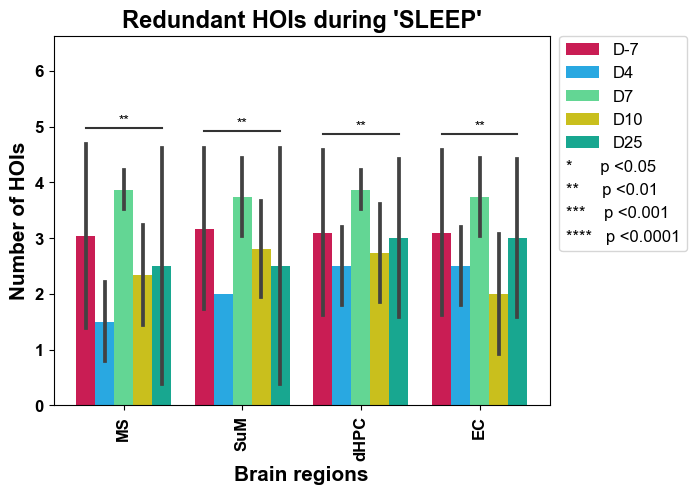

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:5.119e-29
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:6.104e-30
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:7.419e-27
EC_D-7 vs. EC_D25: Custom statistical test, P_val:6.237e-21


/tmp/ipykernel_14824/3685678831.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


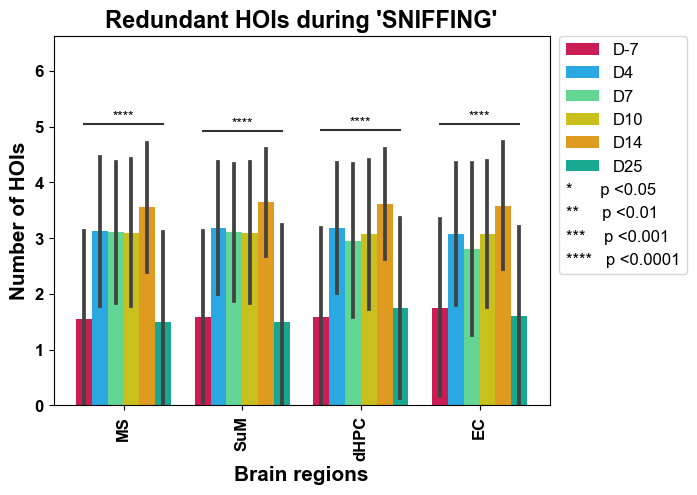

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.700e-03
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:8.293e-05
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:5.208e-04
EC_D-7 vs. EC_D25: Custom statistical test, P_val:6.942e-04


/tmp/ipykernel_14824/3685678831.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


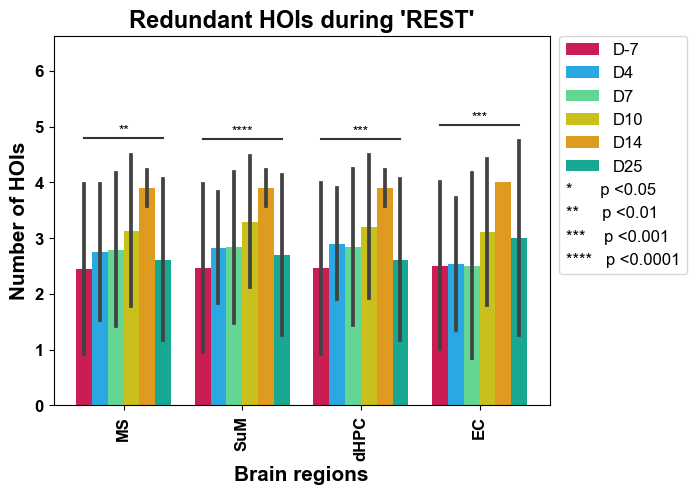

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:1.261e-04
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:1.485e-04
MS_D-7 vs. MS_D25: Custom statistical test, P_val:7.508e-04
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:1.928e-04


/tmp/ipykernel_14824/3685678831.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


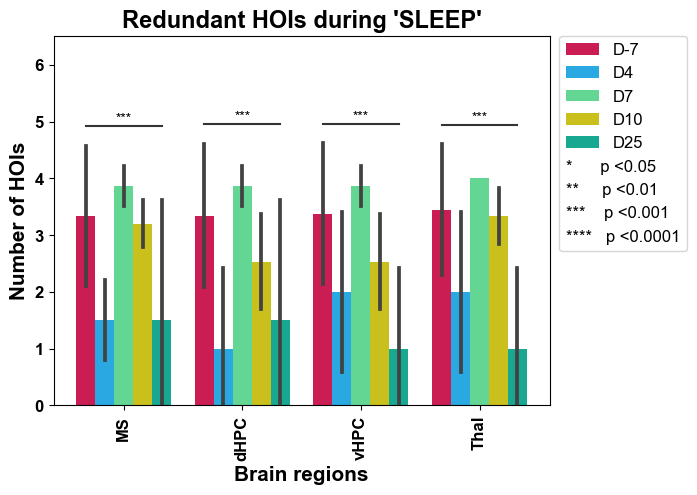

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.695e-17
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:2.959e-13
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:3.749e-11
Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:5.754e-14


/tmp/ipykernel_14824/3685678831.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


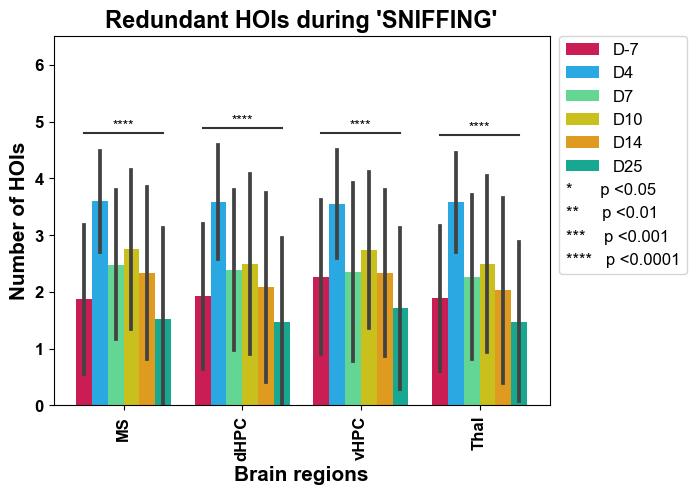

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:8.493e-07
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:1.494e-05
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:8.936e-04
Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:3.614e-06


/tmp/ipykernel_14824/3685678831.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


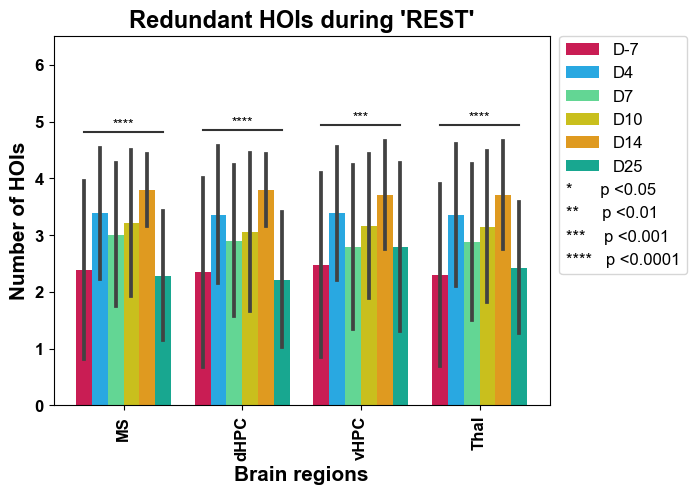

In [95]:
for group_num in [3,5]:
    df_summary_ineractions=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
    if df_summary_ineractions.shape[0]==0:continue
    
    df_summary_stat=df_summary_ineractions
    
#     df_summary_ineractions=calculate_sum_interactions_per_time(df_summary_ineractions)
    
#     for col in df_summary_ineractions.iloc[:,3:].columns:
#         if col=='session':continue
#         df_summary_ineractions[col]=df_summary_ineractions[col]/df_summary_ineractions['session']
    ylim=(df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).std(numeric_only=True) + 
         df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).mean(numeric_only=True)).max().max() * 1.4
    for epoch in df_summary_ineractions.epoch.unique():
        plt.close()
        df_epoch=df_summary_ineractions[df_summary_ineractions.epoch==epoch]
        df_plot=df_epoch.drop(['epoch','rat','session','#session'],axis=1)
        if df_plot.columns.shape[0]==0:
            plot_text(f'No synergistic interactions has been found in {rename_epoch(epoch)} group {group_num}')
            continue
        df_plot.set_index('timepoint',inplace=True)
        df_plot=pd.DataFrame(df_plot.stack())
        df_plot=df_plot.reset_index()
        timepoints = sort_date(all_timepoints,df_plot.timepoint.unique().tolist())
        ax=sns.barplot(df_plot,x='level_1',y=0,hue='timepoint',hue_order=timepoints,palette=palette_time, ci='sd')
        ##### stats 
        if len(df_summary_stat[df_summary_stat.epoch==epoch].timepoint.unique())>1:
            pairs,pvalues=stat_inteactions(df_summary_stat,epoch)
            if pairs!=[]:
                annotator = Annotator(ax, data=df_plot, x='level_1', y=0,
                                           hue='timepoint',hue_order=timepoints,
                                           pairs=pairs)

                annotator.configure(test=None, line_height=0,
                                   pvalue_thresholds=[[0.0001, "****"], [0.001, "***"], [0.01, "**"], [0.05, "*"]],).set_pvalues(pvalues=pvalues).annotate()
        # add legends for p values
        p1 = ax.bar(0,0, label="*      p <0.05")
        p2 = ax.bar(0,0, label="**     p <0.01")
        p3 = ax.bar(0,0, label="***    p <0.001")
        p4 = ax.bar(0,0, label="****   p <0.0001")

        subtitles = [p1, p2, p3,p4]
        handler_map = subtitle_handler_map(subtitles)
        ##### 
        plt.xticks(rotation=90)
        plt.title(f'Redundant HOIs during {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
        plt.ylim((0,ylim))
        # Bold the x-tick and y-tick labels
        plt.xlabel('Brain regions', fontweight='bold', fontsize=15)
        plt.ylabel('Number of HOIs', fontweight='bold', fontsize=15)
        ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,handler_map=handler_map, fontsize=12)

        plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_redundent_{epoch}_region',dpi=300,bbox_inches='tight')
        plt.show()


In [96]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'mean_number_per_region_red.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
        if df_summary_ineractions.shape[0]==0:continue

        df_summary_ineractions['timepoint'].replace({'D-7':0,'D4':4, 'D7':7, 'D10':10, 'D12':12, 'D14':14, 'D15':15, 'D16':16, 'D25':25}
                                       ,inplace=True)
        df_summary_ineractions.drop(['session','#session'],axis=1,inplace=True)
        df_total=df_summary_ineractions.groupby(['epoch','timepoint']).mean(numeric_only=True)
        df_total.to_excel(writer, sheet_name=f'group {group_num}')

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC_D-7 vs. EC_D25: Custom statistical test, P_val:3.800e-02
MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.472e-02
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:2.984e-02


/tmp/ipykernel_87420/2284687638.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


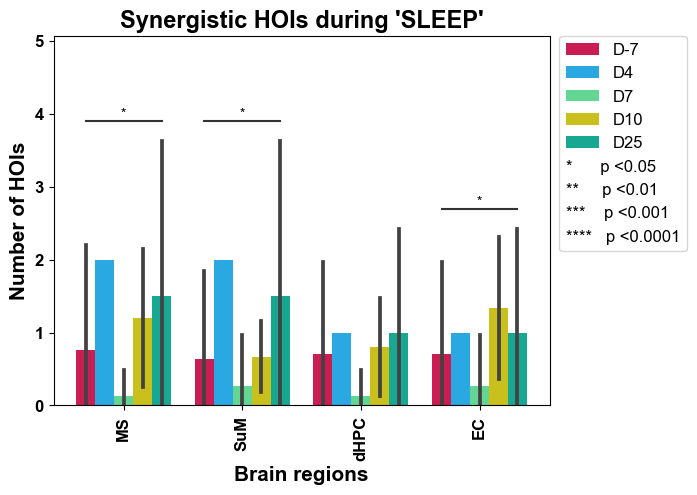

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:9.805e-22
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:8.192e-25
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:5.079e-21
EC_D-7 vs. EC_D25: Custom statistical test, P_val:2.091e-10


/tmp/ipykernel_87420/2284687638.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


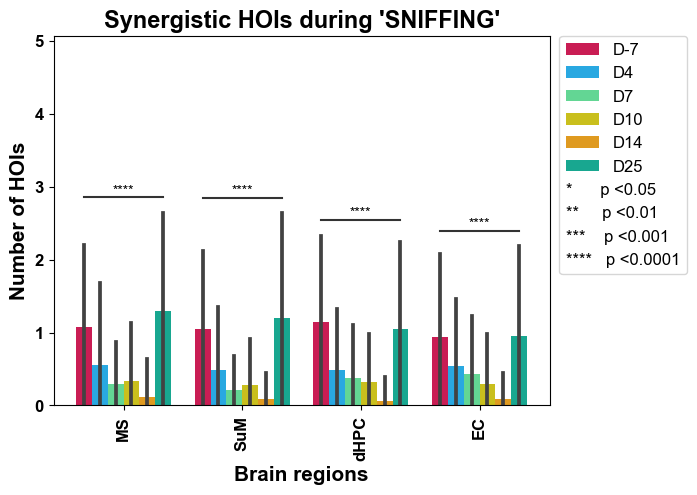

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:7.024e-03
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:6.922e-04
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:2.054e-05
EC_D-7 vs. EC_D25: Custom statistical test, P_val:3.025e-03


/tmp/ipykernel_87420/2284687638.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


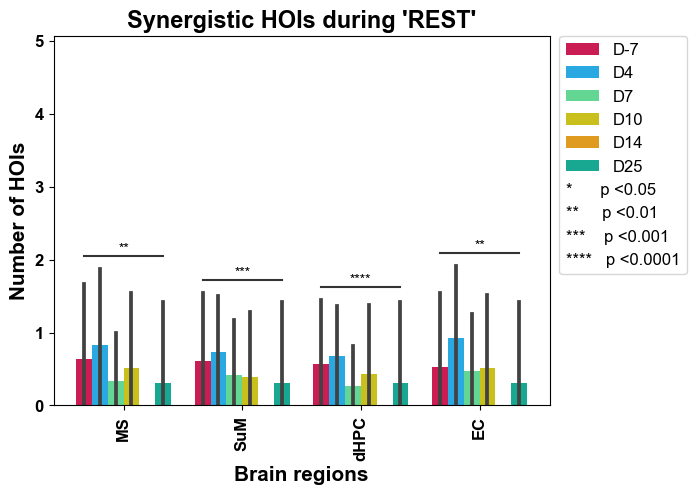

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:6.893e-05
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:1.207e-04
MS_D-7 vs. MS_D25: Custom statistical test, P_val:2.051e-04
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:6.488e-05


/tmp/ipykernel_87420/2284687638.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


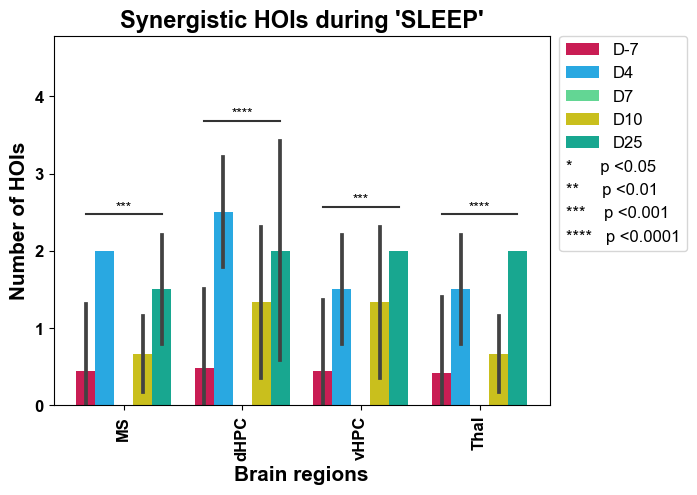

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:6.254e-11
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:3.239e-10
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:3.911e-04
Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:8.894e-10


/tmp/ipykernel_87420/2284687638.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


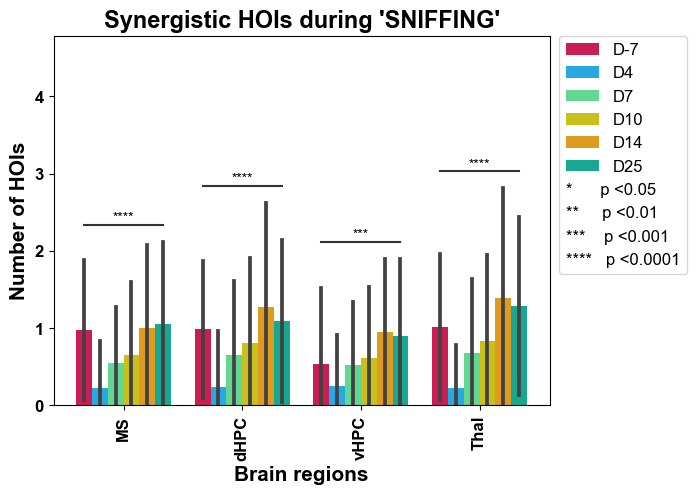

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.548e-03
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:8.268e-04
Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:3.210e-04


/tmp/ipykernel_87420/2284687638.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


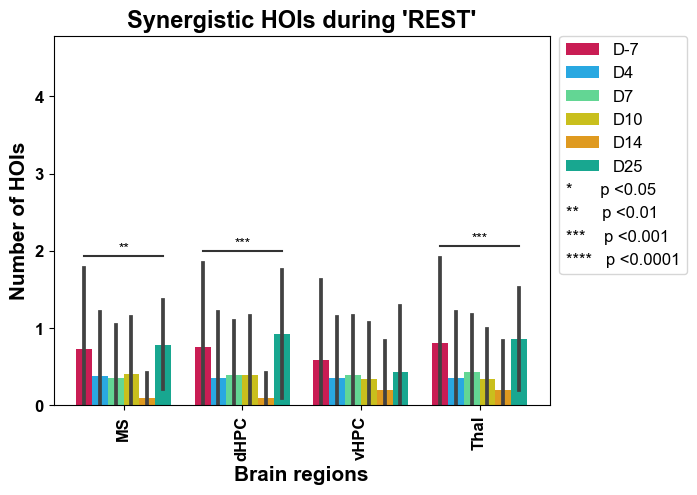

In [93]:
for group_num in [3,5]:
    df_summary_ineractions=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
    if df_summary_ineractions.shape[0]==0:continue
    
    df_summary_stat=df_summary_ineractions
    
#     df_summary_ineractions=calculate_sum_interactions_per_time(df_summary_ineractions)
    
#     for col in df_summary_ineractions.iloc[:,3:].columns:
#         if col=='session':continue
#         df_summary_ineractions[col]=df_summary_ineractions[col]/df_summary_ineractions['session']
    ylim=(df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).std(numeric_only=True) + 
         df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).mean(numeric_only=True)).max().max() * 1.4
    for epoch in df_summary_ineractions.epoch.unique():
        plt.close()
        df_epoch=df_summary_ineractions[df_summary_ineractions.epoch==epoch]
        df_plot=df_epoch.drop(['epoch','rat','session','#session'],axis=1)
        if df_plot.columns.shape[0]==0:
            plot_text(f'No synergistic interactions has been found in {rename_epoch(epoch)} group {group_num}')
            continue
        df_plot.set_index('timepoint',inplace=True)
        df_plot=pd.DataFrame(df_plot.stack())
        df_plot=df_plot.reset_index()
        timepoints = sort_date(all_timepoints,df_plot.timepoint.unique().tolist())
        ax=sns.barplot(df_plot,x='level_1',y=0,hue='timepoint',hue_order=timepoints,palette=palette_time, ci='sd')
        ##### stats 
        if len(df_summary_stat[df_summary_stat.epoch==epoch].timepoint.unique())>1:
            pairs,pvalues=stat_inteactions(df_summary_stat,epoch)
            if pairs!=[]:
                annotator = Annotator(ax, data=df_plot, x='level_1', y=0,
                                           hue='timepoint',hue_order=timepoints,
                                           pairs=pairs)

                annotator.configure(test=None, line_height=0,
                                   pvalue_thresholds=[[0.0001, "****"], [0.001, "***"], [0.01, "**"], [0.05, "*"]],).set_pvalues(pvalues=pvalues).annotate()
        # add legends for p values
        p1 = ax.bar(0,0, label="*      p <0.05")
        p2 = ax.bar(0,0, label="**     p <0.01")
        p3 = ax.bar(0,0, label="***    p <0.001")
        p4 = ax.bar(0,0, label="****   p <0.0001")

        subtitles = [p1, p2, p3,p4]
        handler_map = subtitle_handler_map(subtitles)
        ##### 
        plt.xticks(rotation=90)
        plt.title(f'Synergistic HOIs during {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
        plt.ylim((0,ylim))
        # Bold the x-tick and y-tick labels
        plt.xlabel('Brain regions', fontweight='bold', fontsize=15)
        plt.ylabel('Number of HOIs', fontweight='bold', fontsize=15)
        ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,handler_map=handler_map, fontsize=12)
        plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_synergistic_{epoch}_region',dpi=300,bbox_inches='tight')
        plt.show()

In [94]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'mean_number_per_region_syn.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
        if df_summary_ineractions.shape[0]==0:continue

        df_summary_ineractions['timepoint'].replace({'D-7':0,'D4':4, 'D7':7, 'D10':10, 'D12':12, 'D14':14, 'D15':15, 'D16':16, 'D25':25}
                                       ,inplace=True)
        df_summary_ineractions.drop(['session','#session'],axis=1,inplace=True)
        df_total=df_summary_ineractions.groupby(['epoch','timepoint']).mean(numeric_only=True)
        df_total.to_excel(writer, sheet_name=f'group {group_num}')

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.695e-17
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:2.959e-13
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:3.749e-11
Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:5.754e-14


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:6.254e-11
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:3.239e-10
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:3.911e-04
Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:8.894e-10


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:8.493e-07
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:1.494e-05
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:8.936e-04
Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:3.614e-06


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.548e-03
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:8.268e-04
Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:3.210e-04


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:1.261e-04
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:1.485e-04
MS_D-7 vs. MS_D25: Custom statistical test, P_val:7.508e-04
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:1.928e-04


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Thal_D-7 vs. Thal_D25: Custom statistical test, P_val:6.893e-05
vHPC_D-7 vs. vHPC_D25: Custom statistical test, P_val:1.207e-04
MS_D-7 vs. MS_D25: Custom statistical test, P_val:2.051e-04
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:6.488e-05


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:5.119e-29
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:6.104e-30
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:7.419e-27
EC_D-7 vs. EC_D25: Custom statistical test, P_val:6.237e-21


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:9.805e-22
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:8.192e-25
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:5.079e-21
EC_D-7 vs. EC_D25: Custom statistical test, P_val:2.091e-10


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.700e-03
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:8.293e-05
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:5.208e-04
EC_D-7 vs. EC_D25: Custom statistical test, P_val:6.942e-04


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MS_D-7 vs. MS_D25: Custom statistical test, P_val:7.024e-03
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:6.922e-04
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:2.054e-05
EC_D-7 vs. EC_D25: Custom statistical test, P_val:3.025e-03


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC_D-7 vs. EC_D25: Custom statistical test, P_val:2.825e-03
dHPC_D-7 vs. dHPC_D25: Custom statistical test, P_val:5.845e-03
MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.755e-03
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:7.288e-03


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EC_D-7 vs. EC_D25: Custom statistical test, P_val:3.800e-02
MS_D-7 vs. MS_D25: Custom statistical test, P_val:1.472e-02
SuM_D-7 vs. SuM_D25: Custom statistical test, P_val:2.984e-02


/tmp/ipykernel_349392/444983272.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)


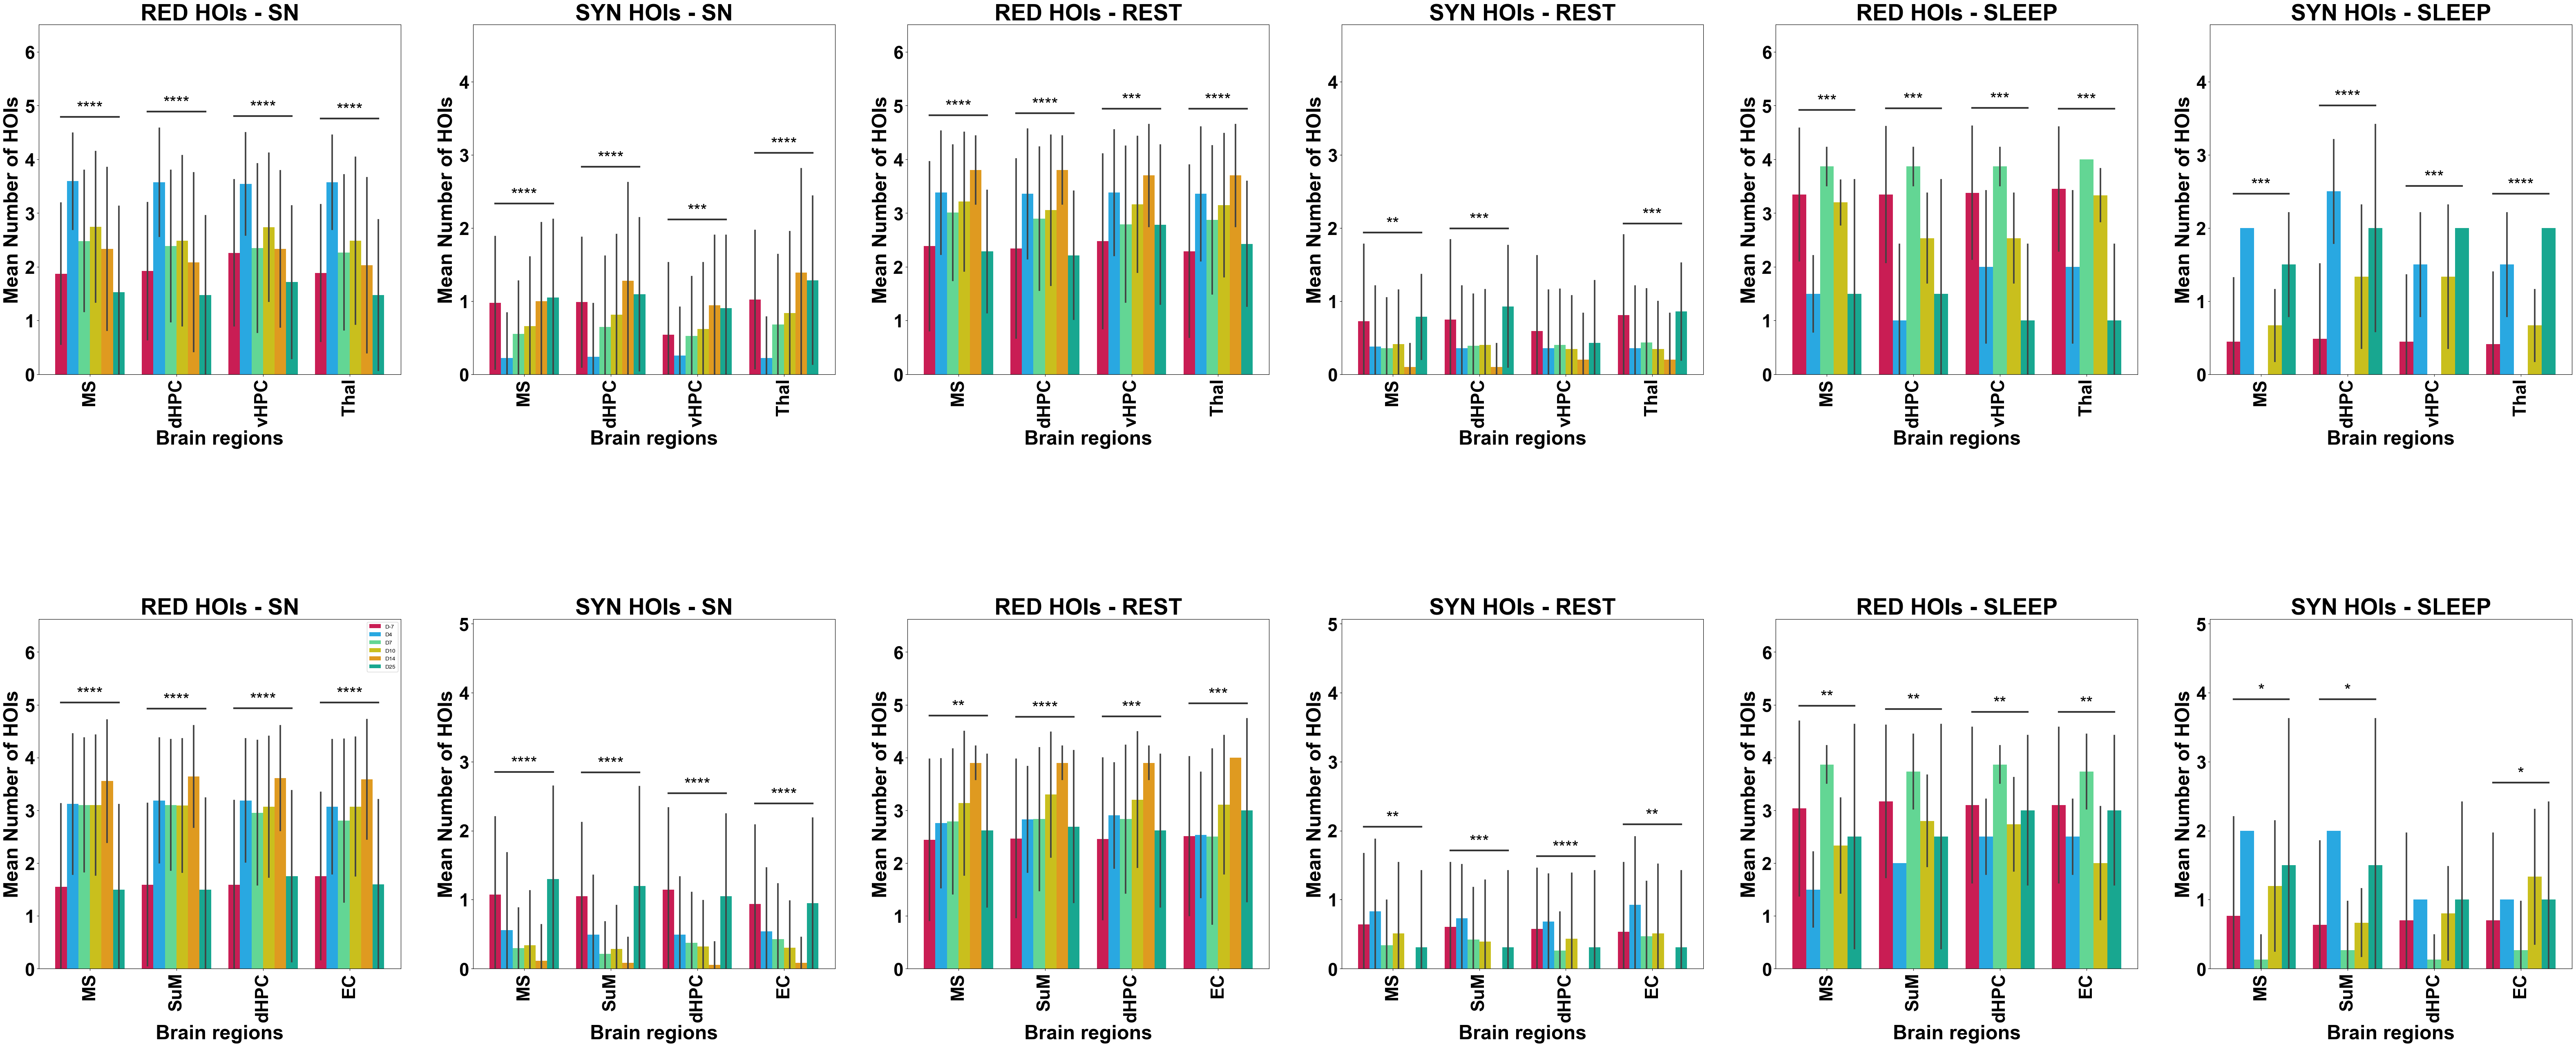

In [189]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(80, 30))
axes_number_i=0
axes_number_j=0

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.7, wspace=0.2)  # Adjust these values as needed

for group_num in [5,3]:
    for epoch in ['SN','VC','SLEEP']:
        for _type in ['red','syn']:
            df_summary_ineractions=analysis_num_interactions_group(df,_type,group_num,True).fillna(0)
            if df_summary_ineractions.shape[0]==0:continue
            
            df_summary_stat=df_summary_ineractions
            
        #     df_summary_ineractions=calculate_sum_interactions_per_time(df_summary_ineractions)
            
        #     for col in df_summary_ineractions.iloc[:,3:].columns:
        #         if col=='session':continue
        #         df_summary_ineractions[col]=df_summary_ineractions[col]/df_summary_ineractions['session']
            ylim=(df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).std(numeric_only=True) + 
             df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).mean(numeric_only=True)).max().max() * 1.4

            # plt.close()
            df_epoch=df_summary_ineractions[df_summary_ineractions.epoch==epoch]
            df_plot=df_epoch.drop(['epoch','rat','session','#session'],axis=1)
            if df_plot.columns.shape[0]==0:
                plot_text(f'No synergistic interactions has been found in {rename_epoch(epoch)} group {group_num}')
                continue
            df_plot.set_index('timepoint',inplace=True)
            df_plot=pd.DataFrame(df_plot.stack())
            df_plot=df_plot.reset_index()
            timepoints = sort_date(all_timepoints,df_plot.timepoint.unique().tolist())
            sns.barplot(df_plot,x='level_1',y=0,hue='timepoint',hue_order=timepoints,palette=palette_time, ci='sd',ax=axs[axes_number_i,axes_number_j])
            ##### stats 
            if len(df_summary_stat[df_summary_stat.epoch==epoch].timepoint.unique())>1:
                pairs,pvalues=stat_inteactions(df_summary_stat,epoch)
                if pairs!=[]:
                    annotator = Annotator(axs[axes_number_i,axes_number_j], data=df_plot, x='level_1', y=0,
                                               hue='timepoint',hue_order=timepoints,
                                               pairs=pairs)
    
                    annotator.configure(test=None, line_height=0,fontsize=30,line_width=3.0,
                                       pvalue_thresholds=[[0.0001, "****"], [0.001, "***"], [0.01, "**"], [0.05, "*"]],).set_pvalues(pvalues=pvalues).annotate()
            # # add legends for p values
            # p1 = ax.bar(0,0, label="*      p <0.05")
            # p2 = ax.bar(0,0, label="**     p <0.01")
            # p3 = ax.bar(0,0, label="***    p <0.001")
            # p4 = ax.bar(0,0, label="****   p <0.0001")
    
            # subtitles = [p1, p2, p3,p4]
            # handler_map = subtitle_handler_map(subtitles)
            ##### 
            axs[axes_number_i,axes_number_j].tick_params(axis='x', rotation=90)
            axs[axes_number_i,axes_number_j].set_title(f'{rename_type(_type)} HOIs - {rename_epoch(epoch)}', fontsize=40, fontweight='bold')
            axs[axes_number_i,axes_number_j].set_ylim((0,ylim))
            # Bold the x-tick and y-tick labels
            axs[axes_number_i,axes_number_j].set_xlabel('Brain regions', fontweight='bold', fontsize=35)
            axs[axes_number_i,axes_number_j].set_ylabel('Mean Number of HOIs', fontweight='bold', fontsize=35)
            axs[axes_number_i,axes_number_j].set_xticklabels(axs[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=32)
            axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=32)
            # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,handler_map=handler_map, fontsize=12)
            axs[axes_number_i, axes_number_j].legend_.remove()
            axes_number_j+=1
    axes_number_j=0    
    axes_number_i+=1
export_legend(axs[1,0].legend(),SAVE_PATH_FIG/f'Figure8_legend.svg')
plt.savefig(SAVE_PATH_FIG/f'Figure8_occurance_connections_region.svg',dpi=600,bbox_inches='tight')
# plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_synergistic_{epoch}_region',dpi=300,bbox_inches='tight')
# plt.show()

# Syn and Red

In [92]:
def get_interactions_per_session(col_interactions):
    interactions = col_interactions.fillna('nan').values
    df_interactions=pd.DataFrame(columns=['session','num_interactions'])
    for session in range(interactions.shape[0]):
        if np.all(np.char.equal(interactions[session], 'nan')):
            df_interactions.loc[len(df_interactions.index)] = [session, 0]
        else:
            df_interactions.loc[len(df_interactions.index)] = [session, interactions[session].shape[0]]
    return df_interactions

In [93]:
def stat_interactions(df_interactions):
    df_stat=pd.DataFrame(columns=['epoch','timepoint','p_val'])
    for epoch in df_interactions.epoch.unique():
        df_epoch=df_interactions[df_interactions.epoch==epoch]

        for time1,time2 in itertools.combinations(sorted(df_epoch.timepoint.unique().tolist()),2):
            val_time1=df_epoch[df_epoch.timepoint==time1]['num_interactions'].values
            val_time2=df_epoch[df_epoch.timepoint==time2]['num_interactions'].values
            p_val=stats.f_oneway(val_time1,val_time2)[1]
            p_val = np.where(p_val <0.05, 1, 0)
            df_stat.loc[len(df_stat.index)]=[epoch, f'time{time1}_to_time{time2}',p_val]
    return df_stat

In [94]:
def stat_interactions_overall(df_stat):
    pairs=[]
    p_vals=[]
    timepoints=sort_date(order=all_timepoints,timepoints=df_stat.timepoint.unique().tolist())
    for t_perv, timepoint in itertools.combinations(timepoints,2):
        # prev
        n_prev=df_stat[(df_stat.timepoint==t_perv)]['num_interactions'].values

        # after
        n_after=df_stat[(df_stat.timepoint==timepoint)]['num_interactions'].values
  
        if np.concatenate([n_prev,n_after]).shape[0]<=3:
            continue
        if pg.normality(np.concatenate([n_prev,n_after]))['normal'].values[0]:
            _,p_value=scipy.stats.f_oneway(n_prev,n_after)
        else:
            _,p_value=scipy.stats.kruskal(n_prev,n_after)
        print(t_perv,timepoint,p_value)
        if p_value < 0.05:
            p_vals.append(p_value)
            pairs.append(((t_perv,timepoint)))
    return pairs,p_vals

In [95]:
def rm_test(df_test):
    pval = stats.kruskal(*list(df_test.groupby('timepoint').agg(list).num_interactions.values))[1]
    return pval

### Overtime

In [94]:
# red
df_inetractions_all=pd.DataFrame()
for group in [3,5]:
    df_group=df[df.group==group]
    df_inetractions_group=pd.DataFrame()
    for rat in df_group.rat.unique().tolist():
        df_rat=df_group[df_group.rat==rat]
        df_inetractions_rat=pd.DataFrame()
        for epoch in df_rat.epoch.unique().tolist():
            df_epoch=df_rat[df_rat.epoch==epoch]
            df_inetractions_epoch=pd.DataFrame()
            for timepoint in df_epoch.timepoint.unique().tolist():
                df_inetractions_timepoint=pd.DataFrame()
                df_timepoint=df_epoch[df_epoch.timepoint==timepoint]
                # remove SE rats for non BI timepoints
                df_timepoint=remove_sham_rats(df_timepoint,timepoint)
                df_inetractions_timepoint=pd.DataFrame()
                for order in [3,4]:
                    df_order=get_interactions_per_session(df_timepoint[f'index_var_red_{order}'])
                    # if all(get_interactions_per_session(df_timepoint[f'index_var_red_{order}'])['num_interactions'].values==0):
                    #     continue
                    df_order['order']=order
                    df_inetractions_timepoint=pd.concat([df_inetractions_timepoint,df_order])
                if df_inetractions_timepoint.shape[0]==0:continue
                df_inetractions_timepoint['timepoint']=timepoint
                df_inetractions_epoch=pd.concat([df_inetractions_epoch,df_inetractions_timepoint])
            df_inetractions_epoch['epoch']=epoch
            df_inetractions_rat=pd.concat([df_inetractions_rat,df_inetractions_epoch])
        df_inetractions_rat['rat']=rat
        df_inetractions_group=pd.concat([df_inetractions_group,df_inetractions_rat])
    df_inetractions_group['group']=group    
    df_inetractions_all=pd.concat([df_inetractions_all,df_inetractions_group])
df_inetractions_all.num_interactions=df_inetractions_all.num_interactions.astype(float)

In [95]:
df_inetractions_all['type']='red'
df_num_interctions=df_inetractions_all

In [96]:
# syn
df_inetractions_all=pd.DataFrame()
for group in [3,5]:
    df_group=df[df.group==group]
    df_inetractions_group=pd.DataFrame()
    for rat in df_group.rat.unique().tolist():
        df_rat=df_group[df_group.rat==rat]
        df_inetractions_rat=pd.DataFrame()
        for epoch in df_rat.epoch.unique().tolist():
            df_epoch=df_rat[df_rat.epoch==epoch]
            df_inetractions_epoch=pd.DataFrame()
            for timepoint in df_epoch.timepoint.unique().tolist():
                df_inetractions_timepoint=pd.DataFrame()
                df_timepoint=df_epoch[df_epoch.timepoint==timepoint]
                # remove SE rats for non BI timepoints
                df_timepoint=remove_sham_rats(df_timepoint,timepoint)
                df_inetractions_timepoint=pd.DataFrame()
                for order in [3,4]:
                    df_order=get_interactions_per_session(df_timepoint[f'index_var_syn_{order}'])
                    # if all(get_interactions_per_session(df_timepoint[f'index_var_syn_{order}'])['num_interactions'].values==0):
                    #     print(group,epoch,timepoint,rat,order)
                    #     print((df_order))
                        
                    df_order['order']=order
                    df_inetractions_timepoint=pd.concat([df_inetractions_timepoint,df_order])
                df_inetractions_timepoint['timepoint']=timepoint
                df_inetractions_epoch=pd.concat([df_inetractions_epoch,df_inetractions_timepoint])
            df_inetractions_epoch['epoch']=epoch
            df_inetractions_rat=pd.concat([df_inetractions_rat,df_inetractions_epoch])
        df_inetractions_rat['rat']=rat
        df_inetractions_group=pd.concat([df_inetractions_group,df_inetractions_rat])
    df_inetractions_group['group']=group    
    df_inetractions_all=pd.concat([df_inetractions_all,df_inetractions_group])
df_inetractions_all.num_interactions=df_inetractions_all.num_interactions.astype(float)

In [97]:
df_inetractions_all['type']='syn'
df_num_interctions=pd.concat([df_num_interctions,df_inetractions_all])

In [98]:
results=pd.DataFrame()
for _type in ['red','syn']:
    df_type=df_num_interctions[df_num_interctions['type']==_type]
    for group in [3,5]:
        df_group = df_type[(df_type.group==group)]
        for epoch in df_group.epoch.unique():
            df_epoch=df_group[df_group.epoch==epoch]
            for order in df_epoch.order.unique():
                df_order=df_epoch[df_epoch.order==order]

                if df_order.shape[0]==0 or df_order.timepoint.unique().shape[0]==1 \
                or df_order.num_interactions.unique().shape[0]==1: continue


                p_value =rm_test(df_order)
                row = pd.DataFrame([{'group':group,'epoch':epoch,'interactions order':order,'p_value':p_value,'type':_type}])
                results = pd.concat([results,row])
    results.reset_index(drop=True,inplace=True)

In [114]:
def plot_geom_count_r(df_plot,df_pvalue,_type):
    df_plot = df_plot.groupby(['timepoint','num_interactions', 'order']).size().reset_index(name='count')
    offset = {3.0: -0.25, 4.0: 0.25}  # Adjust these offsets as needed for better visualization
    
    # Assign numeric indices to 'cut' categories to allow for offset application
    unique_timepoint = df_epoch['timepoint'].unique()
    unique_timepoint = {t: i for i, t in enumerate(unique_timepoint)}
    df_plot['timepoint_index'] = df_plot['timepoint'].map(unique_timepoint)
    
    # Applying the offset to create separate columns for types A and B
    df_plot['timepoint_position'] = df_plot.apply(lambda row: row['timepoint_index'] + offset[row['order']], axis=1)
    df_plot['sizes'] = df_plot['count'] * 15  # Scale factor for visibility
    # Plotting with matplotlib
    plt.figure(figsize=(12, 10))
    for order in [3.0, 4.0]:
        subset = df_plot[df_plot['order'] == order]
        ax=plt.scatter(subset['timepoint_position'], subset['num_interactions'], s=subset['sizes'], label=f'{rename_type(_type)} {int(order)}',color=palette_order[f'{rename_type(_type)} {int(order)}'])
        plt.ylim(-0.5, 5.5)
    
    # Setting the x-ticks to the center of each group of A and B columns
    plt.xticks(list(unique_timepoint.values()), unique_timepoint.keys())  # Set x-tick labels at the center positions
    
    
    legend1=plt.legend(bbox_to_anchor=(1.2, .4), loc='center right', borderaxespad=0., fontsize='large', ncol=1,handleheight=3,handlelength=3,handletextpad=1,frameon=False,scatterpoints=1) 

    legend1.legendHandles[0]._sizes = [100]
    legend1.legendHandles[1]._sizes = [100]



    legends=[]
    range_legend=np.linspace(1,df_plot['count'].max(),4,dtype=int)
    for leg in range_legend:
        legends.append(plt.scatter([],[], s=leg*10, marker='o', color='#555555'))
        
    legend2=plt.legend(tuple(legends),
           (range_legend),bbox_to_anchor=(1.025, 0.8), loc='upper left', borderaxespad=0., fontsize='large', ncol=1,handleheight=3.5,handlelength=4,handletextpad=1,frameon=False) 

    
    # Extract handles and labels from both legend objects
    handles, labels = [], []
    for legend in [legend1, legend2]:
        for handle, label in zip(legend.legendHandles, legend.get_texts()):
            handles.append(handle)
            labels.append(label.get_text())




    
    # Create a combined legend
    plt.legend(handles=handles, labels=labels,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='large', ncol=1,handleheight=3.5,handlelength=4,handletextpad=1) 
    
    ##### 
    ax=plt.gca()

    # add legends for p values
    p1 = ax.bar(0,0, label="*      p <0.05")
    p2 = ax.bar(0,0, label="**     p <0.01")
    p3 = ax.bar(0,0, label="***    p <0.001")
    p4 = ax.bar(0,0, label="****   p <0.0001")

    subtitles = [p1, p2, p3,p4]
    handler_map = subtitle_handler_map(subtitles)
    plt.legend(handles=handles, labels=labels,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='large', ncol=1,handleheight=3.5,handlelength=4,handler_map=handler_map)
    plt.tight_layout()

    #plot stat
    for order in [3.0,4.0]:
        pvalue=df_pvalue[df_pvalue['interactions order']==order]['p_value'].values
        if pvalue>0.05:
            continue
        else:
            if pvalue<0.05:
                txt="*"
            elif pvalue<0.01:
                txt="**"
            elif pvalue<0.001:
                txt="***"
            elif pvalue<0.0001:
                txt="****"
            if order==3.0:
                plt.plot([df_plot.timepoint_index.min(),df_plot.timepoint_index.max()], [5,5],c=palette_order[f'{rename_type(_type)} {int(order)}'])
                text = plt.text(.5, .96, txt,c=palette_order[f'{rename_type(_type)} {int(order)}'],
                        fontsize=20,transform=ax.transAxes)
            else:
                plt.plot([df_plot.timepoint_index.min(),df_plot.timepoint_index.max()], [4.5,4.5],c=palette_order[f'{rename_type(_type)} {int(order)}'])
                text = plt.text(.5,.86, txt,c=palette_order[f'{rename_type(_type)} {int(order)}'],
                    fontsize=20,transform=ax.transAxes) 
    

    return ax


/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

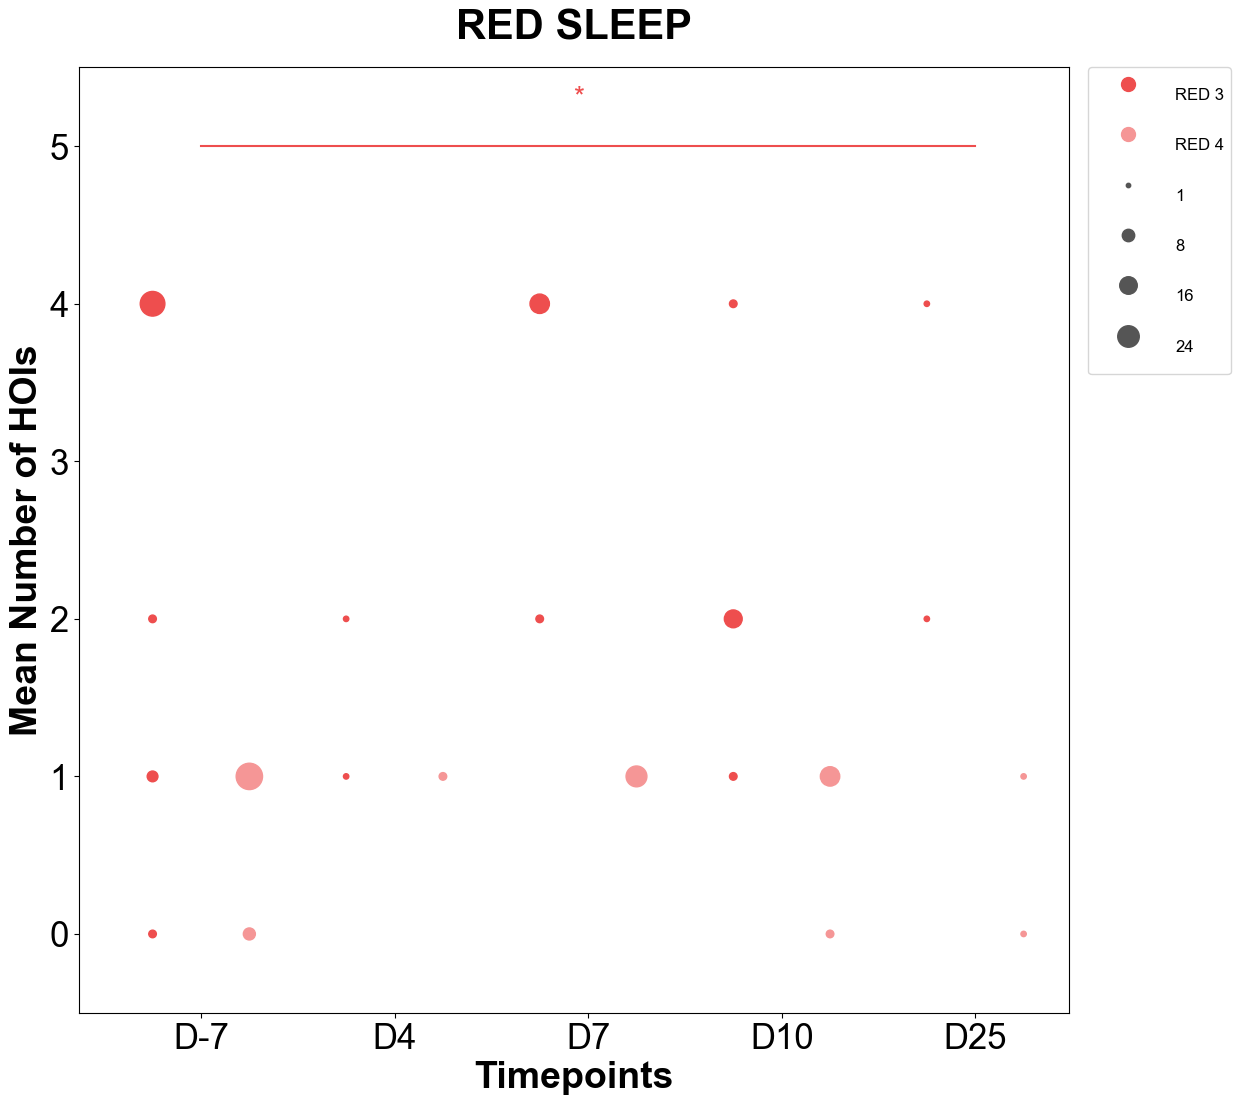

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

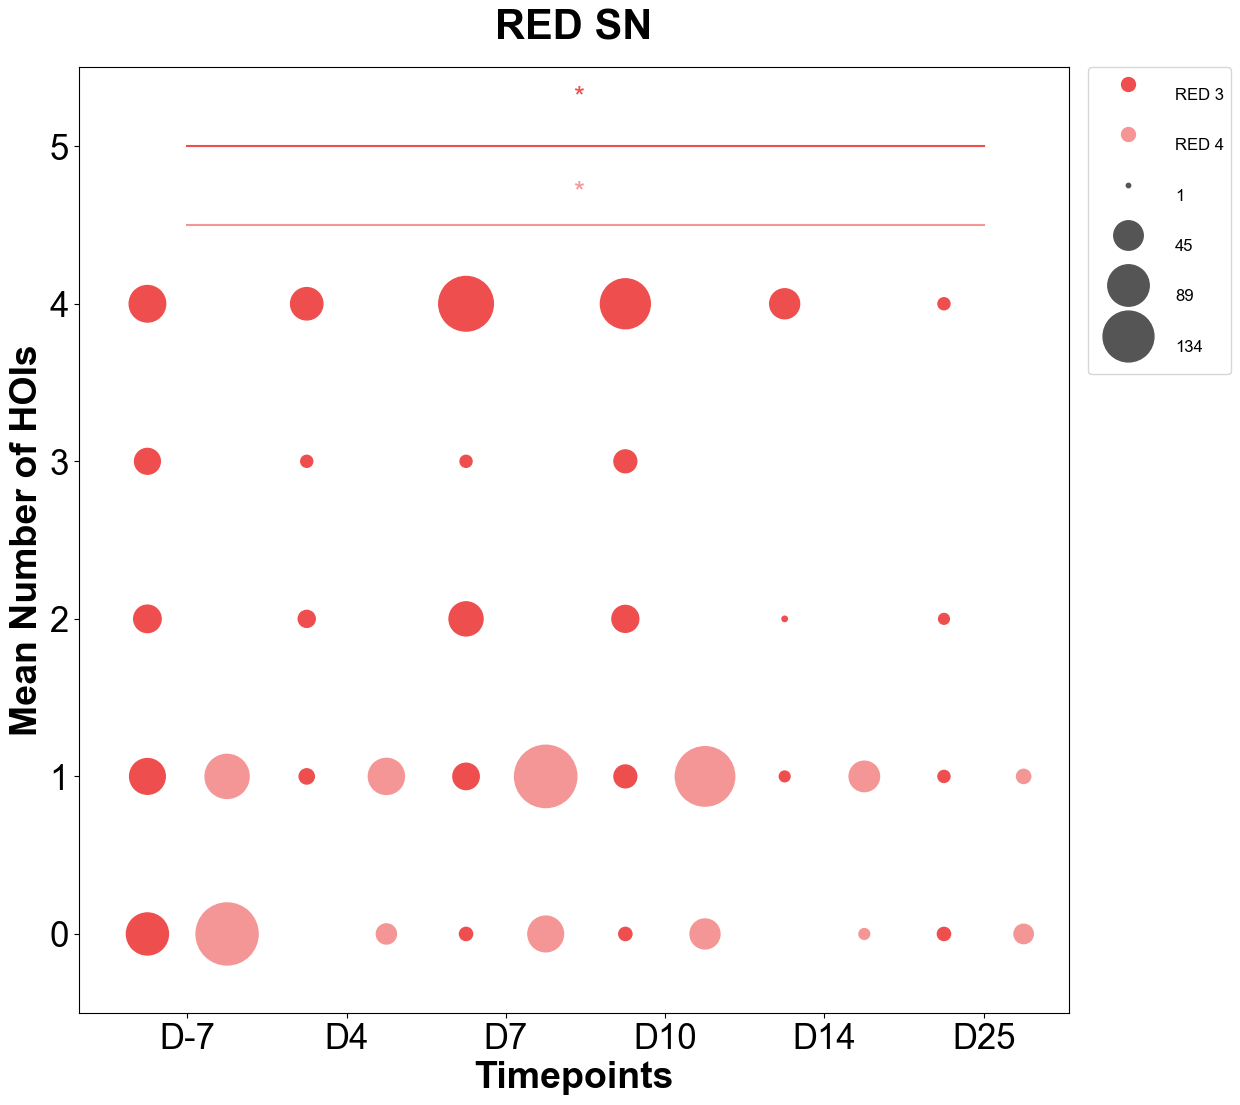

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

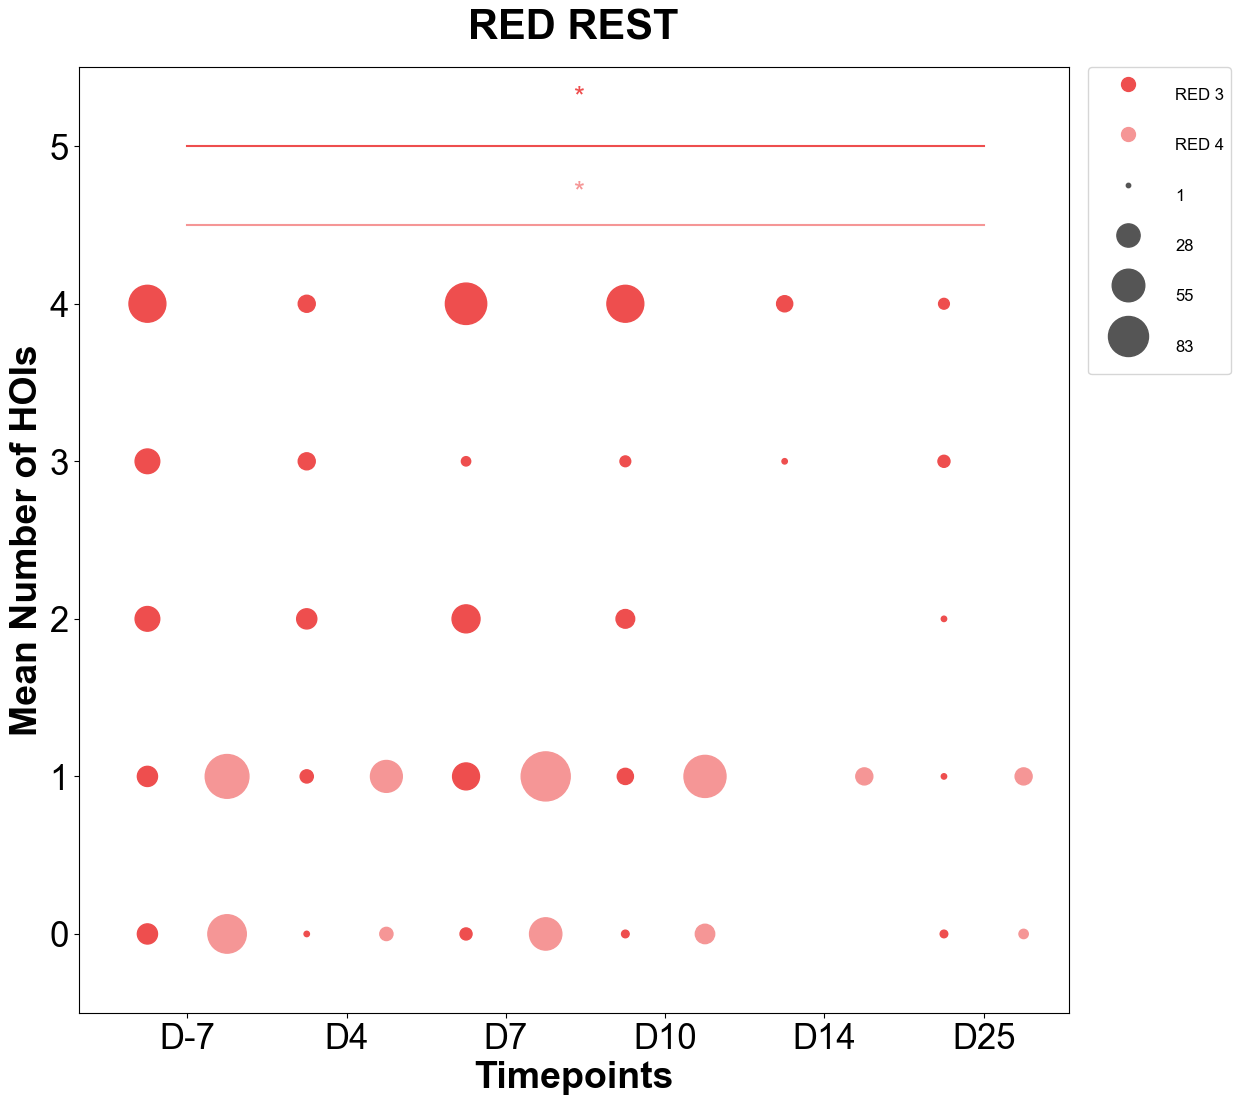

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

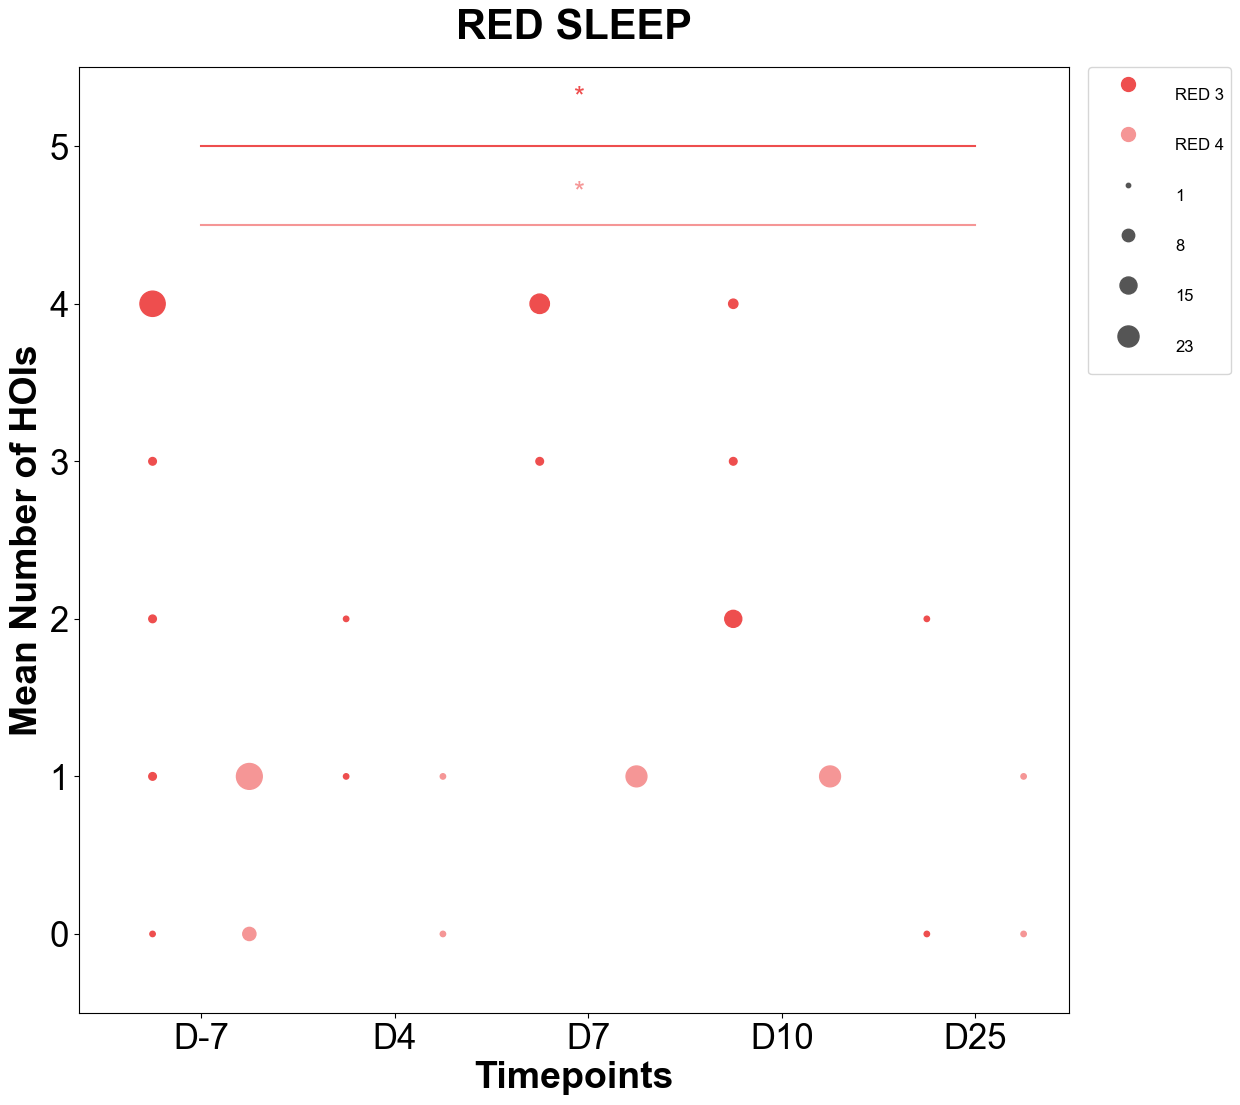

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

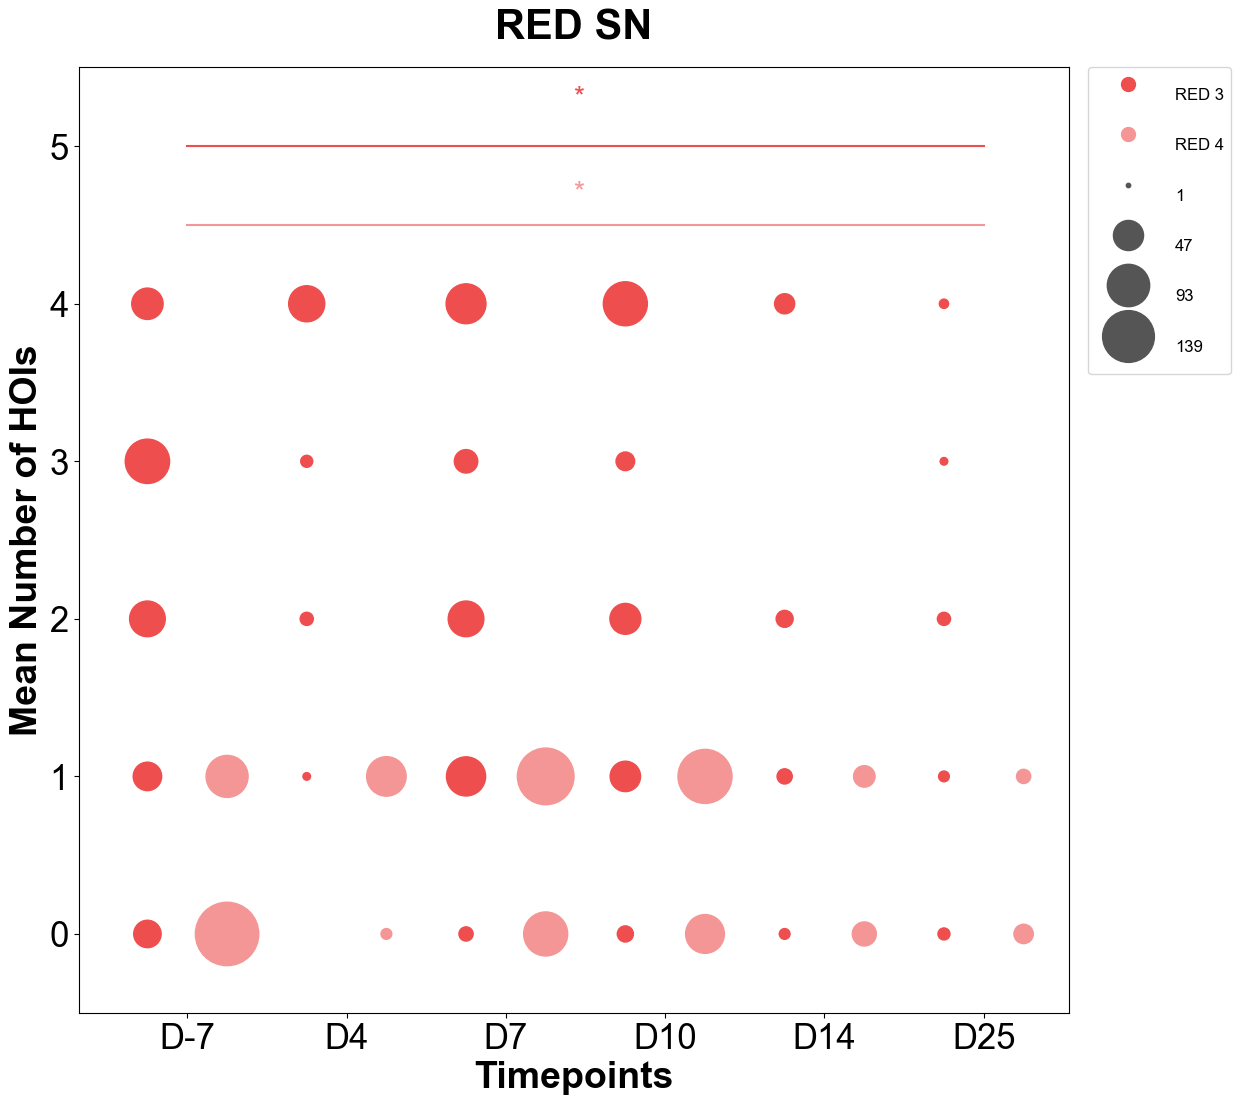

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

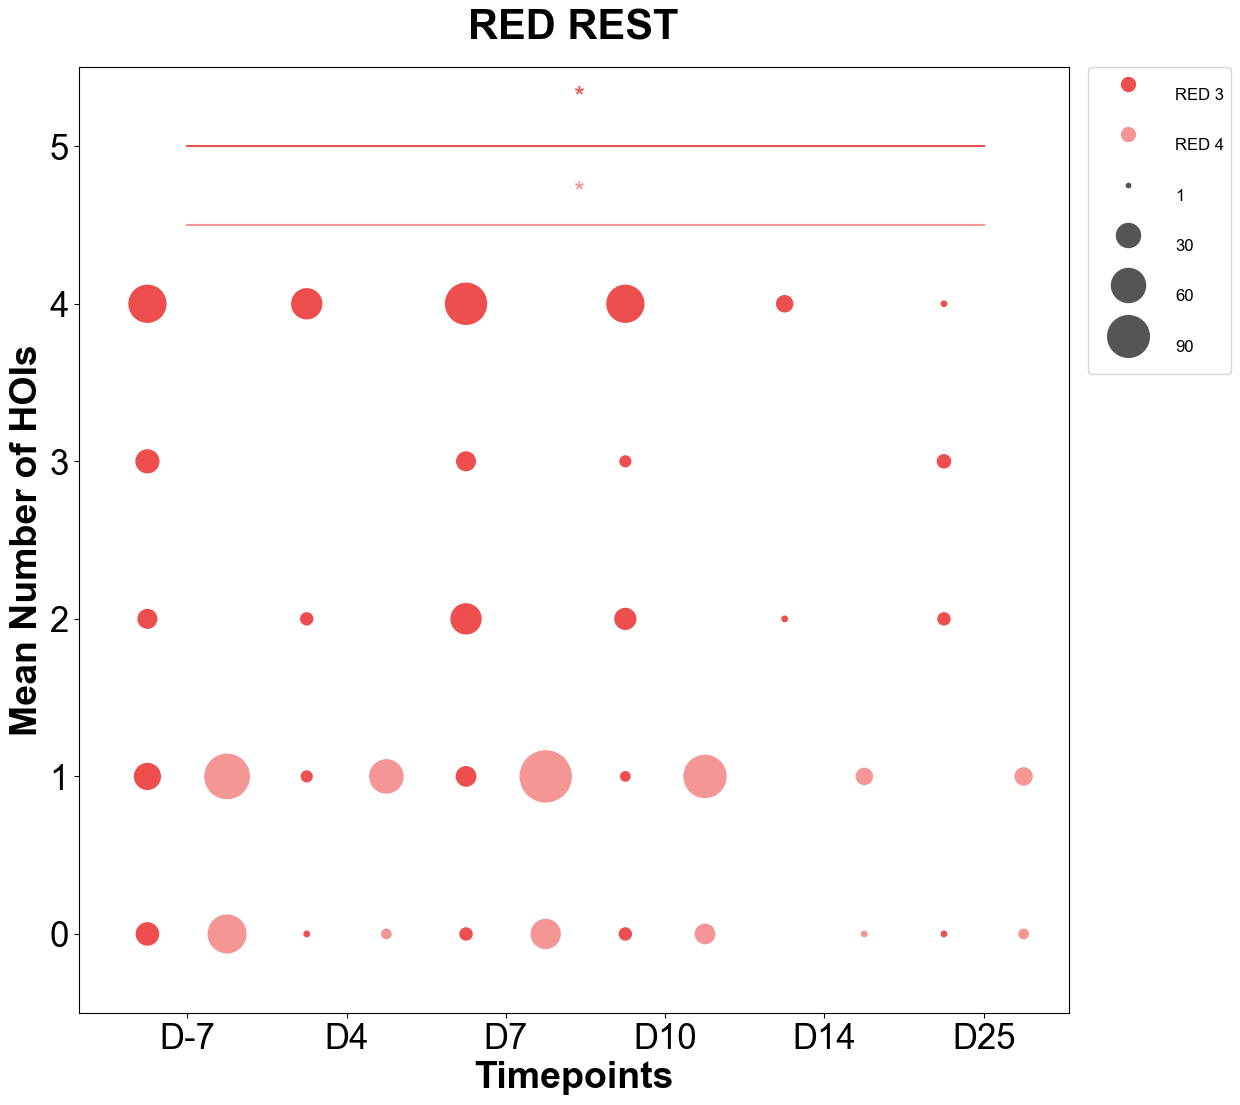

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

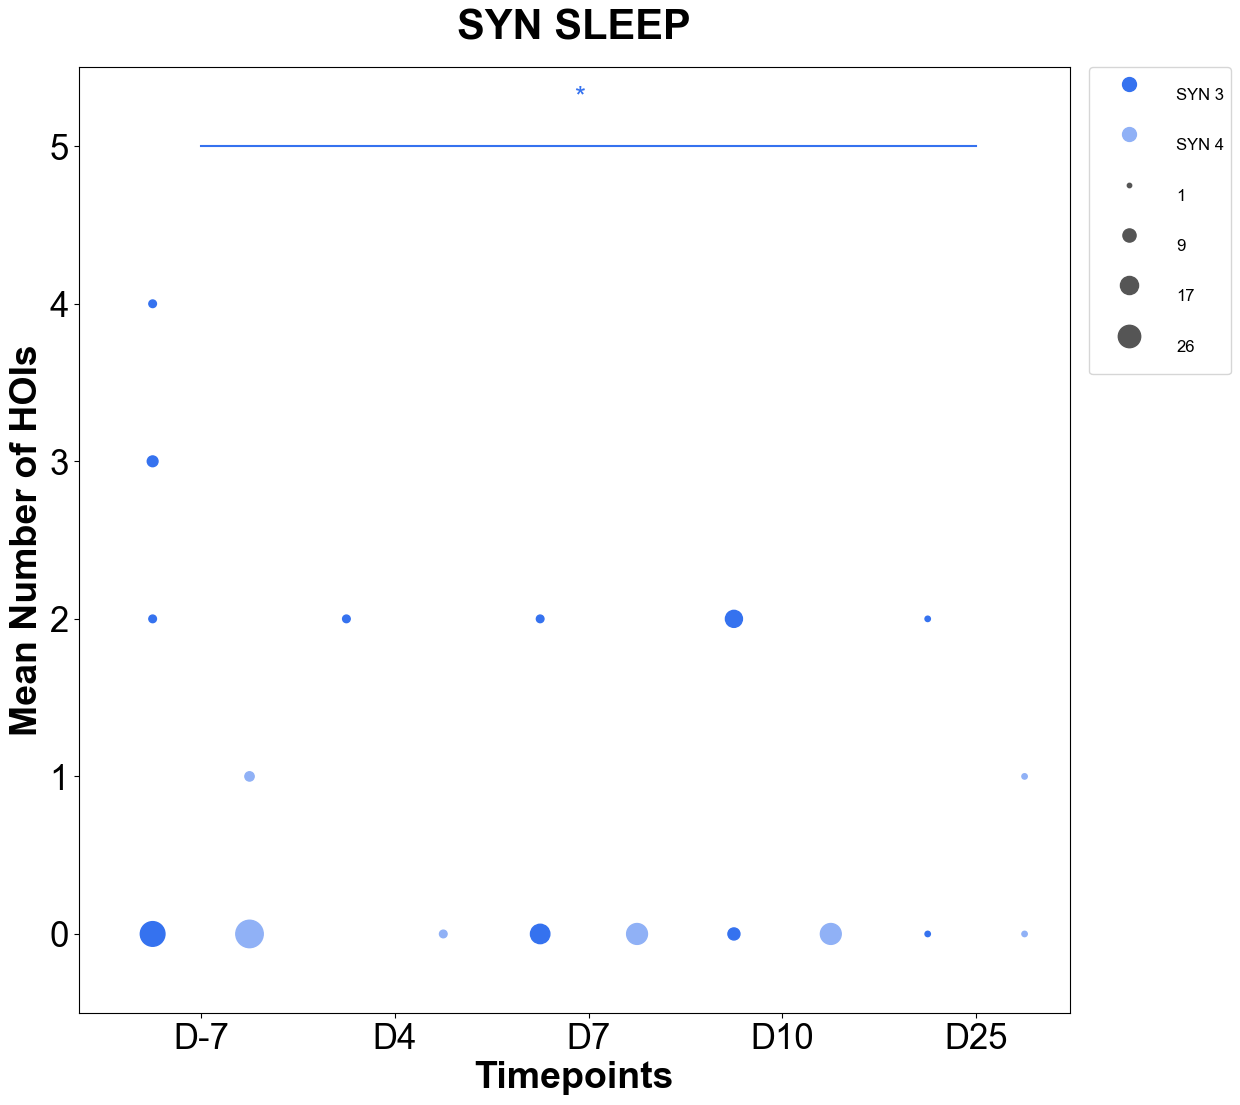

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

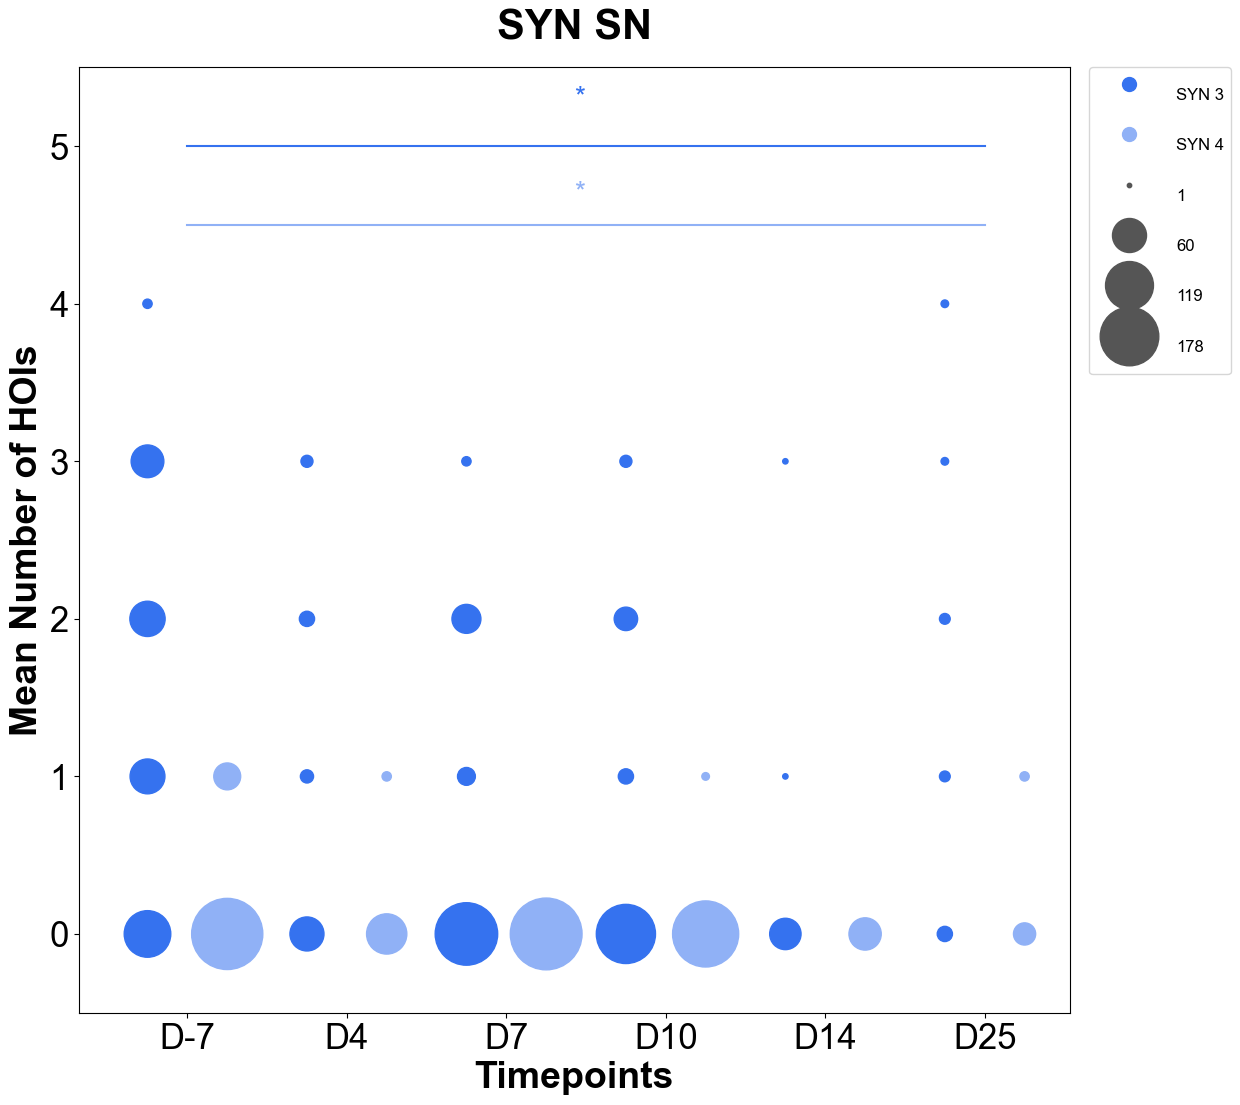

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

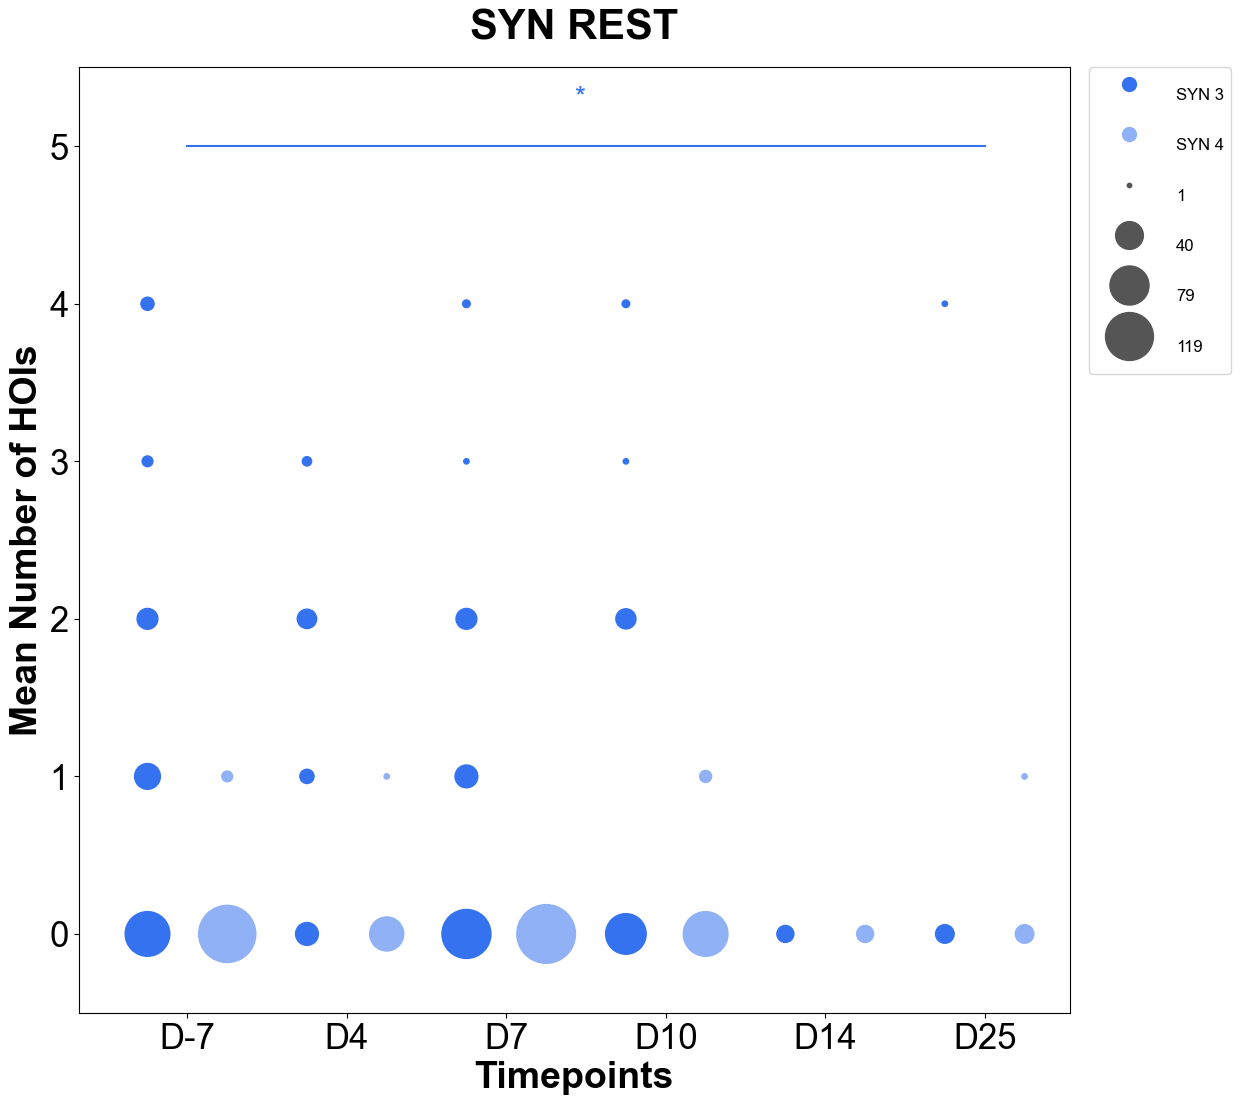

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

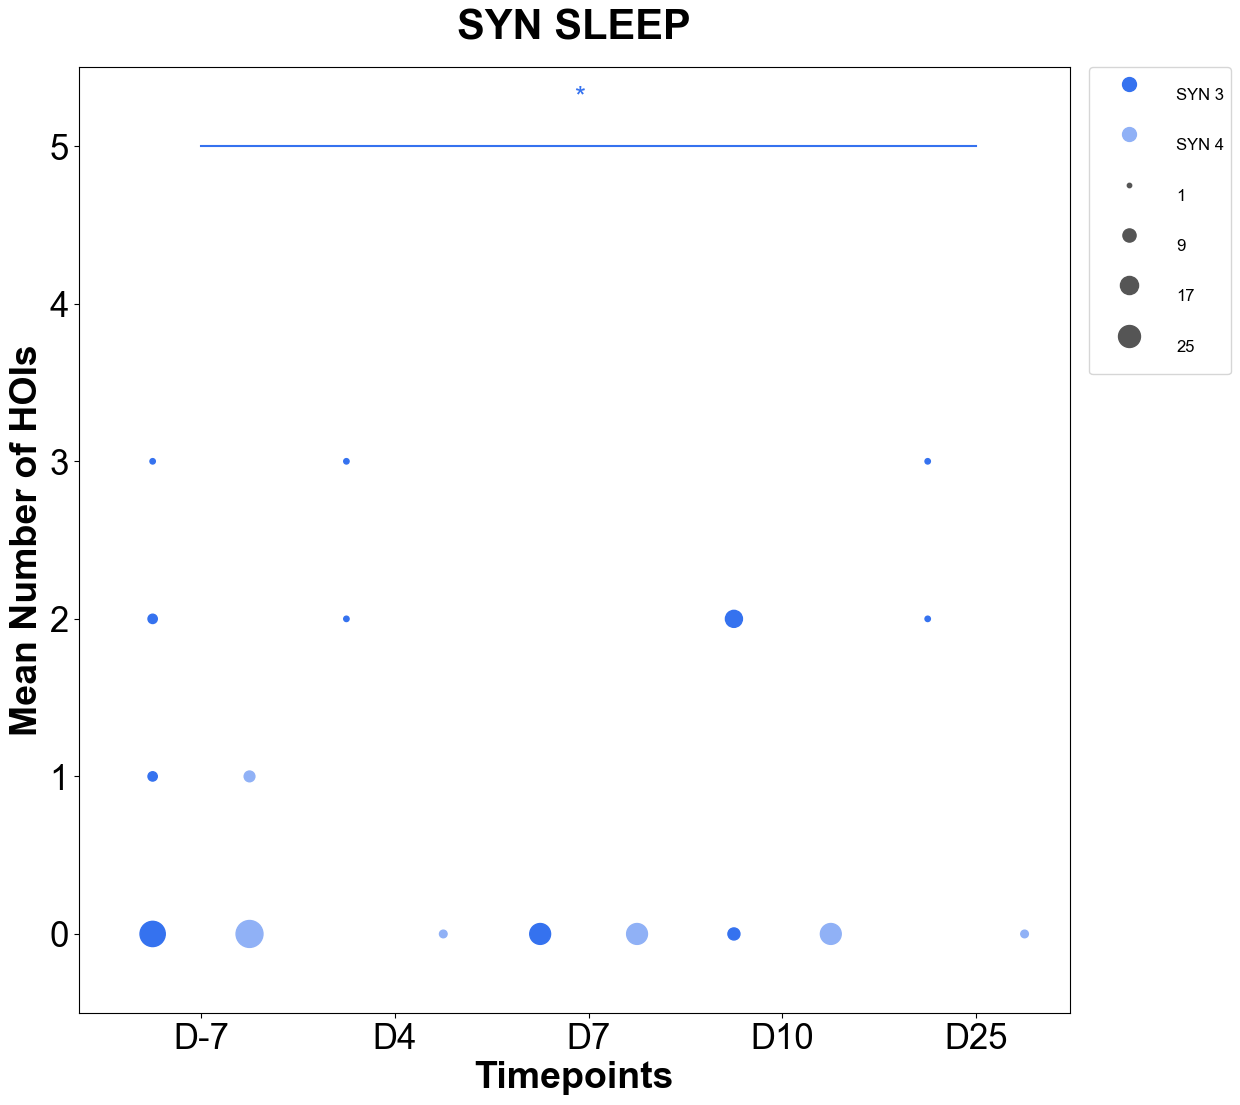

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

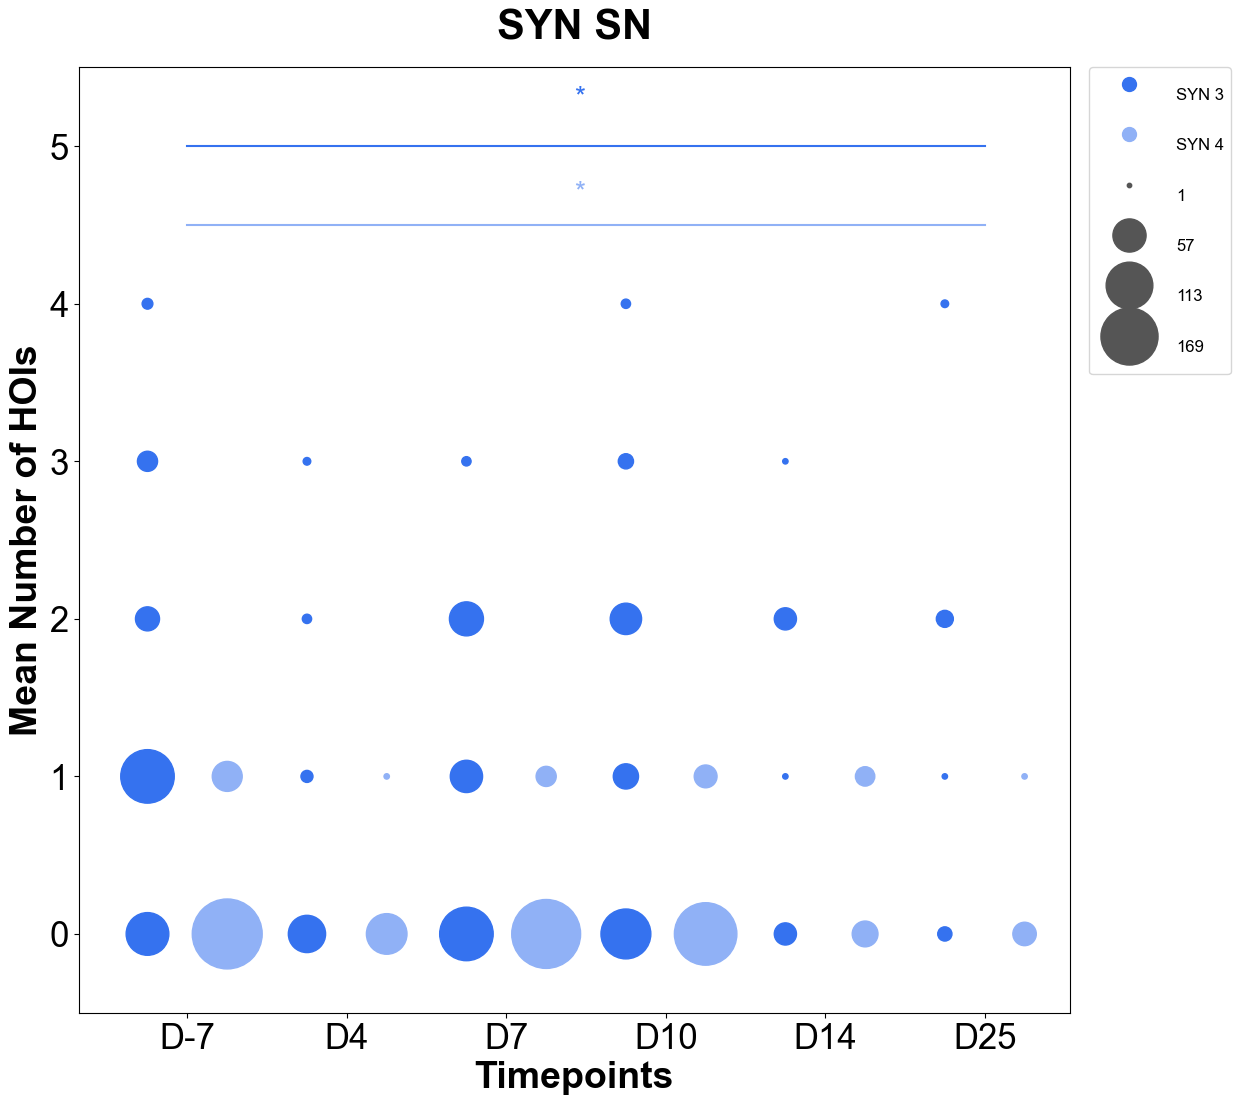

/tmp/ipykernel_77132/3521439435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch.drop(['group','epoch'],axis=1,inplace=True)
/tmp/ipykernel_77132/3521439435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(
/tmp/ipykernel_77132/3448069337.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend1.legendHandles[0]._sizes = [100]
/tmp/ipykernel_77132/3448069337.py:27: MatplotlibDeprecation

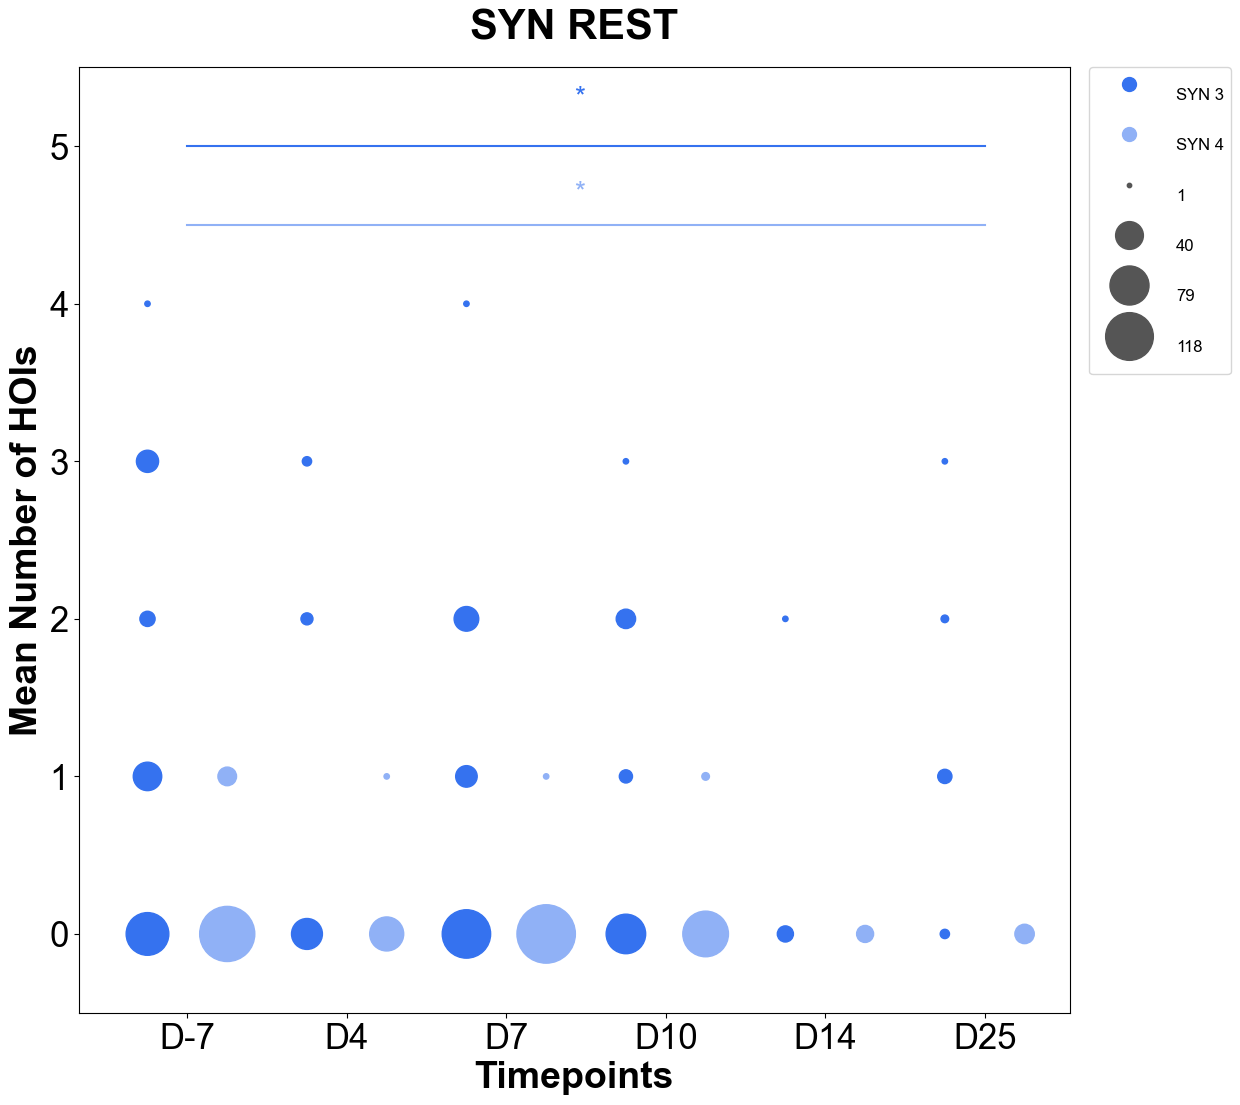

In [115]:
for _type in ['red','syn']:    
    df_type=df_num_interctions[df_num_interctions.type==_type]
    for group in [3,5]:
        df_group=df_type[df_type.group==group]


        # finding max values in all epochs
        ylim=(df_group.groupby(['epoch','timepoint','order']).std(numeric_only=True)['num_interactions'] + \
              df_group.groupby(['epoch','timepoint','order']).mean(numeric_only=True)['num_interactions']).max() *2

        for epoch in df_group.epoch.unique().tolist():
            plt.close()
            df_epoch=df_group[df_group.epoch==epoch]

            df_epoch.drop(['group','epoch'],axis=1,inplace=True)
            timepoints=sort_date(order=all_timepoints,timepoints=df_epoch.timepoint.unique().tolist())
            df_epoch['timepoint'] = pd.Categorical(
            df_epoch['timepoint'], 
            categories=timepoints, 
            ordered=True)
            df_epoch=df_epoch.sort_values('timepoint')
            ax=plot_geom_count_r(df_epoch,df_pvalue=results[(results.group==group)&(results.type==_type)&(results.epoch==epoch)],_type=_type)


            plt.title(f'{rename_type(_type)} {rename_epoch(epoch)}', fontsize=30, fontweight='bold', pad=20)

            plt.ylabel('Mean Number of HOIs', fontweight='bold', fontsize=27)
            plt.xlabel('Timepoints', fontweight='bold', fontsize=27)

            ax.set_xticklabels(ax.get_xticklabels(),fontsize=25)
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=25)
            # legend = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,handler_map=handler_map, fontsize=12)

            # for text in legend.get_texts():
            #     if text.get_text() == '3.0':
            #         text.set_text('order 3')
            #     if text.get_text() == '4.0':
            #         text.set_text('order 4')
            plt.savefig(SAVE_PATH_FIG/f'group {group}'/'occurrence'/ 
                       f'occurance_overtime_{_type}_group_{epoch}.svg',dpi=600,bbox_inches='tight')
            plt.show()



In [111]:
def plot_geom_count_r(df_plot,df_pvalue,ax):
    df_plot = df_plot.groupby(['timepoint','num_interactions', 'order']).size().reset_index(name='count')
    offset = {3.0: -0.25, 4.0: 0.25}  # Adjust these offsets as needed for better visualization
    
    # Assign numeric indices to 'cut' categories to allow for offset application
    unique_timepoint = df_epoch['timepoint'].unique()
    unique_timepoint = {t: i for i, t in enumerate(unique_timepoint)}
    df_plot['timepoint_index'] = df_plot['timepoint'].map(unique_timepoint)
    
    # Applying the offset to create separate columns for types A and B
    df_plot['timepoint_position'] = df_plot.apply(lambda row: row['timepoint_index'] + offset[row['order']], axis=1)
    df_plot['sizes'] = df_plot['count'] * 10  # Scale factor for visibility
    # Plotting with matplotlib
    # plt.figure(figsize=(10, 8))
    for order in [3.0, 4.0]:
        subset = df_plot[df_plot['order'] == order]
        ax.scatter(subset['timepoint_position'], subset['num_interactions'], s=subset['sizes'], alpha=0.5, label=f'Order {int(order)}',color=palette_order[order])
    
    # Setting the x-ticks to the center of each group of A and B columns
    plt.xticks(list(unique_timepoint.values()), unique_timepoint.keys())  # Set x-tick labels at the center positions
    

    return ax


In [ ]:

for group_num in [5,3]:
    
    df_summary_ineractions=analysis_num_interactions_group(df,_type,group_num).fillna(0)
    if df_summary_ineractions.shape[0]==0:continue
    
    df_summary_stat=df_summary_ineractions
    
    ylim=(df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).std(numeric_only=True) + 
         df_summary_ineractions.drop(['session','#session'],axis=1).groupby(['timepoint','epoch']).mean(numeric_only=True)).max().max() * 1.3
    for epoch in ['SN','VC','SLEEP']:
        for _type in ['red','syn']:
            # plt.close()
            df_epoch=df_summary_ineractions[df_summary_ineractions.epoch==epoch]
            df_plot=df_epoch.drop(['epoch','rat','session','#session'],axis=1)
            df_plot.set_index('timepoint',inplace=True)
            if df_plot.columns.shape[0]==0:
                ax = plot_text(text=f'No redundant interactions has been found in {rename_epoch(epoch)} group {group_num}',title='no data')
                plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'occurance_connections_redundent_{epoch}',dpi=300,bbox_inches='tight')
                continue
            df_plot=pd.DataFrame(df_plot.stack())
            df_plot=df_plot.reset_index()
            timepoints = sort_date(all_timepoints,df_plot.timepoint.unique().tolist())
            sns.barplot(df_plot,x='level_1',y=0,hue='timepoint',hue_order=timepoints,palette=palette_time, ci='sd',ax=axs[axes_number_i,axes_number_j])
            ##### stats 
            if len(df_summary_stat[df_summary_stat.epoch==epoch].timepoint.unique())>1:
                pairs,pvalues=stat_inteactions(df_summary_stat,epoch)
                if pairs!=[]:
                    annotator = Annotator(axs[axes_number_i,axes_number_j], data=df_plot, x='level_1', y=0,
                                               hue='timepoint',hue_order=timepoints,
                                               pairs=pairs)
    
                    annotator.configure(test=None, line_height=0,fontsize=30,line_width=3.0,
                                       pvalue_thresholds=[[0.0001, "****"], [0.001, "***"], [0.01, "**"], [0.05, "*"]],).set_pvalues(pvalues=pvalues).annotate()
            # add legends for p values
            # p1 = axs[axes_number_i,axes_number_j].bar(0,0, label="*      p <0.05")
            # p2 = ax.bar(0,0, label="**     p <0.01")
            # p3 = ax.bar(0,0, label="***    p <0.001")
            # p4 = ax.bar(0,0, label="****   p <0.0001")
    
            # subtitles = [p1, p2, p3,p4]
            # handler_map = subtitle_handler_map(subtitles)
    
            #####
            axs[axes_number_i,axes_number_j].tick_params(axis='x', rotation=90)
            axs[axes_number_i,axes_number_j].set_title(f'{rename_type(_type)} HOIs during {rename_epoch(epoch)}', fontsize=40, fontweight='bold')
            axs[axes_number_i,axes_number_j].set_ylim((0,ylim))
            # # Bold the x-tick and y-tick labels
            axs[axes_number_i,axes_number_j].set_xlabel('HOIs', fontweight='bold', fontsize=35)
            axs[axes_number_i,axes_number_j].set_ylabel('Mean number of HOIs', fontweight='bold', fontsize=35)
            axs[axes_number_i,axes_number_j].set_xticklabels(axs[axes_number_i,axes_number_j].get_xticklabels(), fontsize=32)
            axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=32)

            # if _type=='red' and epoch=='SN' and group_num==5:
            #     export_legend(axs[axes_number_i,axes_number_j].legen,SAVE_PATH_FIG/f'Figure3_legend.svg')
                
    
            # axs[axes_number_i, axes_number_j].legend_.remove()
            
            axes_number_j+=1
    axes_number_j=0    
    axes_number_i+=1
#         ax.set_ylim(0,2)

        # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,handler_map=handler_map,fontsize=12)
export_legend(axs[1,0].legend(),SAVE_PATH_FIG/f'Figure3_legend.svg')
plt.savefig(SAVE_PATH_FIG/f'Figure3_occurance_connections.svg',dpi=600,bbox_inches='tight')
plt.show()
        

# Effect Size Ovalue vs Mutual Info

/tmp/ipykernel_170642/568202487.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


SLEEP
    timepoint  value           type
0           0  0.000             MI
1           4  0.551             MI
2           7  0.739             MI
3          10  0.281             MI
4          25  0.320             MI
5           0  0.000  RED-3rd order
6           4  1.648  RED-3rd order
7           7  1.015  RED-3rd order
8          10  0.073  RED-3rd order
9          25  0.365  RED-3rd order
10          0  0.000  RED-4rd order
11          4  1.635  RED-4rd order
12          7  1.278  RED-4rd order
13         10  0.129  RED-4rd order
14         25  0.000  RED-4rd order
15          0  0.000  SYN-3rd order
16          4  0.000  SYN-3rd order
17          7  0.000  SYN-3rd order
18         10  0.000  SYN-3rd order
19         25  0.000  SYN-3rd order
20          0  0.000  SYN-4rd order
21          4  0.000  SYN-4rd order
22          7  0.000  SYN-4rd order
23         10  0.000  SYN-4rd order
24         25  0.000  SYN-4rd order


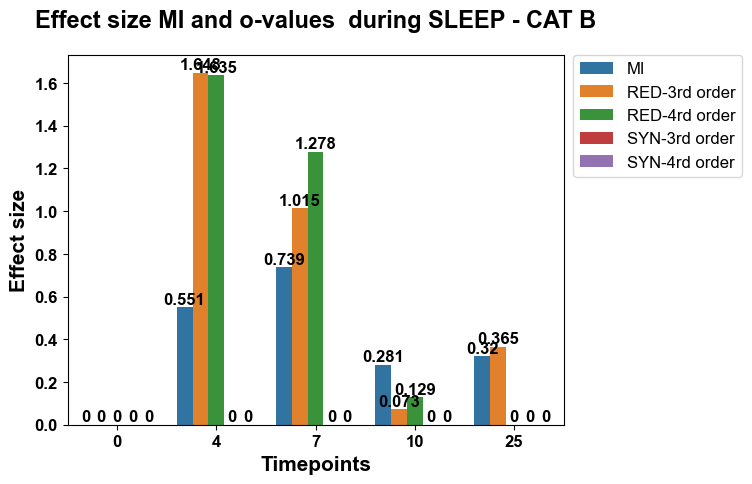

/tmp/ipykernel_170642/568202487.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


VC
    timepoint  value           type
0           0  0.000             MI
1           4  0.096             MI
2           7  0.276             MI
3          10  0.120             MI
4          14  0.119             MI
5          25  0.477             MI
6           0  0.000  RED-3rd order
7           4  0.174  RED-3rd order
8           7  0.530  RED-3rd order
9          10  0.004  RED-3rd order
10         14  0.104  RED-3rd order
11         25  0.514  RED-3rd order
12          0  0.000  RED-4rd order
13          4  0.429  RED-4rd order
14          7  0.432  RED-4rd order
15         10  0.165  RED-4rd order
16         14  0.060  RED-4rd order
17         25  0.805  RED-4rd order
18          0  0.000  SYN-3rd order
19          4  0.851  SYN-3rd order
20          7  1.392  SYN-3rd order
21         10  1.129  SYN-3rd order
22         25  0.557  SYN-3rd order
23          0  0.000  SYN-4rd order
24          4  1.670  SYN-4rd order
25          7  2.975  SYN-4rd order
26         10  1.280  SYN

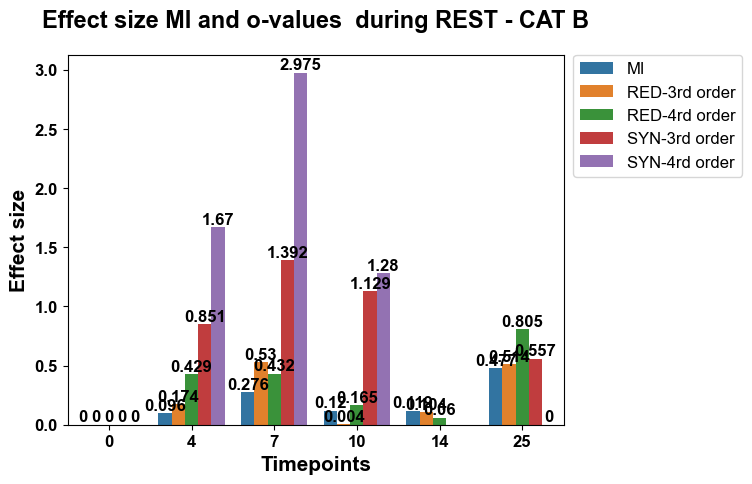

/tmp/ipykernel_170642/568202487.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


SN
    timepoint  value           type
0           0  0.000             MI
1           4  0.607             MI
2           7  0.068             MI
3          10  0.086             MI
4          14  0.115             MI
5          25  0.048             MI
6           0  0.000  RED-3rd order
7           4  0.452  RED-3rd order
8           7  0.137  RED-3rd order
9          10  0.233  RED-3rd order
10         14  0.212  RED-3rd order
11         25  0.304  RED-3rd order
12          0  0.000  RED-4rd order
13          4  0.395  RED-4rd order
14          7  0.141  RED-4rd order
15         10  0.725  RED-4rd order
16         14  0.598  RED-4rd order
17         25  0.315  RED-4rd order
18          0  0.000  SYN-3rd order
19          4  0.598  SYN-3rd order
20          7  0.675  SYN-3rd order
21         10  0.120  SYN-3rd order
22         14  0.397  SYN-3rd order
23         25  0.206  SYN-3rd order
24          0  0.000  SYN-4rd order
25          4  0.395  SYN-4rd order
26          7  0.141  SYN

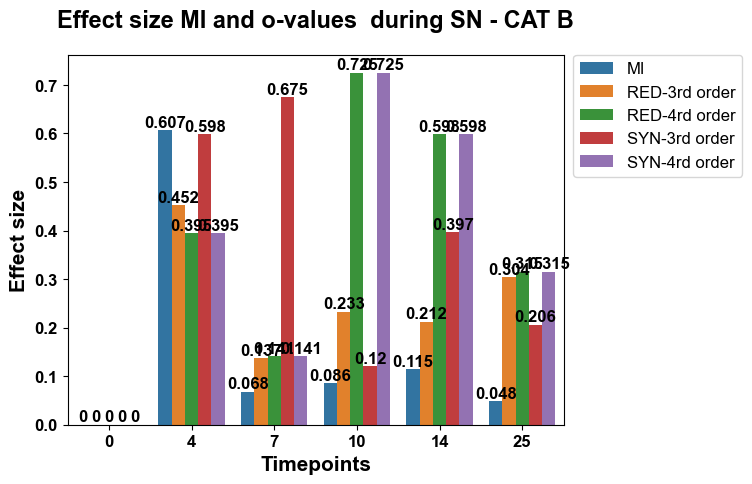

/tmp/ipykernel_170642/568202487.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


SLEEP
    timepoint  value           type
0           0  0.000             MI
1           4  0.100             MI
2           7  0.966             MI
3          10  0.529             MI
4          25  0.311             MI
5           0  0.000  RED-3rd order
6           4  0.512  RED-3rd order
7           7  1.180  RED-3rd order
8          10  0.947  RED-3rd order
9          25  0.515  RED-3rd order
10          0  0.000  RED-4rd order
11          4  0.003  RED-4rd order
12          7  1.114  RED-4rd order
13         10  2.231  RED-4rd order
14         25  0.000  RED-4rd order
15          0  0.000  SYN-3rd order
16          4  0.000  SYN-3rd order
17          7  0.000  SYN-3rd order
18         10  0.000  SYN-3rd order
19         25  0.000  SYN-3rd order
20          0  0.000  SYN-4rd order
21          4  0.000  SYN-4rd order
22          7  0.000  SYN-4rd order
23         10  0.000  SYN-4rd order
24         25  0.000  SYN-4rd order


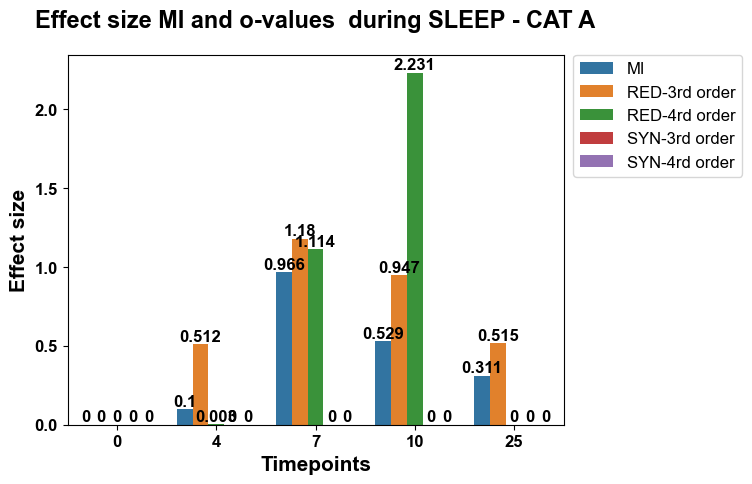

/tmp/ipykernel_170642/568202487.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


VC
    timepoint  value           type
0           0  0.000             MI
1           4  0.016             MI
2           7  0.487             MI
3          10  0.066             MI
4          14  0.364             MI
5          25  0.210             MI
6           0  0.000  RED-3rd order
7           4  0.245  RED-3rd order
8           7  0.662  RED-3rd order
9          10  0.318  RED-3rd order
10         14  0.609  RED-3rd order
11         25  0.353  RED-3rd order
12          0  0.000  RED-4rd order
13          4  0.458  RED-4rd order
14          7  0.619  RED-4rd order
15         10  0.444  RED-4rd order
16         14  0.801  RED-4rd order
17         25  0.648  RED-4rd order
18          0  0.000  SYN-3rd order
19          4  0.354  SYN-3rd order
20          7  0.910  SYN-3rd order
21         10  0.592  SYN-3rd order
22         14  0.524  SYN-3rd order
23         25  0.187  SYN-3rd order
24          0  0.000  SYN-4rd order
25          4  0.458  SYN-4rd order
26          7  0.619  SYN

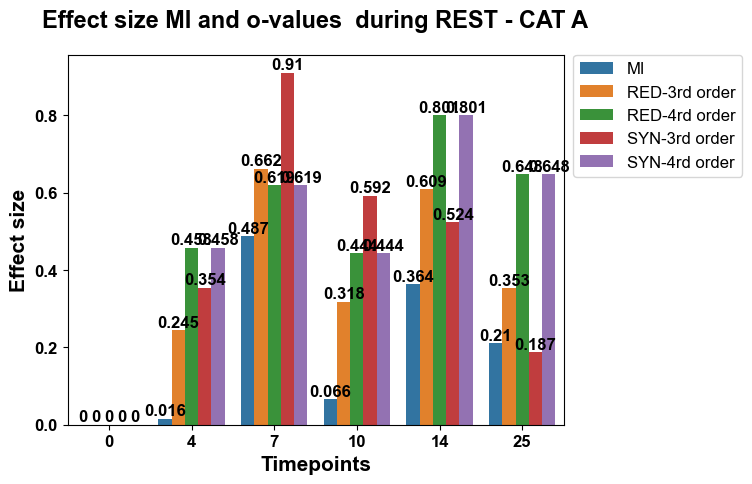

/tmp/ipykernel_170642/568202487.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)


SN
    timepoint  value           type
0           0  0.000             MI
1           4  1.017             MI
2           7  0.171             MI
3          10  0.097             MI
4          14  0.101             MI
5          25  0.047             MI
6           0  0.000  RED-3rd order
7           4  1.209  RED-3rd order
8           7  0.539  RED-3rd order
9          10  0.072  RED-3rd order
10         14  0.119  RED-3rd order
11         25  0.113  RED-3rd order
12          0  0.000  RED-4rd order
13          4  0.849  RED-4rd order
14          7  0.262  RED-4rd order
15         10  0.283  RED-4rd order
16         14  0.204  RED-4rd order
17         25  0.053  RED-4rd order
18          0  0.000  SYN-3rd order
19          4  0.145  SYN-3rd order
20          7  1.223  SYN-3rd order
21         10  0.205  SYN-3rd order
22         14  0.451  SYN-3rd order
23         25  0.542  SYN-3rd order
24          0  0.000  SYN-4rd order
25          4  0.849  SYN-4rd order
26          7  0.262  SYN

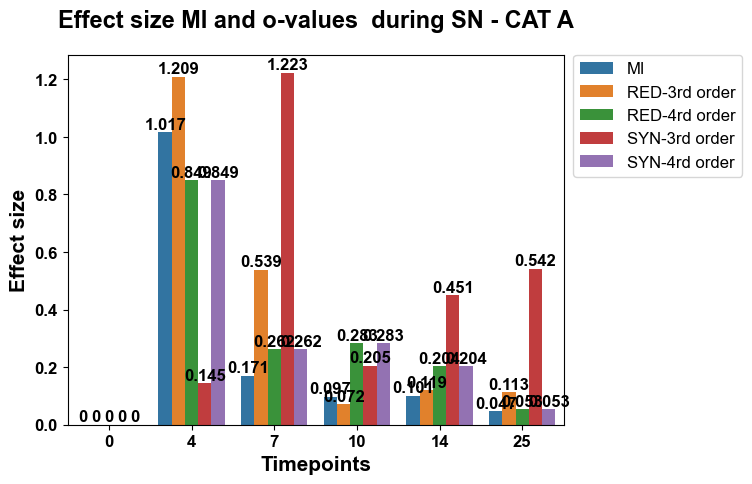

In [84]:
for group in [3,5]:
    for behavior in ['SLEEP','VC','SN']:
        effect_mutual=pd.read_excel(f'/media/morteza/data/Projects/Laetitia Project/results/2024_06_15/analysis/post_hoc_group_{group}_mutual_info_all_regions_cohen.xlsx',sheet_name=f'ES - epoch {behavior} - mutual info')
        effect_mutual=effect_mutual.set_index('Unnamed: 0')
        
        effect_oval=pd.read_excel('/media/morteza/data/Projects/Laetitia Project/results/2024_06_15/analysis/post_hoc_red_ovalues_cohen.xlsx',sheet_name=f'ES - group {group} - epoch {behavior}')
        effect_oval.fillna(method='ffill',inplace=True)
        effect_oval=effect_oval.set_index(['order',	'Unnamed: 1'])
        
        try:
            effect_oval_syn=pd.read_excel('/media/morteza/data/Projects/Laetitia Project/results/2024_06_15/analysis/post_hoc_syn_ovalues_cohen.xlsx',sheet_name=f'ES - group {group} - epoch {behavior}')
            effect_oval_syn.fillna(method='ffill',inplace=True)
            effect_oval_syn=effect_oval_syn.set_index(['order',	'Unnamed: 1'])
        except:
            effect_oval_syn=effect_oval.copy()
            effect_oval_syn.iloc[:,:]=0
        try:
            effect_oval_syn.loc[(4.0,0)]
        except:
            zeroes_4th=effect_oval.loc[4.0]
            zeroes_4th.index = pd.MultiIndex.from_product([[4], zeroes_4th.index], names=['order', 'Unnamed: 1'])
            effect_oval_syn=pd.concat([effect_oval_syn,zeroes_4th])
            
        
        
        # create plot dataframe
        df_mi_plot=pd.DataFrame(effect_mutual.loc[0]).set_axis(['value'], axis=1)
        df_mi_plot['type']='MI'
        
        df_o3_plot=pd.DataFrame(effect_oval.loc[(3.0,0)]).set_axis(['value'], axis=1)
        df_o3_plot['type']='RED-3rd order'
        df_o4_plot=pd.DataFrame(effect_oval.loc[(4.0,0)]).set_axis(['value'], axis=1)
        df_o4_plot['type']='RED-4rd order'

        
        df_o3_plot_syn=pd.DataFrame(effect_oval_syn.loc[(3.0,0)]).set_axis(['value'], axis=1)
        df_o3_plot_syn['type']='SYN-3rd order'
        df_o4_plot_syn=pd.DataFrame(effect_oval_syn.loc[(4.0,0)]).set_axis(['value'], axis=1)
        df_o4_plot_syn['type']='SYN-4rd order'

        
        df_plot=pd.concat([df_mi_plot,df_o3_plot,df_o4_plot,df_o3_plot_syn,df_o4_plot_syn])
        
        df_plot=df_plot.reset_index().rename(columns={'index':'timepoint'})
        
        #plot data
        ax=sns.barplot(df_plot,x='timepoint',y='value',hue='type',errorbar='sd')
    
        plt.title(f'Effect size MI and o-values  during {rename_epoch(behavior)} - {rename_group(group)}', fontsize=17, fontweight='bold', pad=20)
    
        plt.ylabel('Effect size', fontweight='bold', fontsize=15)
        plt.xlabel('Timepoints', fontweight='bold', fontsize=15)
    
        ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
        for i in range(len((ax.containers))):
            ax.bar_label(ax.containers[i],fontweight='bold',fontsize=12)
        plt.savefig(SAVE_PATH_FIG/f'group {group}'/ 
           f'effect_size{behavior}_{group}',dpi=600,bbox_inches='tight')
        print(behavior)
        print(df_plot)
        plt.show()

# Number of interactions

In [96]:
# red
df_inetractions_all=pd.DataFrame()
for group in [3,5]:
    df_group=df[df.group==group]
    df_inetractions_group=pd.DataFrame()
    for rat in df_group.rat.unique().tolist():
        df_rat=df_group[df_group.rat==rat]
        df_inetractions_rat=pd.DataFrame()
        for epoch in df_rat.epoch.unique().tolist():
            df_epoch=df_rat[df_rat.epoch==epoch]
            df_inetractions_epoch=pd.DataFrame()
            for timepoint in df_epoch.timepoint.unique().tolist():
                df_inetractions_timepoint=pd.DataFrame()
                df_timepoint=df_epoch[df_epoch.timepoint==timepoint]
                # remove SE rats for non BI timepoints
                df_timepoint=remove_sham_rats(df_timepoint,timepoint)
                df_inetractions_timepoint=pd.DataFrame()
                for order in [3,4]:
                    df_order=get_interactions_per_session(df_timepoint[f'index_var_red_{order}'])
                    # if all(get_interactions_per_session(df_timepoint[f'index_var_red_{order}'])['num_interactions'].values==0):
                    #     continue
                    df_order['order']=order
                    df_inetractions_timepoint=pd.concat([df_inetractions_timepoint,df_order])
                if df_inetractions_timepoint.shape[0]==0:continue
                df_inetractions_timepoint['timepoint']=timepoint
                df_inetractions_epoch=pd.concat([df_inetractions_epoch,df_inetractions_timepoint])
            df_inetractions_epoch['epoch']=epoch
            df_inetractions_rat=pd.concat([df_inetractions_rat,df_inetractions_epoch])
        df_inetractions_rat['rat']=rat
        df_inetractions_group=pd.concat([df_inetractions_group,df_inetractions_rat])
    df_inetractions_group['group']=group    
    df_inetractions_all=pd.concat([df_inetractions_all,df_inetractions_group])
df_inetractions_all.num_interactions=df_inetractions_all.num_interactions.astype(float)

In [97]:
df_inetractions_all['type']='red'
df_num_interctions=df_inetractions_all

In [98]:
# syn
df_inetractions_all=pd.DataFrame()
for group in [3,5]:
    df_group=df[df.group==group]
    df_inetractions_group=pd.DataFrame()
    for rat in df_group.rat.unique().tolist():
        df_rat=df_group[df_group.rat==rat]
        df_inetractions_rat=pd.DataFrame()
        for epoch in df_rat.epoch.unique().tolist():
            df_epoch=df_rat[df_rat.epoch==epoch]
            df_inetractions_epoch=pd.DataFrame()
            for timepoint in df_epoch.timepoint.unique().tolist():
                df_inetractions_timepoint=pd.DataFrame()
                df_timepoint=df_epoch[df_epoch.timepoint==timepoint]
                # remove SE rats for non BI timepoints
                df_timepoint=remove_sham_rats(df_timepoint,timepoint)
                df_inetractions_timepoint=pd.DataFrame()
                for order in [3,4]:
                    df_order=get_interactions_per_session(df_timepoint[f'index_var_syn_{order}'])
                    # if all(get_interactions_per_session(df_timepoint[f'index_var_syn_{order}'])['num_interactions'].values==0):
                    #     print(group,epoch,timepoint,rat,order)
                    #     print((df_order))
                        
                    df_order['order']=order
                    df_inetractions_timepoint=pd.concat([df_inetractions_timepoint,df_order])
                df_inetractions_timepoint['timepoint']=timepoint
                df_inetractions_epoch=pd.concat([df_inetractions_epoch,df_inetractions_timepoint])
            df_inetractions_epoch['epoch']=epoch
            df_inetractions_rat=pd.concat([df_inetractions_rat,df_inetractions_epoch])
        df_inetractions_rat['rat']=rat
        df_inetractions_group=pd.concat([df_inetractions_group,df_inetractions_rat])
    df_inetractions_group['group']=group    
    df_inetractions_all=pd.concat([df_inetractions_all,df_inetractions_group])
df_inetractions_all.num_interactions=df_inetractions_all.num_interactions.astype(float)

In [99]:
df_inetractions_all['type']='syn'
df_num_interctions=pd.concat([df_num_interctions,df_inetractions_all])

In [100]:
df_num_interctions['order']=df_num_interctions['order'].astype(int).astype(str)

In [101]:
df_red_syn_interactions = df_num_interctions.groupby(['group','epoch','timepoint','order','type'])[['num_interactions']].sum()
df_red_syn_interactions.reset_index(inplace=True)
df_red_syn_interactions = pd.pivot(df_red_syn_interactions,index=['group', 'epoch', 'timepoint'],columns=['type','order'],values='num_interactions').fillna(0)


# calculate TOTAL row
df_count=remove_sham_rats(df,'ALLTIMEPOINTS')
df_count.groupby(['group','epoch','timepoint']).count()
df_count['timepoint'].replace({'BI':0,'4D':4, '7D':7, '10D':10, '12D':12, '14D':14, '15D':15, '16D':16, '25D':25}
                                       ,inplace=True)

df_red_syn_interactions['Epochs'] = df_count.groupby(['group','epoch','timepoint']).count()['num_syn_total']
####

#devid by number of epochos
df_red_syn_interactions.iloc[:,:-1] = df_red_syn_interactions.iloc[:,:-1].div(df_red_syn_interactions['Epochs'], axis=0)

df_total=df_red_syn_interactions.groupby(level=[0,1]).sum(numeric_only=True).assign(Number='Total')
df_total=df_red_syn_interactions.groupby(level=[0,1]).sum(numeric_only=True).assign(Number='Total')
df_total=df_total.set_index([df_total.index,'Number'])
# Add row totals to the end of each 2-level index
df_red_syn_interactions = pd.concat([df_red_syn_interactions, df_total])
df_red_syn_interactions['Total HOIs ']=df_red_syn_interactions.iloc[:,0:4].sum(axis=1)
# sorting based on index
df_red_syn_interactions=df_red_syn_interactions.sort_index().apply(lambda x: round(x, 3))

# #save
# df_red_syn_interactions.to_excel(SAVE_PATH_ANALYSIS/'num_red_syn_interactions.xlsx')

/tmp/ipykernel_349392/413559765.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


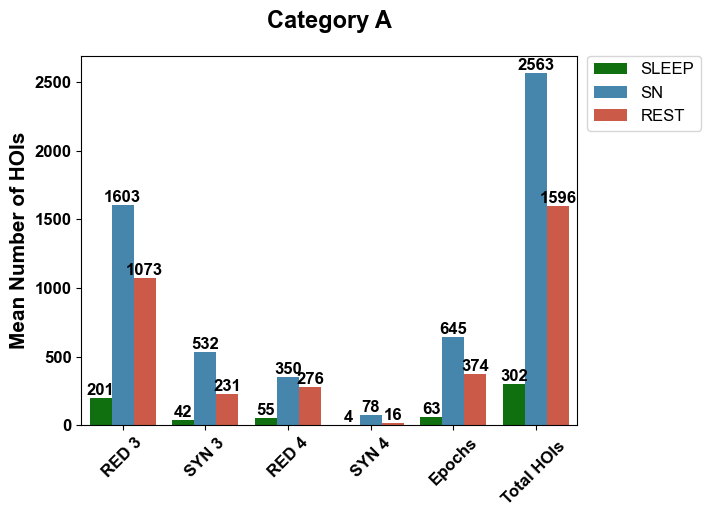

/tmp/ipykernel_349392/413559765.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


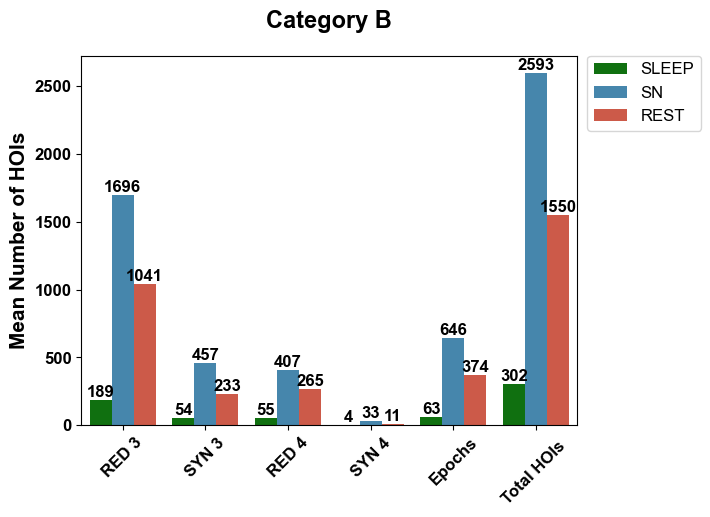

In [93]:
for group in [5,3]:
    df_plot=df_red_syn_interactions.query('timepoint == "Total"')
    # df_plot.drop([('Total # HOIs ',  ''),(      '#epochs',  '')],axis=1,inplace=True)
    df_plot=df_plot.reset_index()
    df_plot=df_plot[df_plot['group']==group]
    df_plot.columns=df_plot.columns.map(''.join)
    df_plot=pd.melt(df_plot, id_vars=['group','epoch','timepoint'], var_name='HOIs', value_name='Number of HOIs')
    df_plot=df_plot.rename(columns={"epoch":'Behavior'})
    df_plot['Behavior']=df_plot['Behavior'].map(rename_epoch)
    
    df_plot.loc[df_plot['HOIs']=='red3','HOIs']='RED 3'
    df_plot.loc[df_plot['HOIs']=='red4','HOIs']='RED 4'
    df_plot.loc[df_plot['HOIs']=='syn3','HOIs']='SYN 3'
    df_plot.loc[df_plot['HOIs']=='syn4','HOIs']='SYN 4'
    # ploting
    g=sns.barplot(x='HOIs', y='Number of HOIs', data=df_plot,hue='Behavior',palette=palette_epoch)
    plt.title(f'{rename_group(group)}', fontsize=17, fontweight='bold', pad=20)
    
    plt.ylabel('Mean Number of HOIs', fontweight='bold', fontsize=15)
    plt.xlabel('', fontweight='bold', fontsize=15)
    
    g.set_xticklabels(g.get_xticklabels(), fontweight='bold', fontsize=12)
    g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
    for i in range(len((g.containers))):
        g.bar_label(g.containers[i],fontweight='bold',fontsize=12)
    plt.xticks(rotation=45)
    plt.savefig(SAVE_PATH_FIG/f'group {group}'/'table1',dpi=300,bbox_inches='tight')
    plt.show()

/tmp/ipykernel_77132/2505787329.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i].set_yticklabels(axs[axes_number_i].get_yticklabels(), fontsize=25)
/tmp/ipykernel_77132/2505787329.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i].set_yticklabels(axs[axes_number_i].get_yticklabels(), fontsize=25)


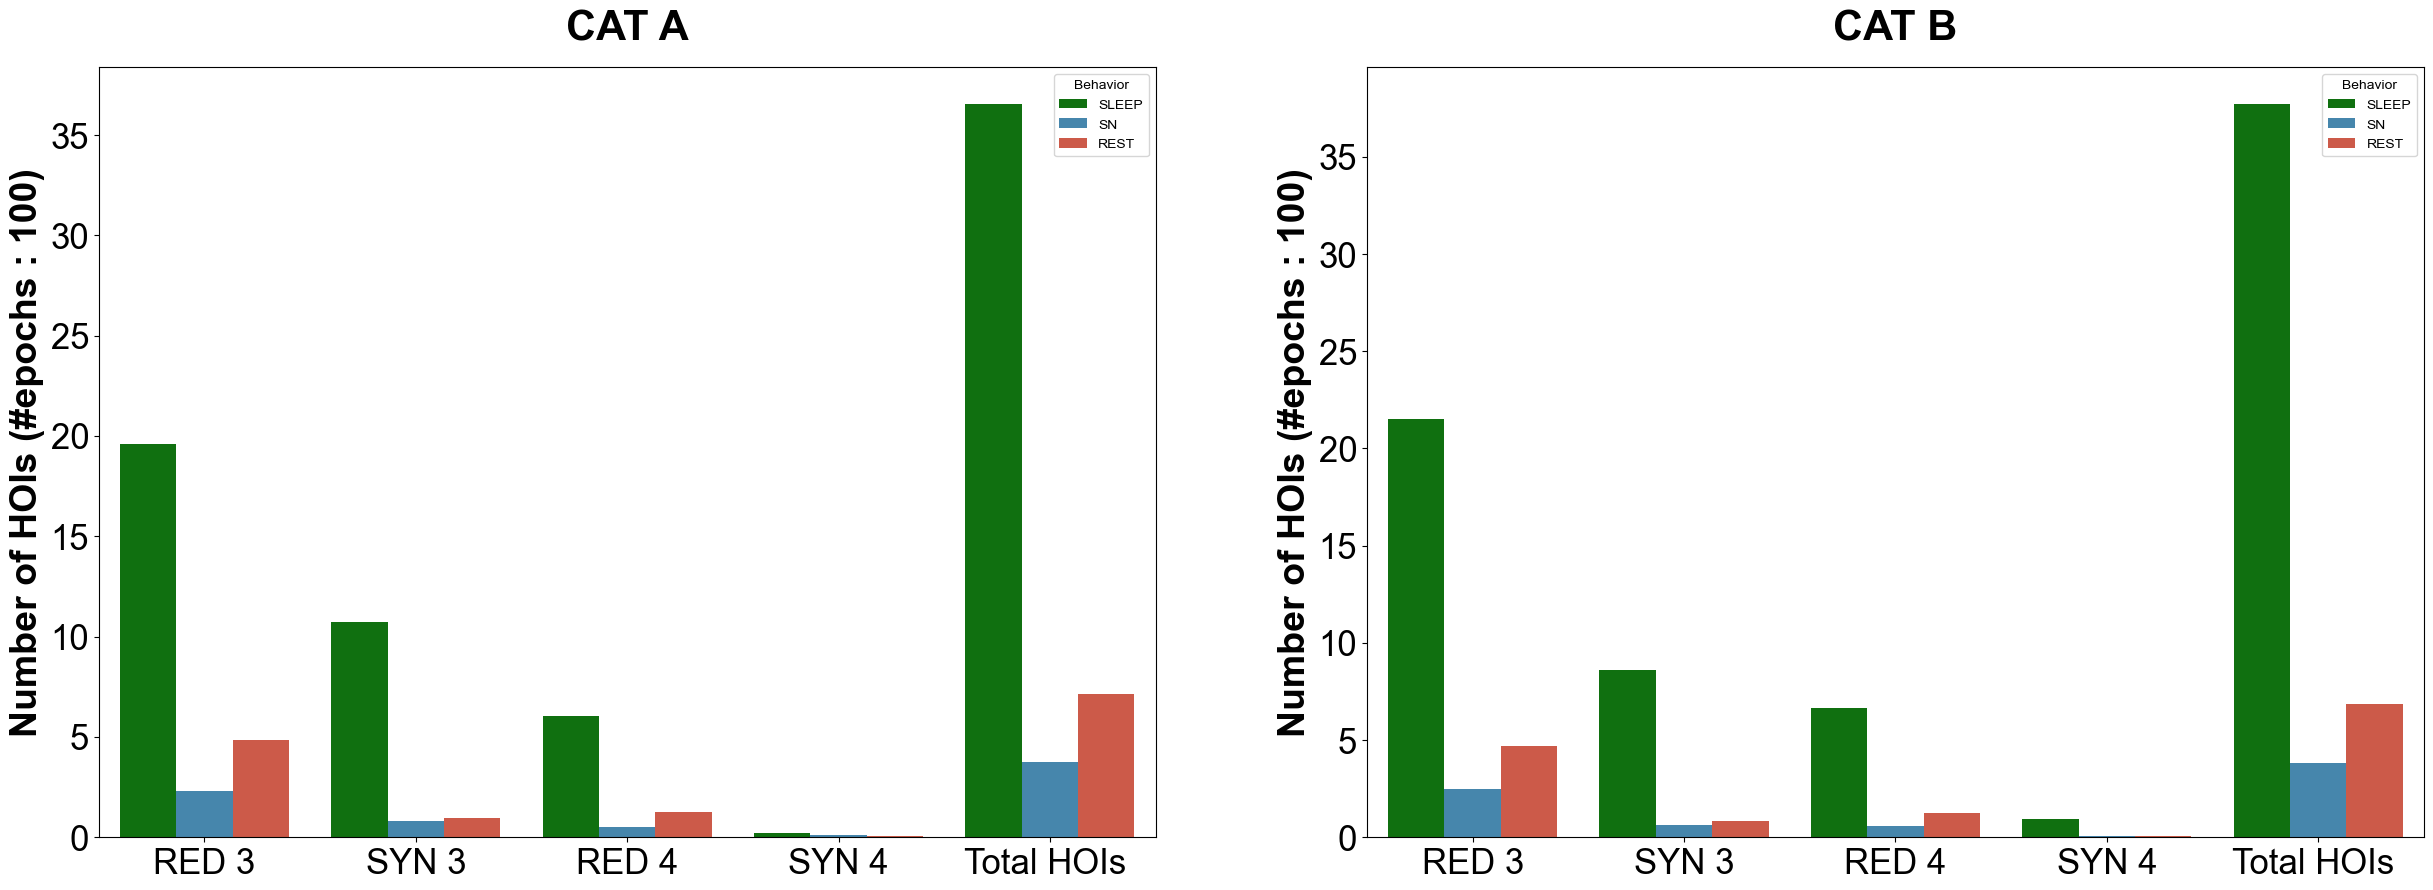

In [93]:


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
axes_number_i=0
axes_number_j=0

# Adjust the spacing between subplots
# plt.subplots_adjust(hspace=0.7, wspace=0.2)  # Adjust these values as needed

for group in [5,3]:
    df_plot=df_red_syn_interactions.query('timepoint == "Total"')
    # df_plot.drop([('Total # HOIs ',  ''),(      '#epochs',  '')],axis=1,inplace=True)
    df_plot=df_plot.reset_index()
    df_plot=df_plot[df_plot['group']==group]
    df_plot.columns=df_plot.columns.map(''.join)
    df_plot=pd.melt(df_plot, id_vars=['group','epoch','timepoint'], var_name='HOIs', value_name='Number of HOIs')
    df_plot=df_plot.rename(columns={"epoch":'Behavior'})
    df_plot['Behavior']=df_plot['Behavior'].map(rename_epoch)
    
    df_plot.loc[df_plot['HOIs']=='red3','HOIs']='RED 3'
    df_plot.loc[df_plot['HOIs']=='red4','HOIs']='RED 4'
    df_plot.loc[df_plot['HOIs']=='syn3','HOIs']='SYN 3'
    df_plot.loc[df_plot['HOIs']=='syn4','HOIs']='SYN 4'
    df_plot['Number of HOIs']=df_plot.groupby('Behavior').apply(lambda x: (x['Number of HOIs']/x[x['HOIs']=='Epochs']['Number of HOIs'].values)*100).reset_index(level=0)['Number of HOIs']
    df_plot=df_plot[~(df_plot['HOIs']=='Epochs')]
    
    # ploting
    sns.barplot(x='HOIs', y='Number of HOIs', data=df_plot,hue='Behavior',palette=palette_epoch,ax=axs[axes_number_i])
    axs[axes_number_i].set_title(f'{rename_group(group)}', fontsize=30, fontweight='bold', pad=20)
    
    axs[axes_number_i].set_ylabel('Number of HOIs (#epochs : 100)', fontweight='bold', fontsize=27)
    axs[axes_number_i].set_xlabel('', fontweight='bold', fontsize=27)
    
    axs[axes_number_i].set_xticklabels(axs[axes_number_i].get_xticklabels(), fontsize=25)
    axs[axes_number_i].set_yticklabels(axs[axes_number_i].get_yticklabels(), fontsize=25)
    axes_number_i+=1
    # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
    # for i in range(len((g.containers))):
    #     g.bar_label(g.containers[i],fontweight='bold',fontsize=12)
    # plt.xticks(rotation=45)
plt.savefig(SAVE_PATH_FIG/'Figure3_table2.svg',dpi=600,bbox_inches='tight')
plt.show()

In [198]:

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
# axes_number_i=0
# axes_number_j=0

# # Adjust the spacing between subplots
# # plt.subplots_adjust(hspace=0.7, wspace=0.2)  # Adjust these values as needed


# for group in [5,3]:
#     df_table=df_red_syn_interactions.loc[:,:,['D-7','D4','D7']]
#     # df_table.drop([('Total # HOIs ',  ''),(      'Wpochs',  '')],axis=1,inplace=True)
#     df_table=df_table.reset_index()
#     df_table=df_table[df_table['group']==group]
#     df_table.columns=df_table.columns.map(''.join)
#     for epoch in ['SN','VC','SLEEP']:
#         df_plot=df_table[df_table.epoch==epoch]
#         df_plot=pd.melt(df_plot, id_vars=['group','epoch','timepoint'], var_name='HOIs', value_name='Number of HOIs')
#         df_plot=df_plot.rename(columns={"epoch":'Behavior'})
#         df_plot['Behavior']=df_plot['Behavior'].map(rename_epoch)

#         df_plot.loc[df_plot['HOIs']=='red3','HOIs']='RED 3'
#         df_plot.loc[df_plot['HOIs']=='red4','HOIs']='RED 4'
#         df_plot.loc[df_plot['HOIs']=='syn3','HOIs']='SYN 3'
#         df_plot.loc[df_plot['HOIs']=='syn4','HOIs']='SYN 4'
        
#         # ploting
#         sns.barplot(x='timepoint', y='Number of HOIs', data=df_plot,hue='HOIs',palette=palette_order,ax=axs[axes_number_i,axes_number_j])
#         axs[axes_number_i,axes_number_j].set_title(f'{rename_epoch(epoch)}', fontsize=17, fontweight='bold', pad=20)
        
#         axs[axes_number_i,axes_number_j].set_ylabel('Mean Number of HOIs', fontweight='bold', fontsize=15)
#         axs[axes_number_i,axes_number_j].set_xlabel('', fontweight='bold', fontsize=15)
        
#         axs[axes_number_i,axes_number_j].set_xticklabels(g.get_xticklabels(), fontweight='bold', fontsize=12)
#         axs[axes_number_i,axes_number_j].set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)
#         # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
#         # for i in range(len((g.containers))):
#         #     g.bar_label(g.containers[i],fontweight='bold',fontsize=12)
#         # plt.xticks(rotation=45)
#         axs[axes_number_i, axes_number_j].legend_.remove()
#         axes_number_j+=1
        
#     axes_number_i+=1
#     axes_number_j=0
# # plt.savefig(SAVE_PATH_FIG/f'group {group}'/f'table3  {epoch}',dpi=300,bbox_inches='tight')
# export_legend(axs[1,0].legend(),SAVE_PATH_FIG/f'Figure6_legend.svg')
# plt.savefig(SAVE_PATH_FIG/f'Figure6_table3.svg',dpi=600,bbox_inches='tight')
# plt.show()

In [199]:
# for group in [5,3]:
#     df_plot=df_red_syn_interactions.query('timepoint == "Total"')
#     df_plot.drop([('Total # HOIs ',  ''),(      '#epochs',  '')],axis=1,inplace=True)
#     df_plot=df_plot.reset_index()
#     df_plot=df_plot[df_plot['group']==group]
#     df_plot.columns=df_plot.columns.map(''.join)
#     df_plot=pd.melt(df_plot, id_vars=['group','epoch','timepoint'], var_name='HOIs', value_name='Number of HOIs')
#     df_plot=df_plot.rename(columns={"epoch":'Behavior'})
#     df_plot['Behavior']=df_plot['Behavior'].map(rename_epoch)
    
#     df_plot.loc[df_plot['HOIs']=='red3','HOIs']='RED 3'
#     df_plot.loc[df_plot['HOIs']=='red4','HOIs']='RED 4'
#     df_plot.loc[df_plot['HOIs']=='syn3','HOIs']='SYN 3'
#     df_plot.loc[df_plot['HOIs']=='syn4','HOIs']='SYN 4'
#     # ploting
#     g=sns.barplot(x='HOIs', y='Number of HOIs', data=df_plot,hue='Behavior',palette=palette_epoch)
#     plt.title(f'{rename_group(group)}', fontsize=17, fontweight='bold', pad=20)
    
#     plt.ylabel('Mean Number of HOIs', fontweight='bold', fontsize=15)
#     plt.xlabel('', fontweight='bold', fontsize=15)
    
#     g.set_xticklabels(g.get_xticklabels(), fontweight='bold', fontsize=12)
#     g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)
#     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
#     for i in range(len((g.containers))):
#         g.bar_label(g.containers[i],fontweight='bold',fontsize=12)
#     plt.xticks(rotation=45)
#     plt.savefig(SAVE_PATH_FIG/f'group {group}'/'table3',dpi=300,bbox_inches='tight')
#     plt.show()

/tmp/ipykernel_349392/3330882555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_table.drop([('Total HOIs ',  ''),(      'Epochs',  '')],axis=1,inplace=True)
/tmp/ipykernel_349392/3330882555.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


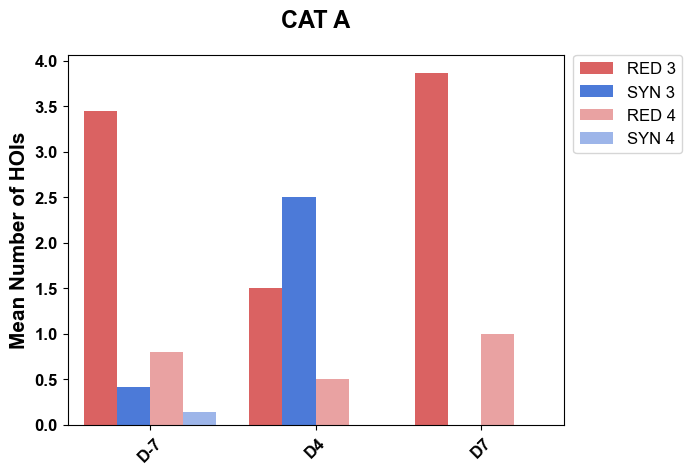

/tmp/ipykernel_349392/3330882555.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


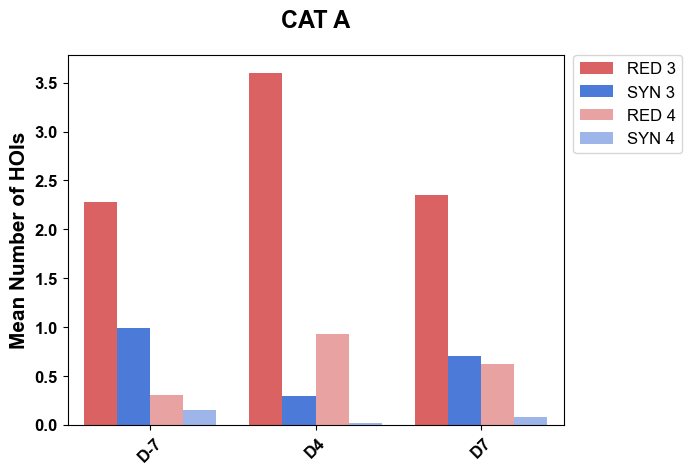

/tmp/ipykernel_349392/3330882555.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


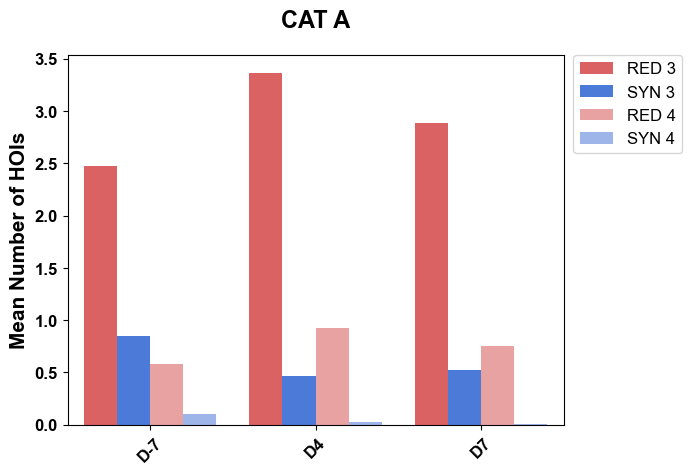

/tmp/ipykernel_349392/3330882555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_table.drop([('Total HOIs ',  ''),(      'Epochs',  '')],axis=1,inplace=True)
/tmp/ipykernel_349392/3330882555.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


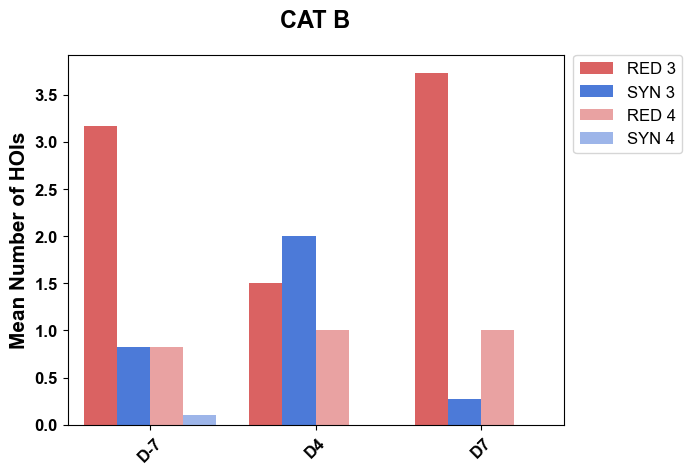

/tmp/ipykernel_349392/3330882555.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


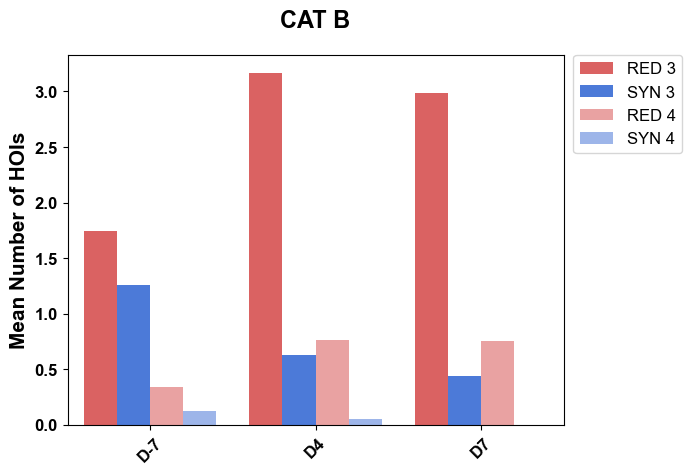

/tmp/ipykernel_349392/3330882555.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


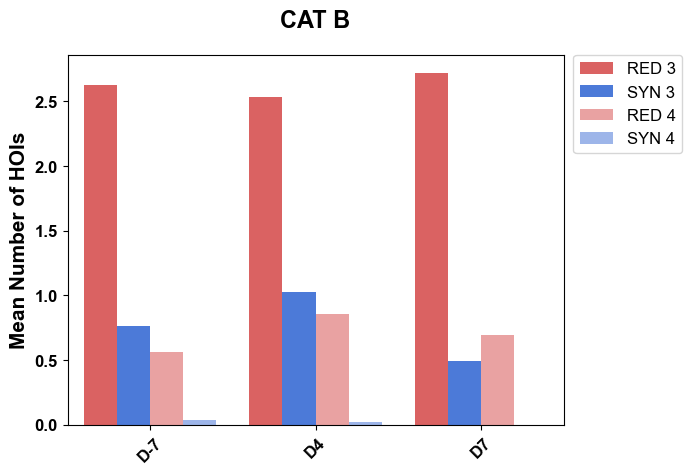

In [244]:
for group in [5,3]:
    df_table=df_red_syn_interactions.loc[:,:,['D-7','D4','D7']]
    df_table.drop([('Total HOIs ',  ''),(      'Epochs',  '')],axis=1,inplace=True)
    df_table=df_table.reset_index()
    df_table=df_table[df_table['group']==group]
    df_table.columns=df_table.columns.map(''.join)
    for epoch in df_table.epoch.unique():
        df_plot=df_table[df_table.epoch==epoch]
        df_plot=pd.melt(df_plot, id_vars=['group','epoch','timepoint'], var_name='HOIs', value_name='Number of HOIs')
        df_plot=df_plot.rename(columns={"epoch":'Behavior'})
        df_plot['Behavior']=df_plot['Behavior'].map(rename_epoch)
        
        # df_plot.rename(columns={'red3':'RED 3'},inplace=True)
        # df_plot.rename(columns={'red4':'RED 4'},inplace=True)
        # df_plot.rename(columns={'syn3':'SYN 3'},inplace=True)
        # df_plot.rename(columns={'syn4':'SYN 4'},inplace=True)
        
        df_plot.loc[df_plot['HOIs']=='red3','HOIs']='RED 3'
        df_plot.loc[df_plot['HOIs']=='red4','HOIs']='RED 4'
        df_plot.loc[df_plot['HOIs']=='syn3','HOIs']='SYN 3'
        df_plot.loc[df_plot['HOIs']=='syn4','HOIs']='SYN 4'
        
        # ploting
        g=sns.barplot(x='timepoint', y='Number of HOIs', data=df_plot,hue='HOIs',palette=palette_order)
        plt.title(f'{rename_group(group)}', fontsize=17, fontweight='bold', pad=20)
        
        plt.ylabel('Mean Number of HOIs', fontweight='bold', fontsize=15)
        plt.xlabel('', fontweight='bold', fontsize=15)
        
        g.set_xticklabels(g.get_xticklabels(), fontweight='bold', fontsize=12)
        g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
        # for i in range(len((g.containers))):
        #     g.bar_label(g.containers[i],fontweight='bold',fontsize=12)
        plt.xticks(rotation=45)
        plt.savefig(SAVE_PATH_FIG/f'group {group}'/f'table3  {epoch}',dpi=300,bbox_inches='tight')
        plt.show()

In [227]:
# df_red_syn_interactions.iloc[:,:-1] = df_red_syn_interactions.iloc[:,:-1].div(df_red_syn_interactions['Epochs'], axis=0)

<Axes: xlabel='timepoint', ylabel='Number of HOIs'>

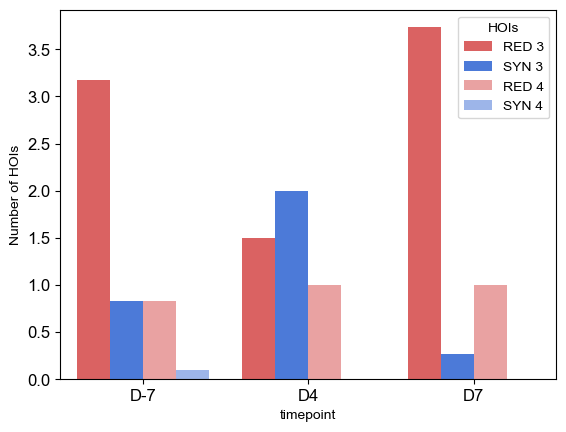

In [237]:
sns.barplot(x='timepoint', y='Number of HOIs', data=df_plot,hue='HOIs',palette=palette_order)

/tmp/ipykernel_349392/4093585357.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_table.drop([('Total HOIs ',  ''),(      'Epochs',  '')],axis=1,inplace=True)
/tmp/ipykernel_349392/4093585357.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=18)
/tmp/ipykernel_349392/4093585357.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=18)
/tmp/ipykernel_349392/4093585357.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,a

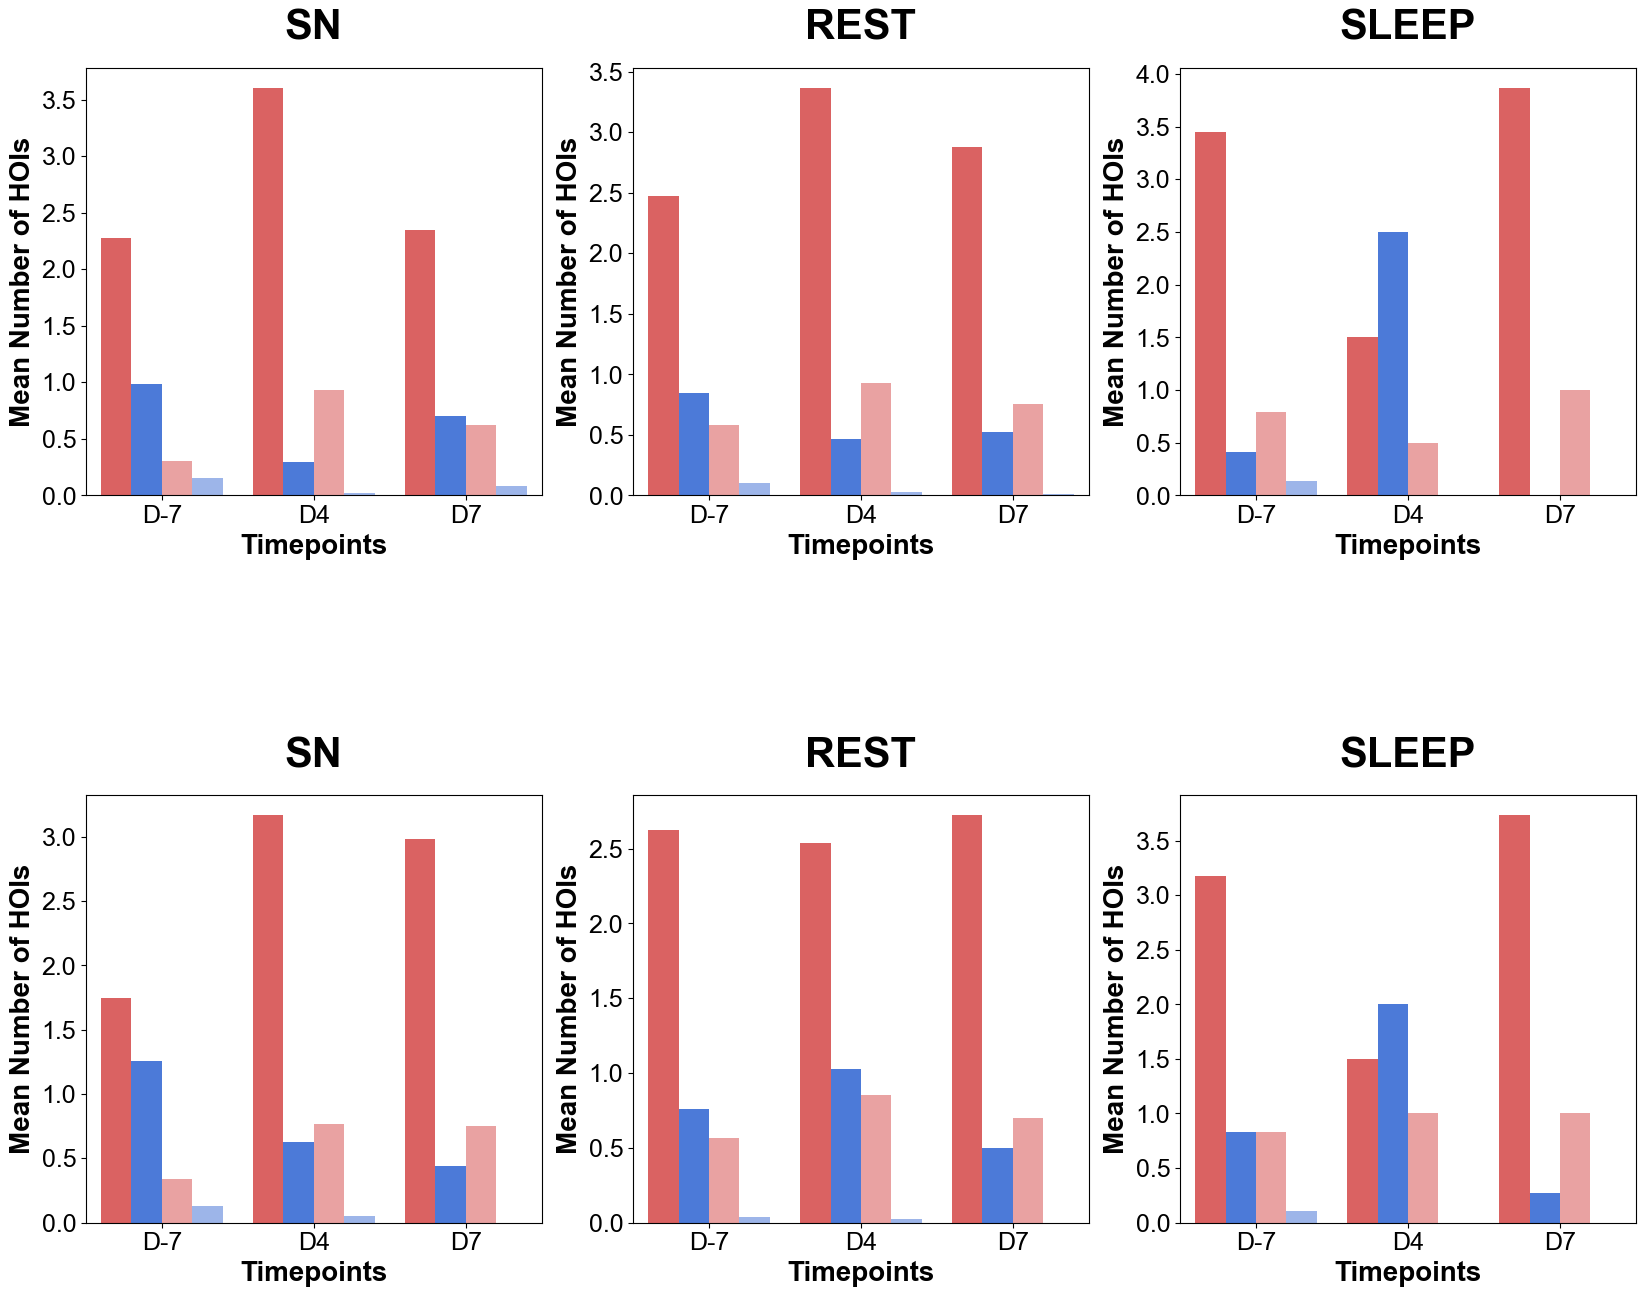

In [250]:
plt.close()
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
axes_number_i=0
axes_number_j=0

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.7, wspace=0.2)  # Adjust these values as needed


for group in [5,3]:
    df_table=df_red_syn_interactions.loc[:,:,['D-7','D4','D7']]
    df_table.drop([('Total HOIs ',  ''),(      'Epochs',  '')],axis=1,inplace=True)
    df_table=df_table.reset_index()
    df_table=df_table[df_table['group']==group]
    df_table.columns=df_table.columns.map(''.join)
    for epoch in ['SN','VC','SLEEP']:
        df_plot=df_table[df_table.epoch==epoch]
        df_plot=pd.melt(df_plot, id_vars=['group','epoch','timepoint'], var_name='HOIs', value_name='Number of HOIs')
        df_plot=df_plot.rename(columns={"epoch":'Behavior'})
        df_plot['Behavior']=df_plot['Behavior'].map(rename_epoch)

        df_plot.loc[df_plot['HOIs']=='red3','HOIs']='RED 3'
        df_plot.loc[df_plot['HOIs']=='red4','HOIs']='RED 4'
        df_plot.loc[df_plot['HOIs']=='syn3','HOIs']='SYN 3'
        df_plot.loc[df_plot['HOIs']=='syn4','HOIs']='SYN 4'
        
        # ploting
        sns.barplot(x='timepoint', y='Number of HOIs', data=df_plot,hue='HOIs',palette=palette_order,ax=axs[axes_number_i,axes_number_j])
        axs[axes_number_i,axes_number_j].set_title(f'{rename_epoch(epoch)}', fontsize=30, fontweight='bold', pad=20)
        
        axs[axes_number_i,axes_number_j].set_ylabel('Mean Number of HOIs', fontweight='bold', fontsize=20)
        axs[axes_number_i,axes_number_j].set_xlabel('Timepoints', fontweight='bold', fontsize=20)
        
        axs[axes_number_i,axes_number_j].set_xticklabels(axs[axes_number_i,axes_number_j].get_xticklabels(), fontsize=18)
        axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=18)
        # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
        # for i in range(len((g.containers))):
        #     g.bar_label(g.containers[i],fontweight='bold',fontsize=12)
        # plt.xticks(rotation=45)
        axs[axes_number_i, axes_number_j].legend_.remove()
        axes_number_j+=1
        
    axes_number_i+=1
    axes_number_j=0
# plt.savefig(SAVE_PATH_FIG/f'group {group}'/f'table3  {epoch}',dpi=300,bbox_inches='tight')
# export_legend(axs[1,0].legend(),SAVE_PATH_FIG/f'Figure6_legend.svg')
plt.savefig(SAVE_PATH_FIG/f'Figure6_table3.svg',dpi=600,bbox_inches='tight')
plt.show()

In [180]:
axs[axes_number_i, axes_number_j].get_lege

<Axes: >

# Table 2

In [101]:
df_red_syn_interactions = df_num_interctions.groupby(['group','epoch','timepoint','order','type'])[['num_interactions']].sum()
df_red_syn_interactions.reset_index(inplace=True)
df_red_syn_interactions = pd.pivot(df_red_syn_interactions,index=['group', 'epoch', 'timepoint'],columns=['type','order'],values='num_interactions').fillna(0)


# calculate TOTAL row
df_count=remove_sham_rats(df,'ALLTIMEPOINTS')
df_count.groupby(['group','epoch','timepoint']).count()
df_count['timepoint'].replace({'BI':0,'4D':4, '7D':7, '10D':10, '12D':12, '14D':14, '15D':15, '16D':16, '25D':25}
                                       ,inplace=True)

df_red_syn_interactions['#epochs'] = df_count.groupby(['group','epoch','timepoint']).count()['num_syn_total']
####

#devid by number of epochos
df_red_syn_interactions.iloc[:,:-1] = df_red_syn_interactions.iloc[:,:-1].div(df_red_syn_interactions['#epochs'], axis=0)

df_total=df_red_syn_interactions.groupby(level=[0,1]).sum(numeric_only=True).assign(Number='Total')
df_total=df_red_syn_interactions.groupby(level=[0,1]).sum(numeric_only=True).assign(Number='Total')
df_total=df_total.set_index([df_total.index,'Number'])
# Add row totals to the end of each 2-level index
df_red_syn_interactions = pd.concat([df_red_syn_interactions, df_total])
df_red_syn_interactions['Total # HOIs ']=df_red_syn_interactions.iloc[:,0:4].sum(axis=1)
# sorting based on index
df_red_syn_interactions=df_red_syn_interactions.sort_index().apply(lambda x: round(x, 3))

# #save
# df_red_syn_interactions.to_excel(SAVE_PATH_ANALYSIS/'num_red_syn_interactions.xlsx')

/tmp/ipykernel_46186/3167866213.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_plot=df_plot.drop(['Total # HOIs ','#epochs'],axis=1)
/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


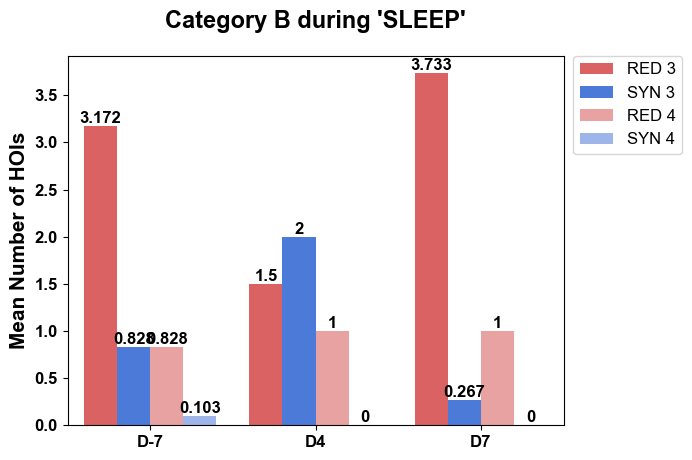

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


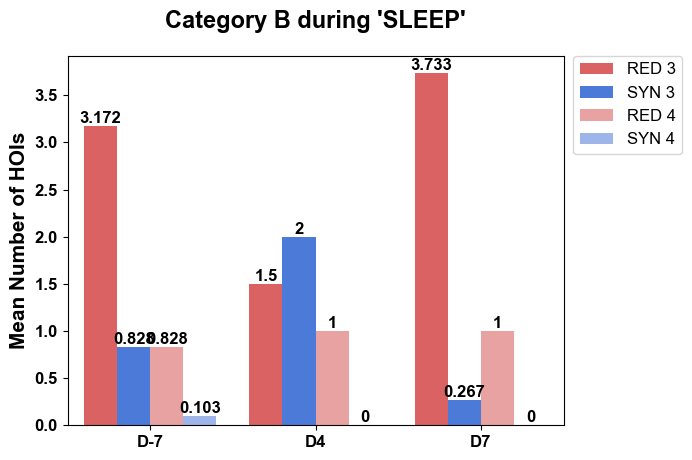

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


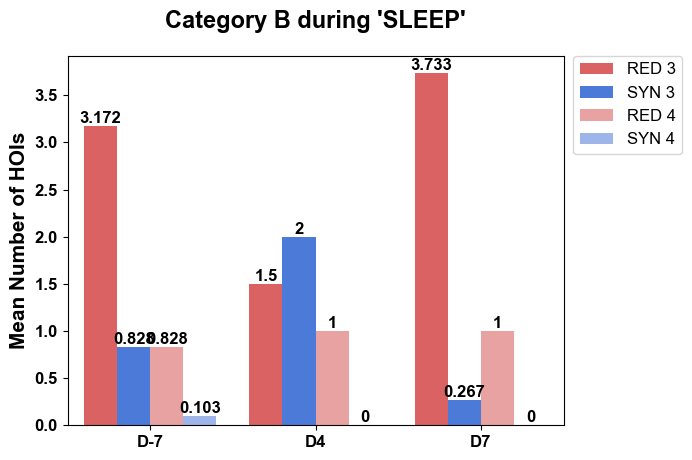

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


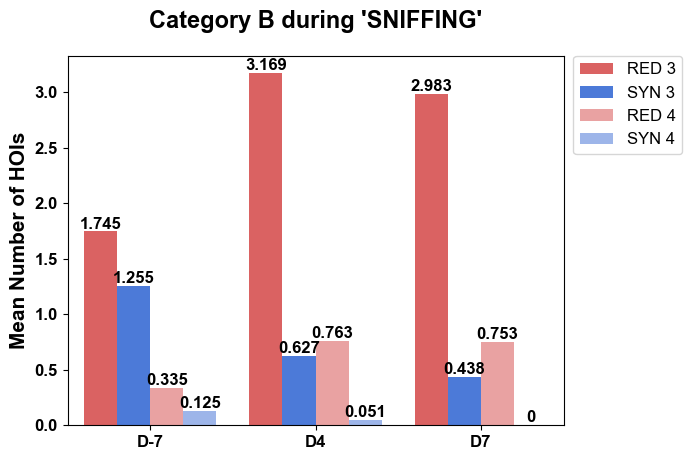

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


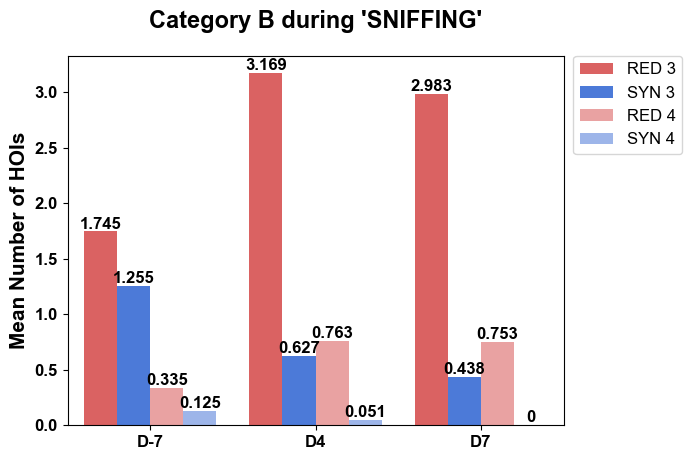

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


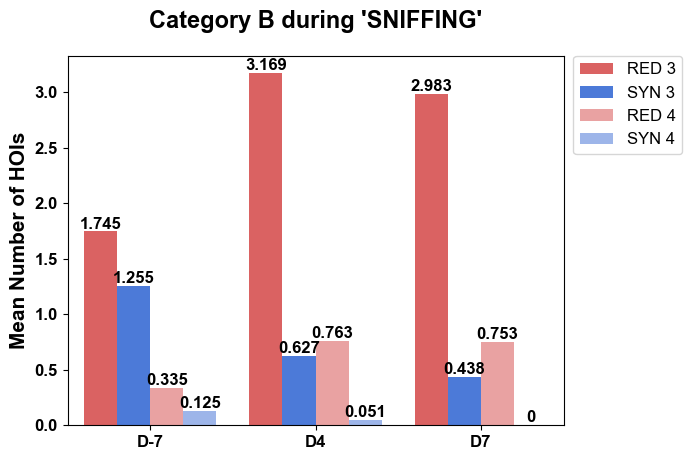

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


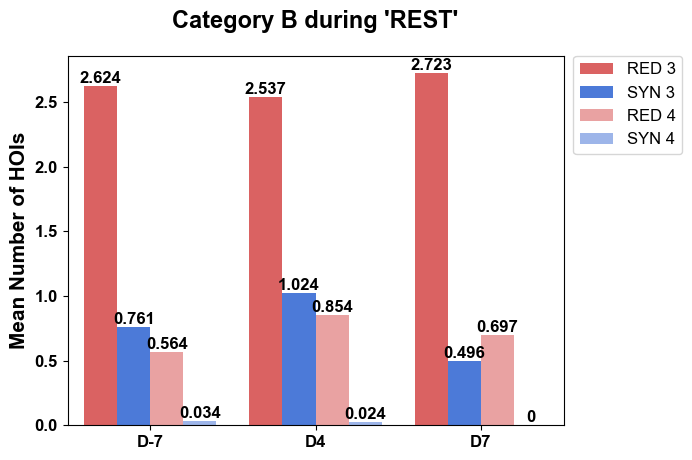

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


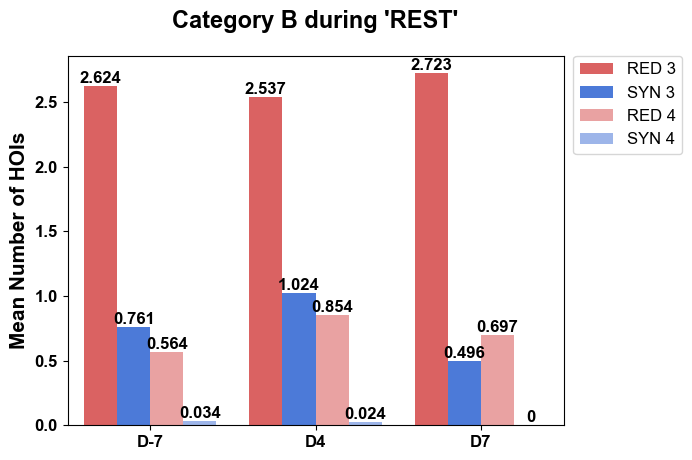

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


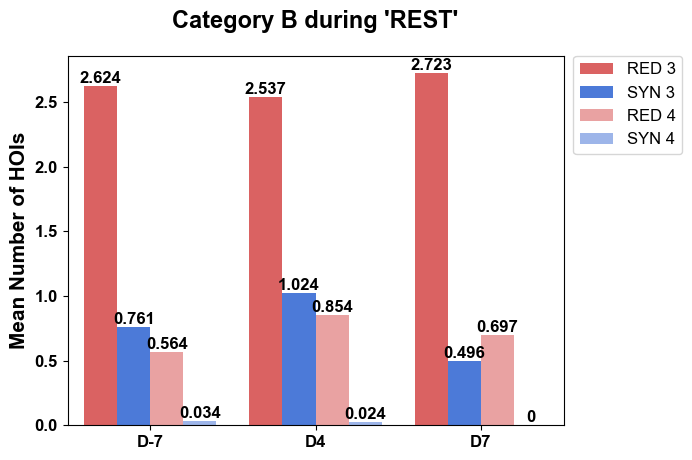

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


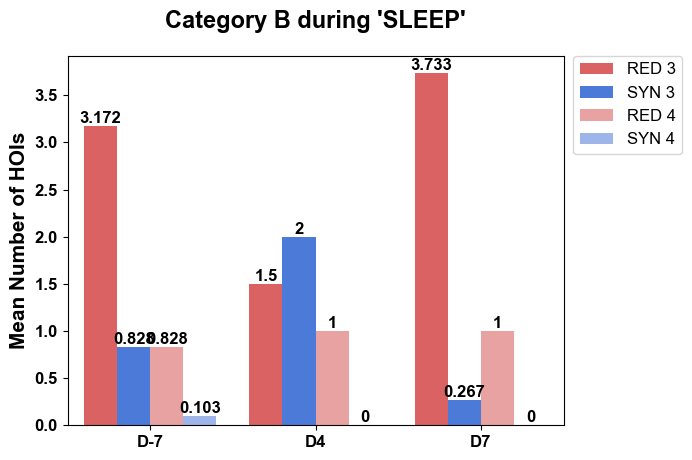

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


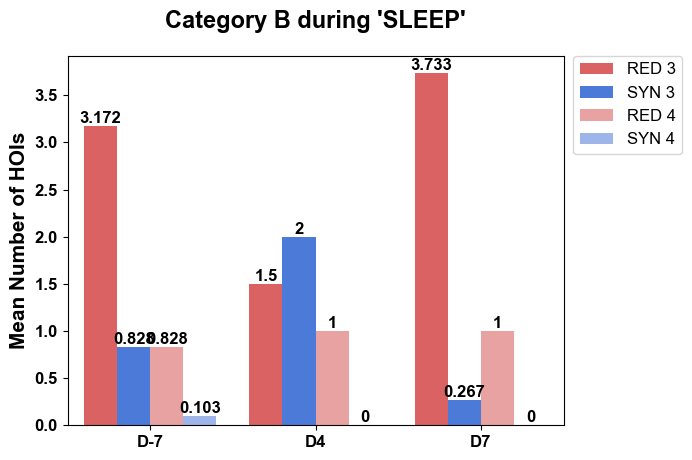

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


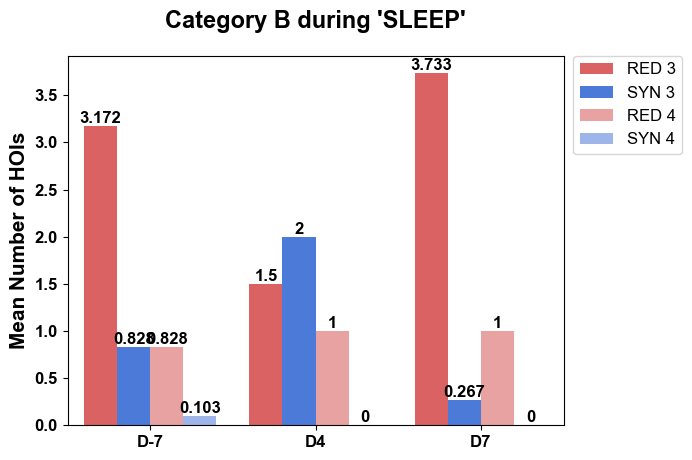

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


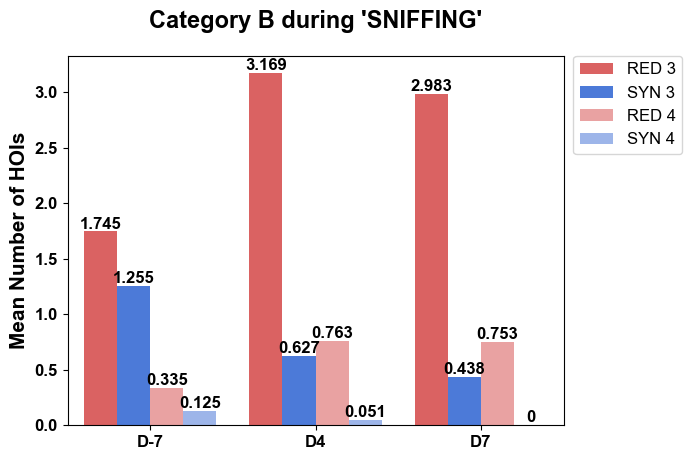

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


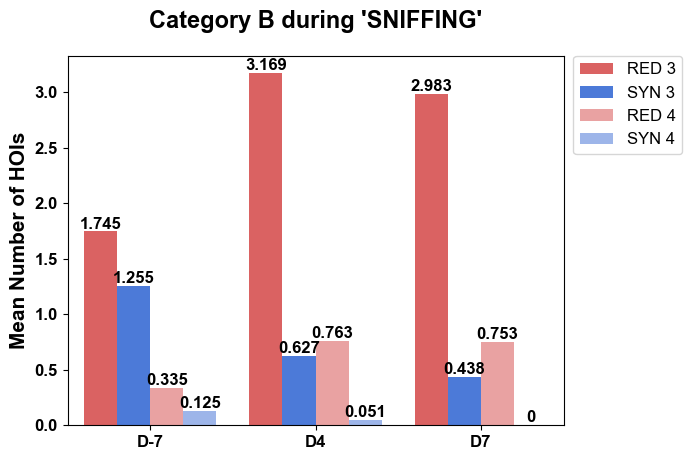

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


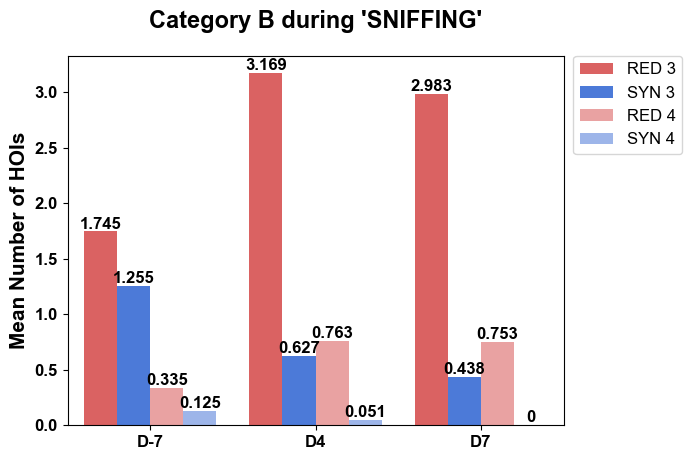

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


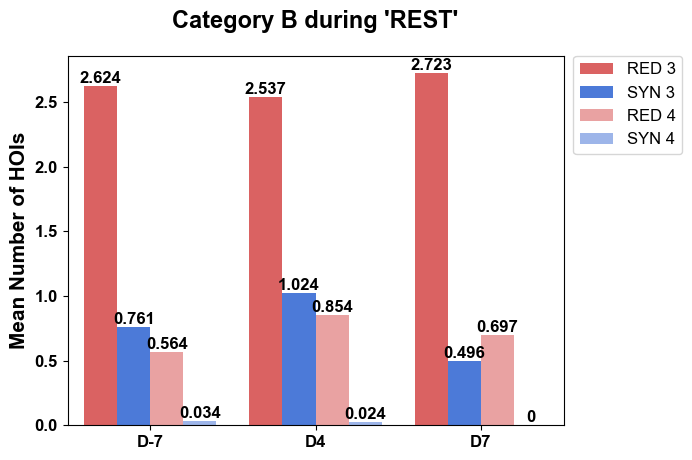

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


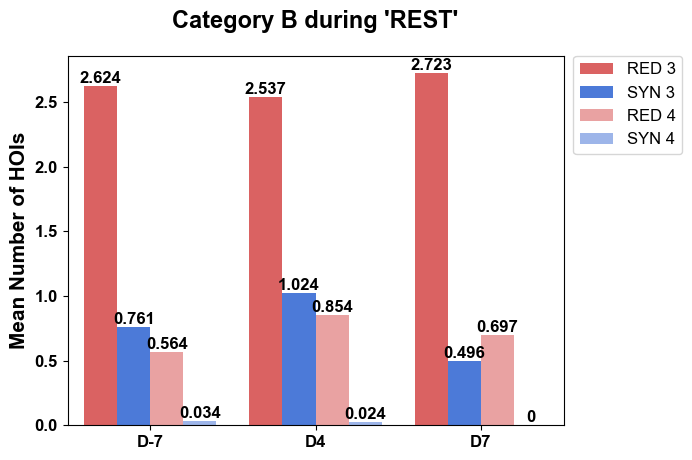

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


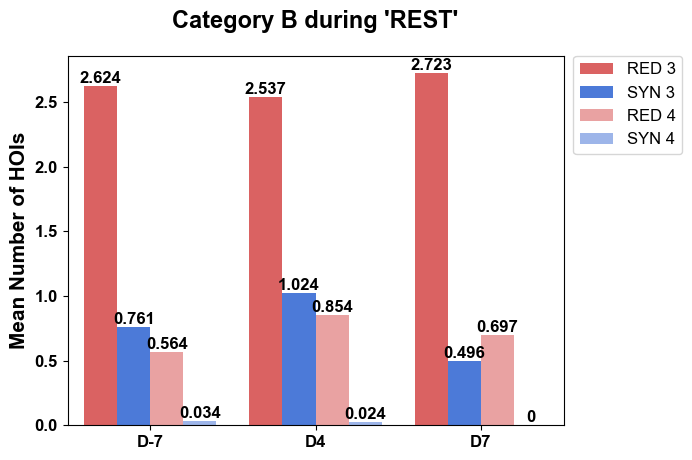

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


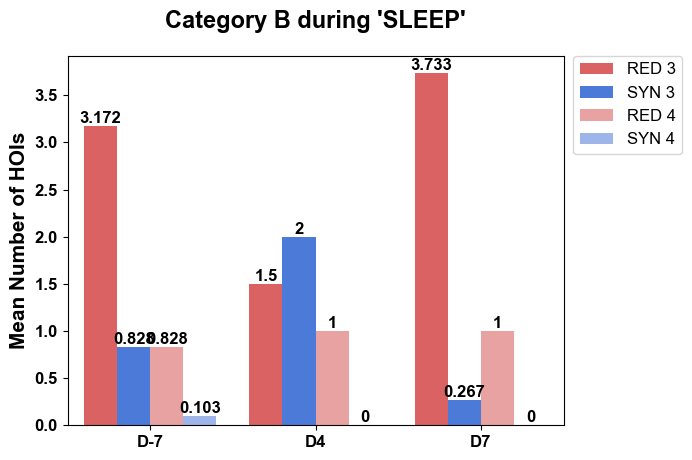

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


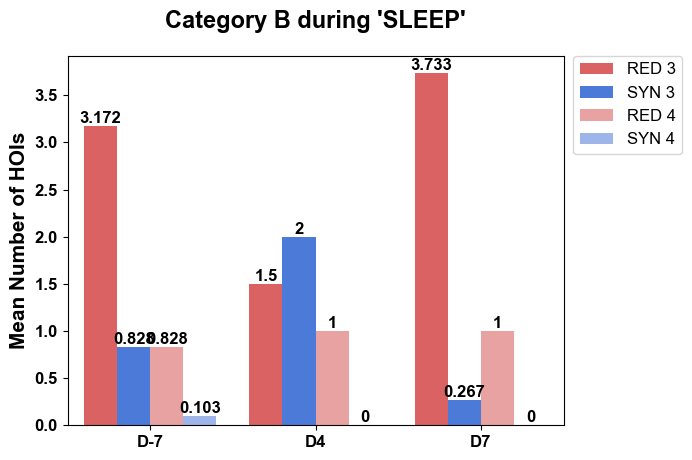

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


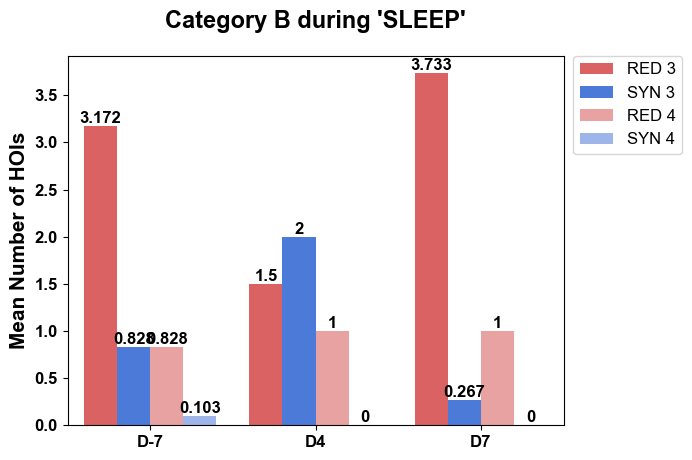

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


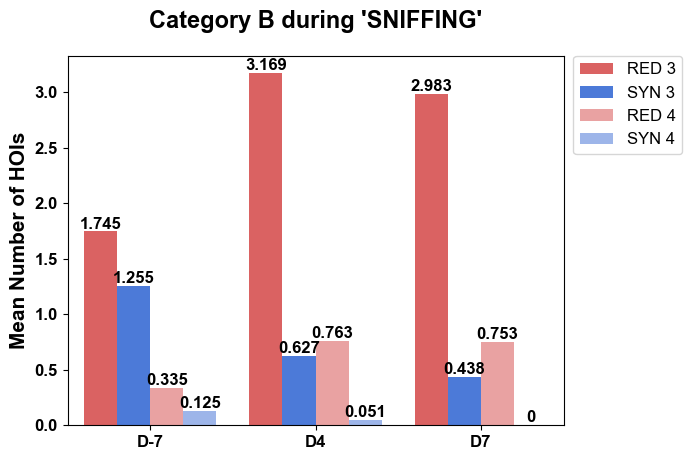

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


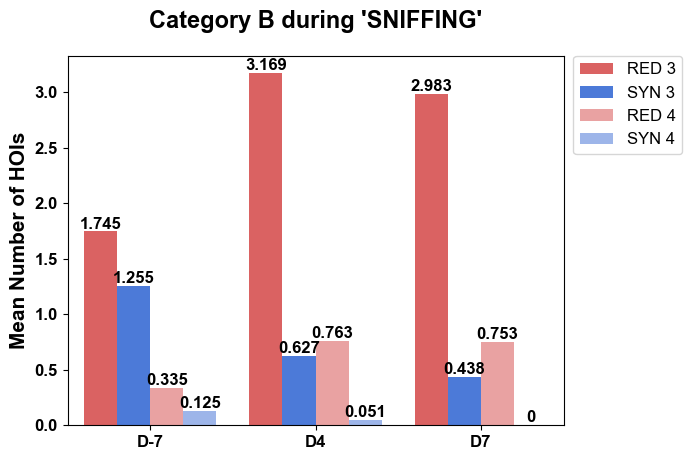

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


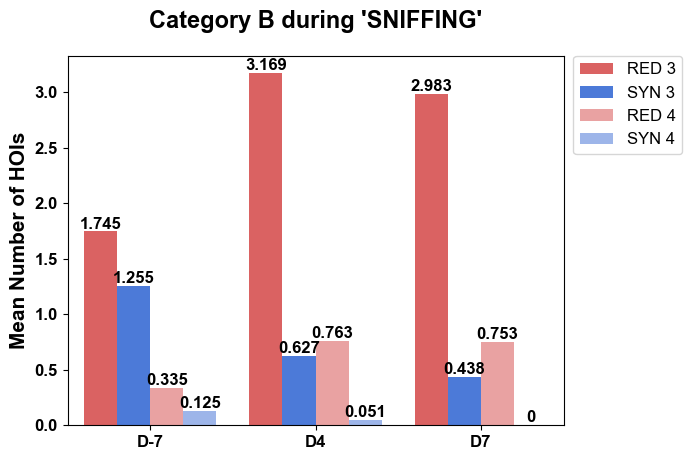

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


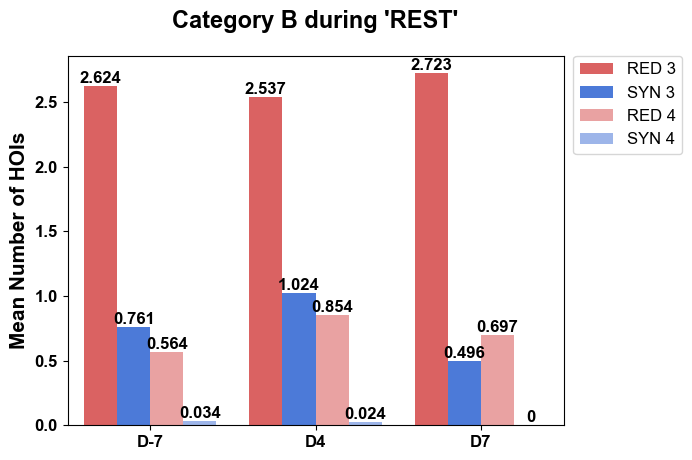

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


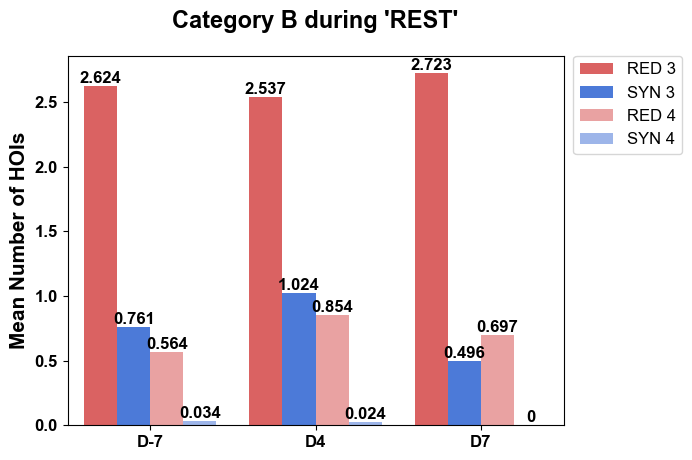

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


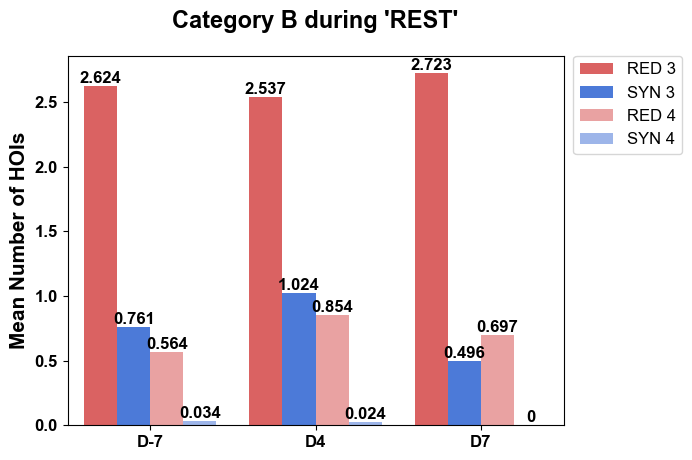

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


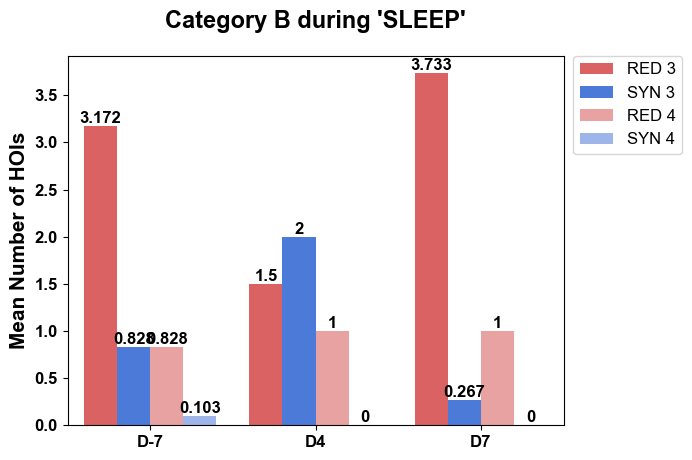

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


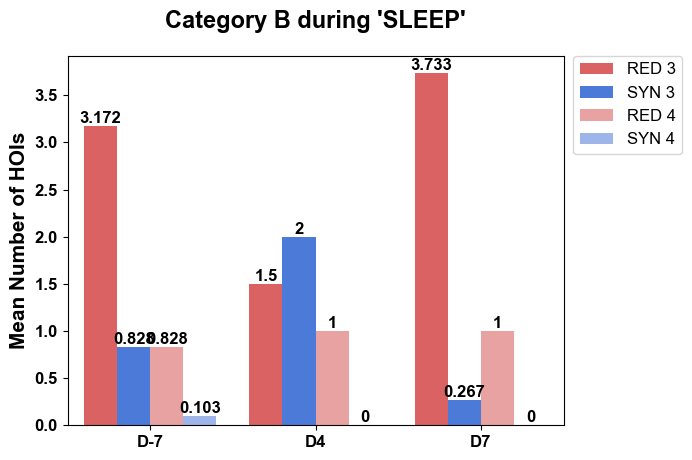

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


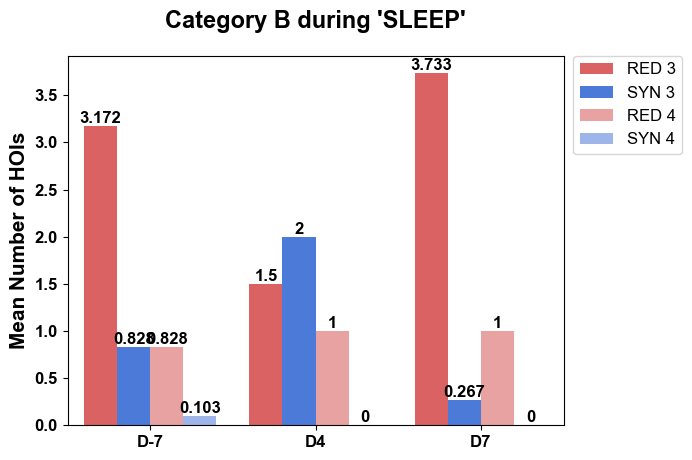

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


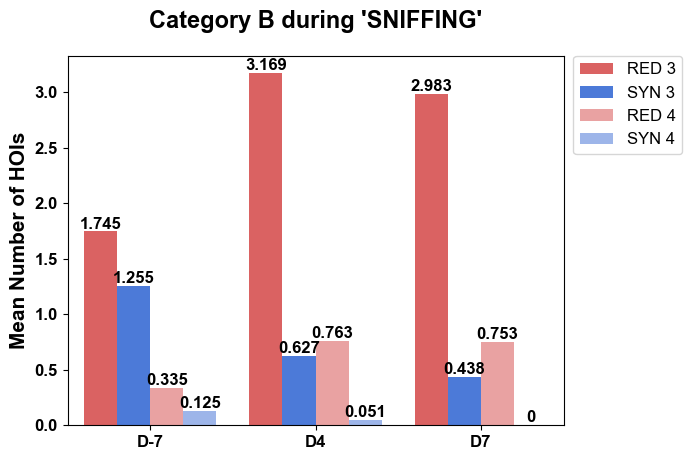

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


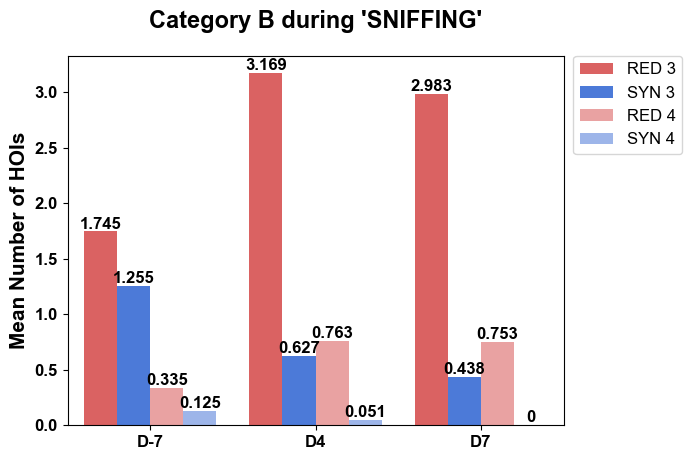

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


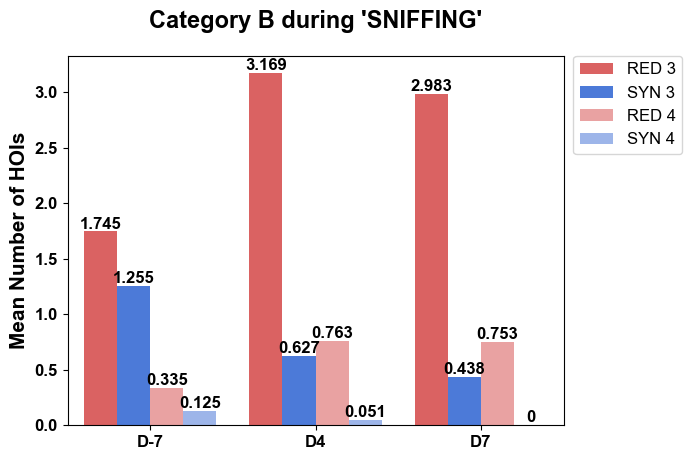

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


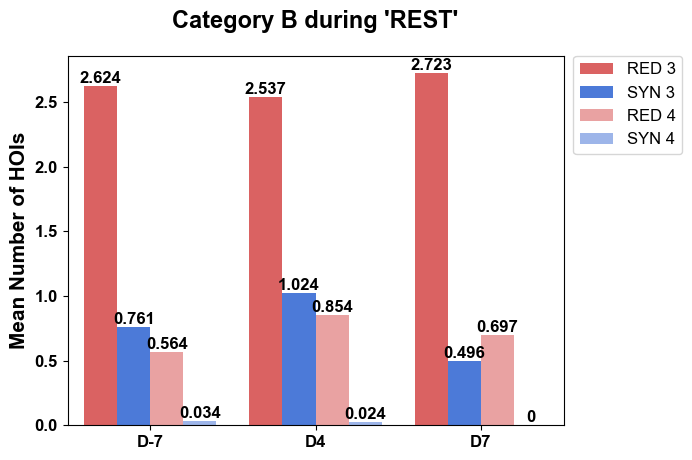

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


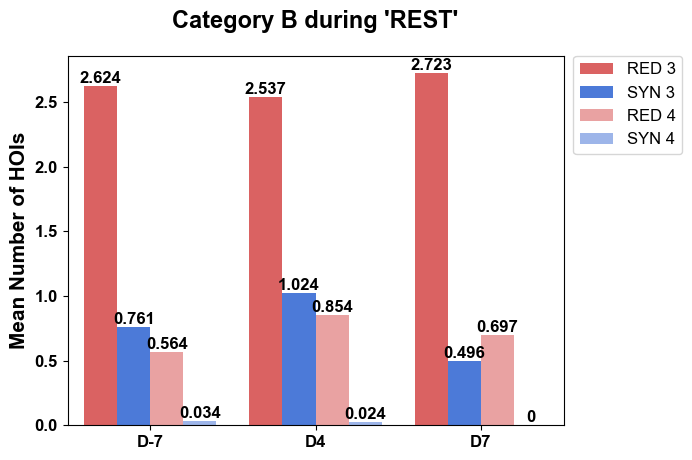

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


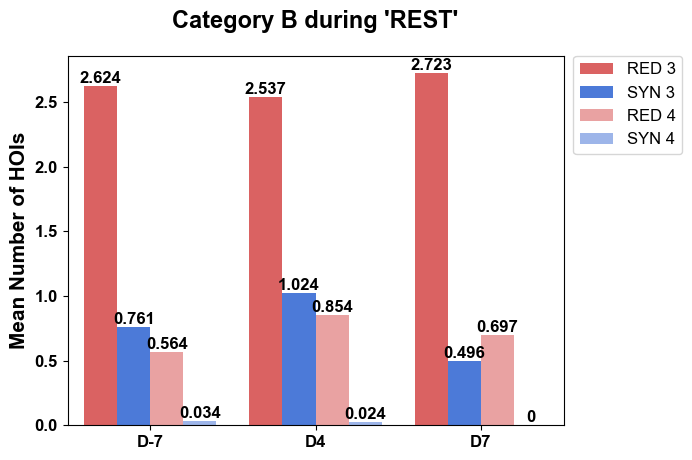

/tmp/ipykernel_46186/3167866213.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_plot=df_plot.drop(['Total # HOIs ','#epochs'],axis=1)
/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


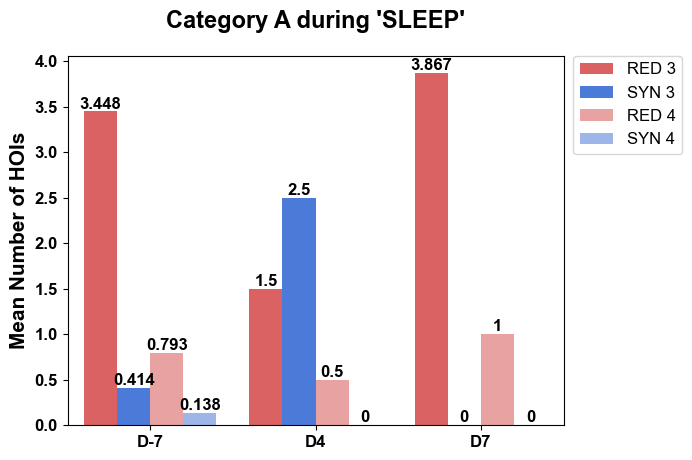

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


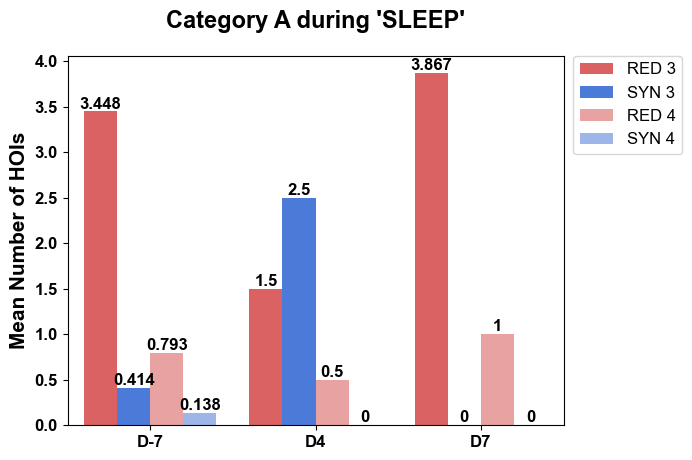

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


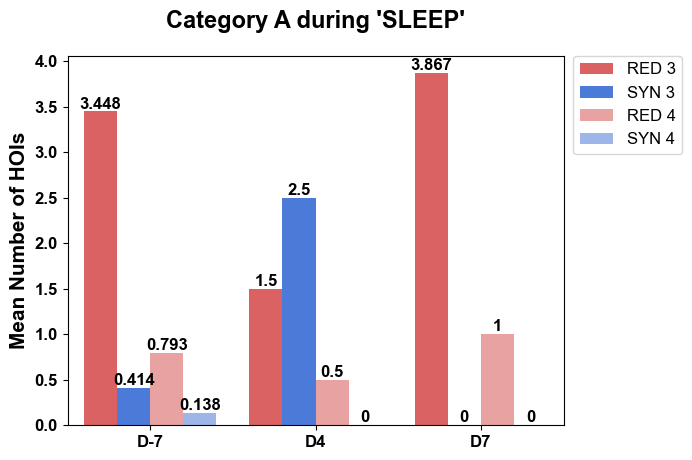

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


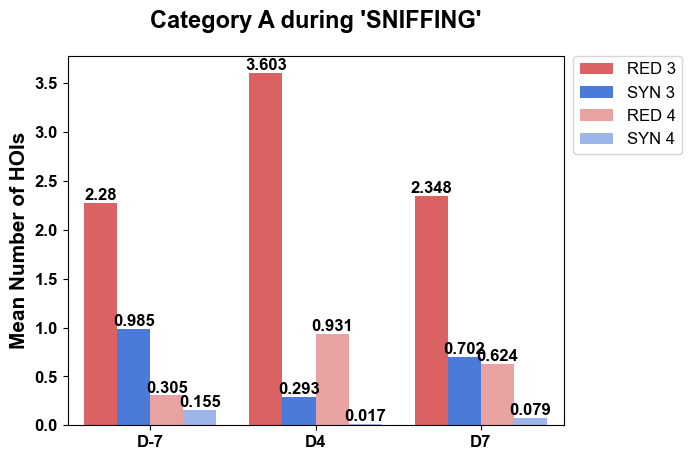

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


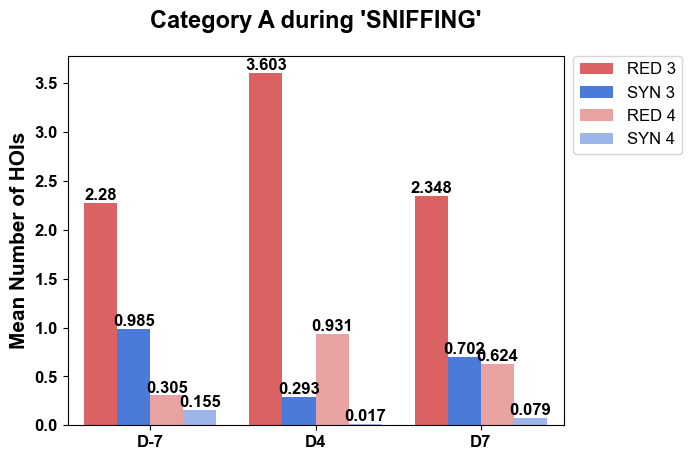

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


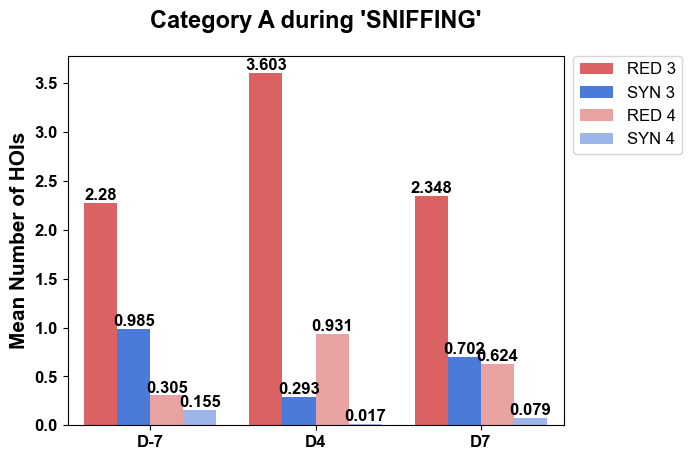

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


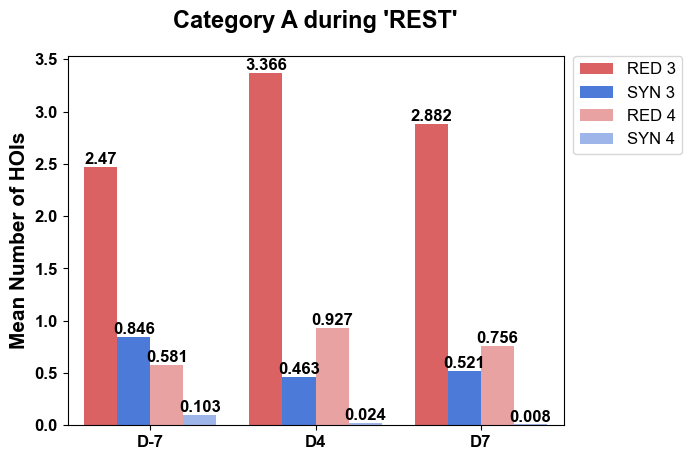

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


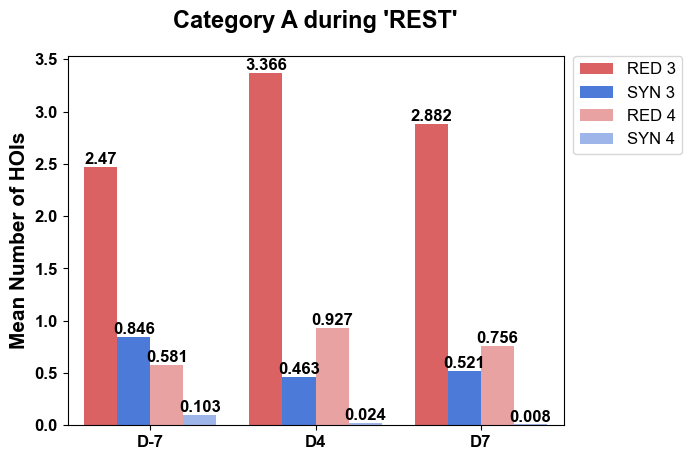

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


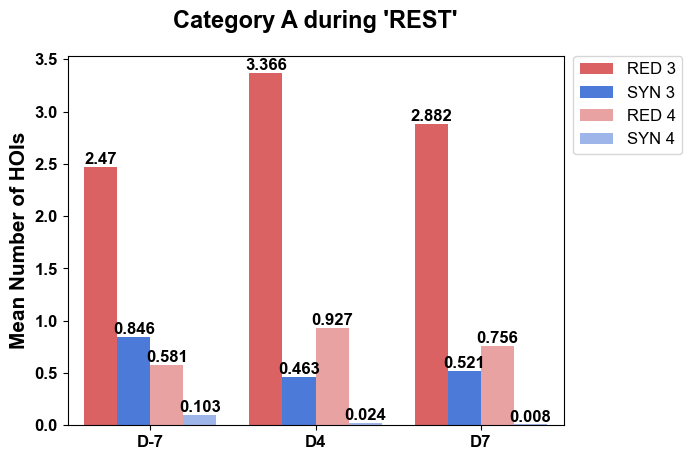

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


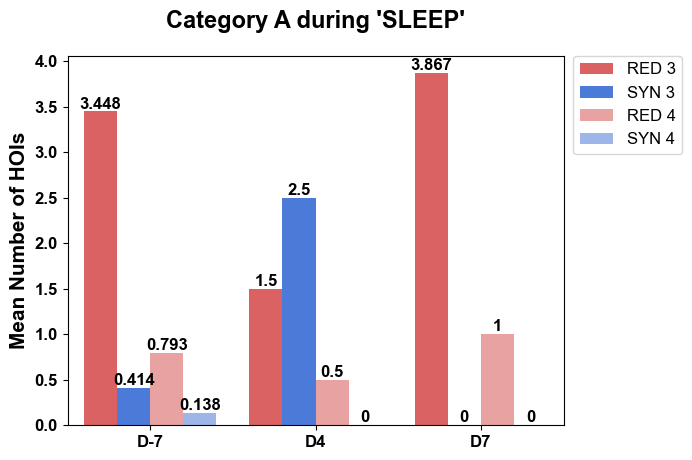

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


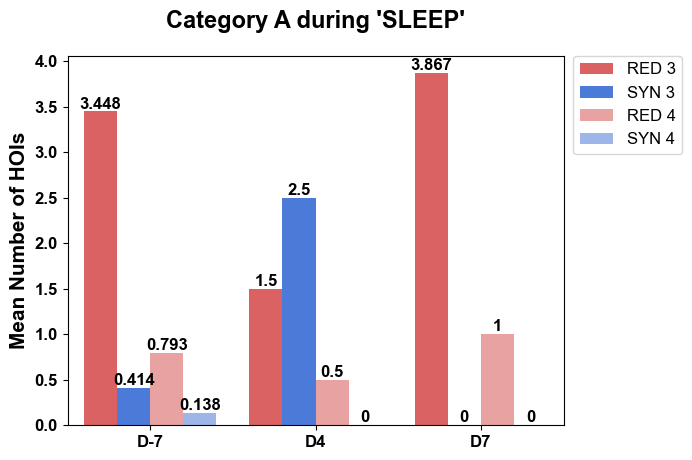

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


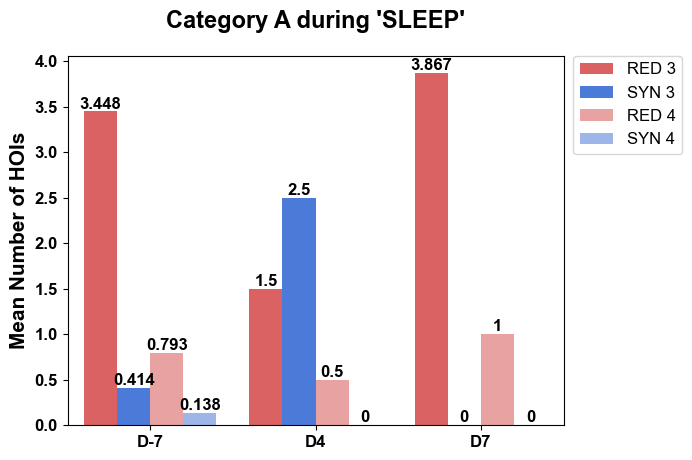

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


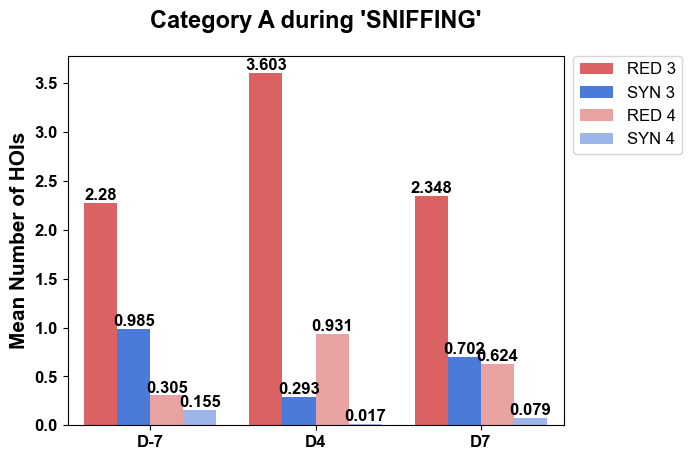

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


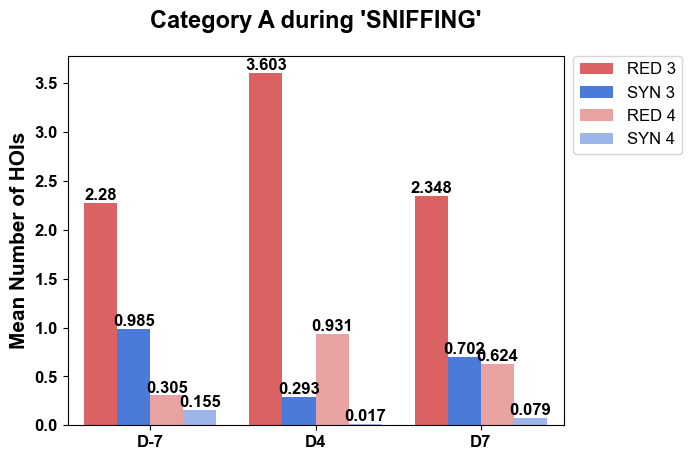

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


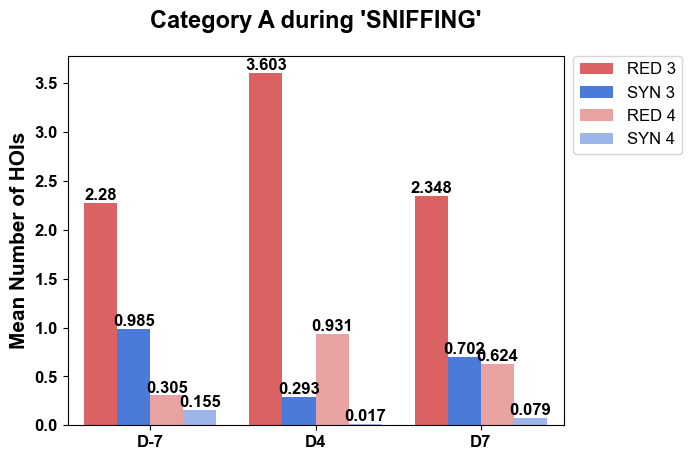

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


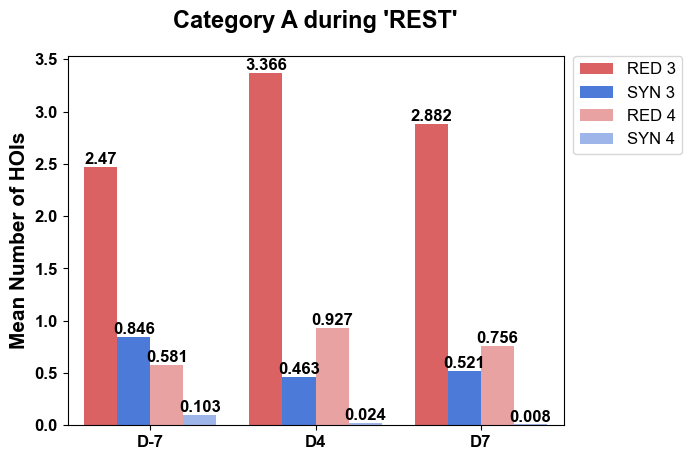

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


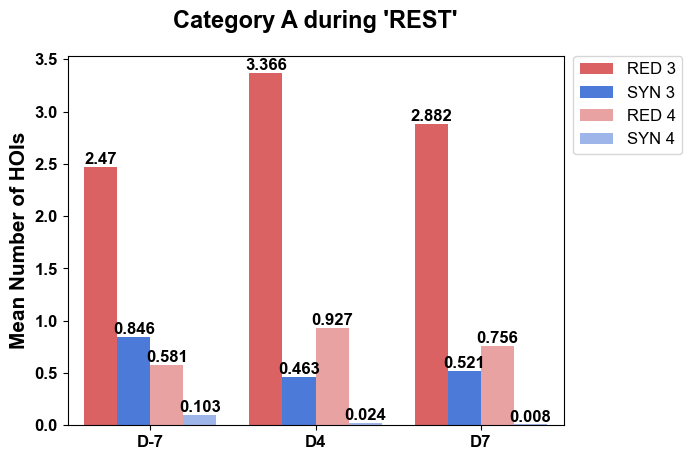

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


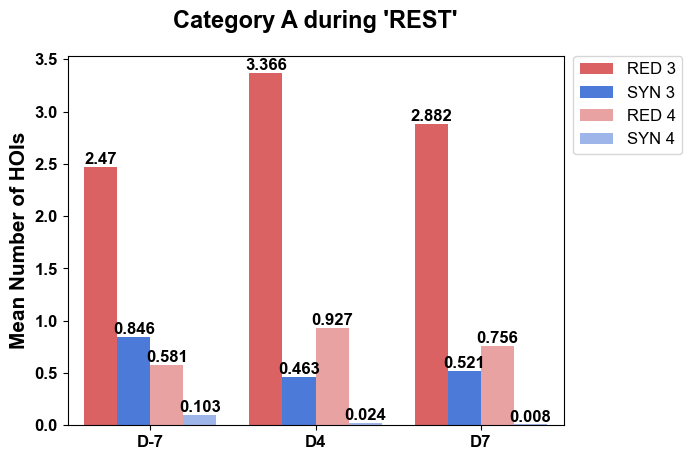

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


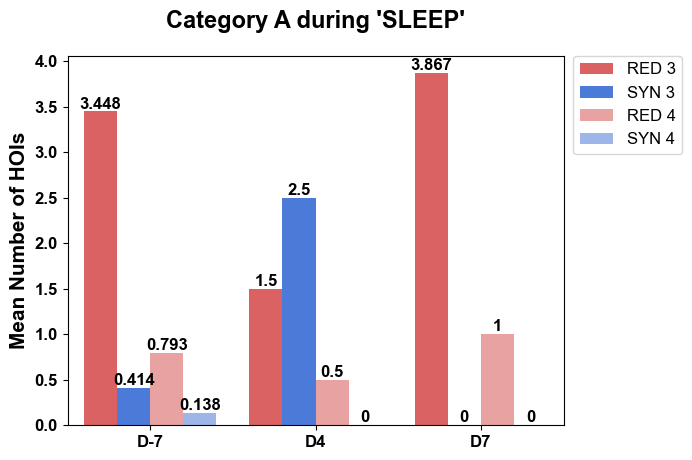

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


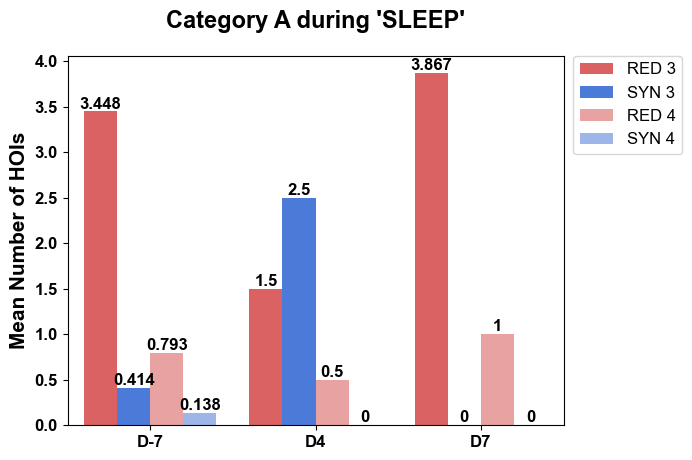

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


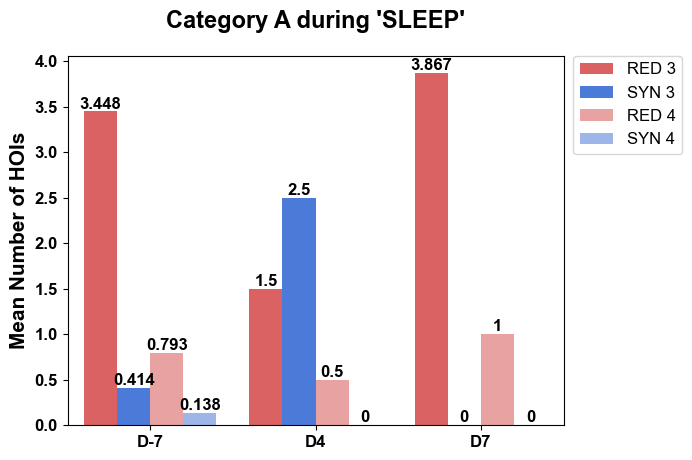

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


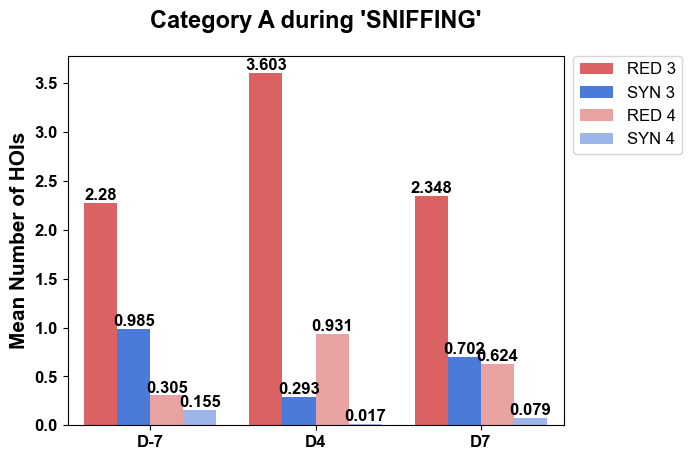

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


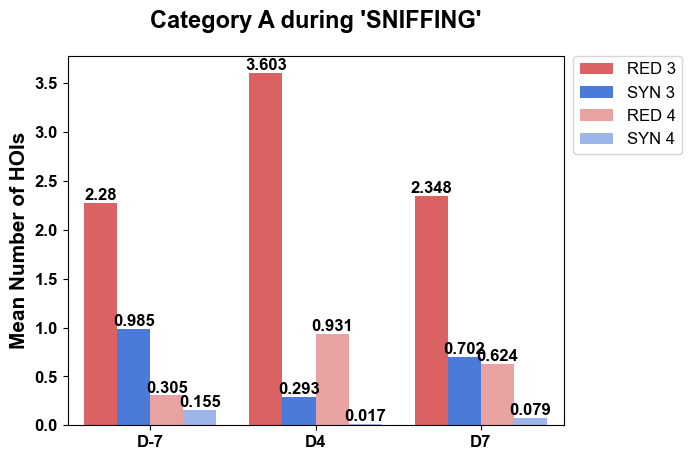

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


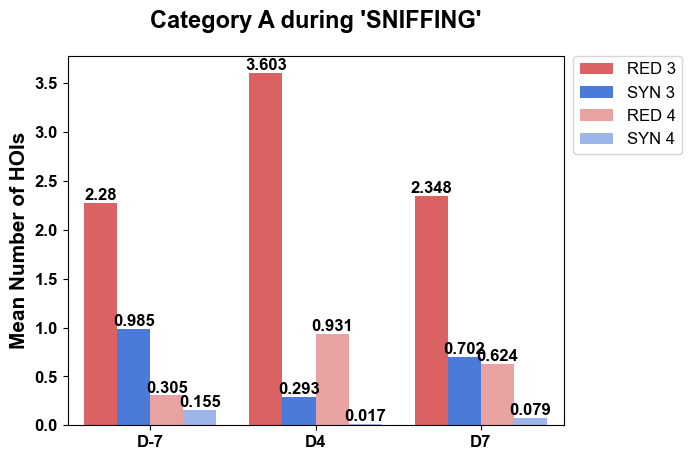

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


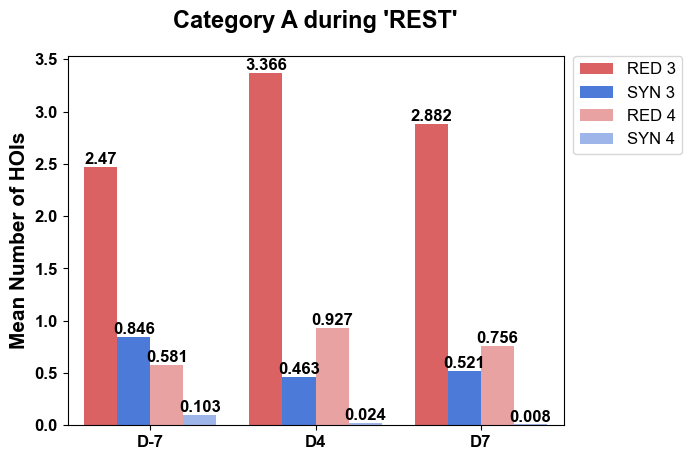

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


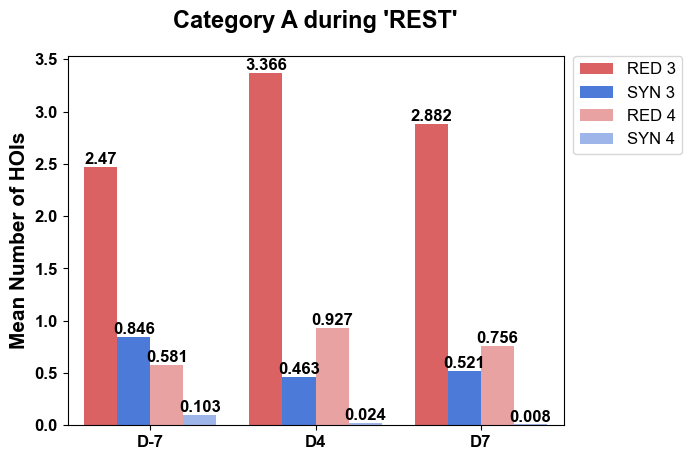

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


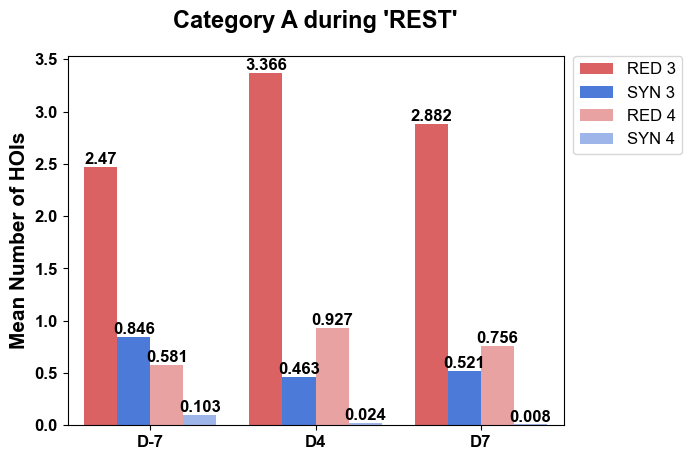

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


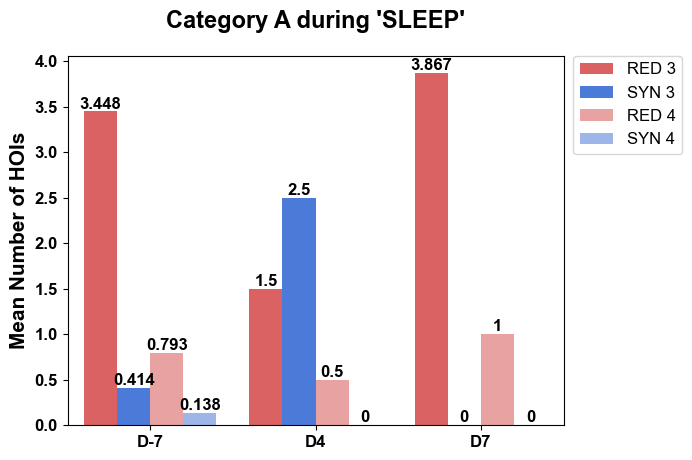

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


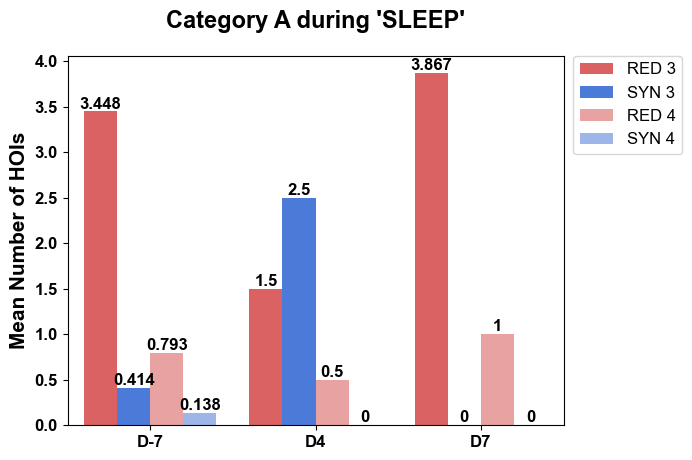

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


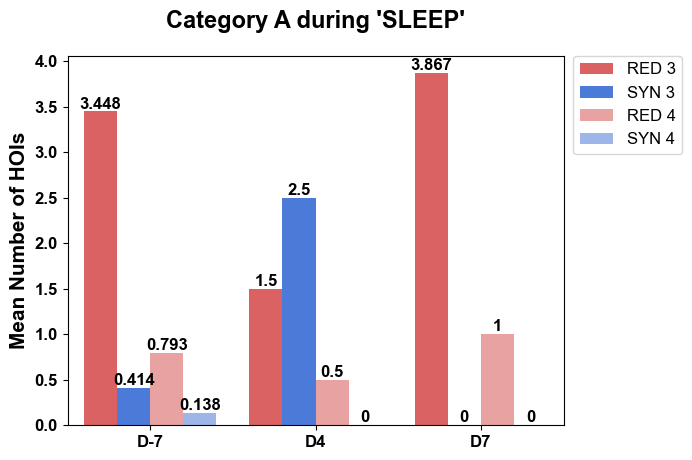

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


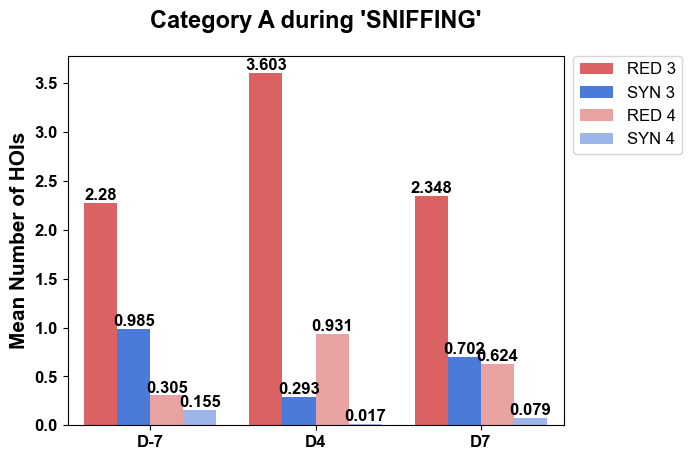

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


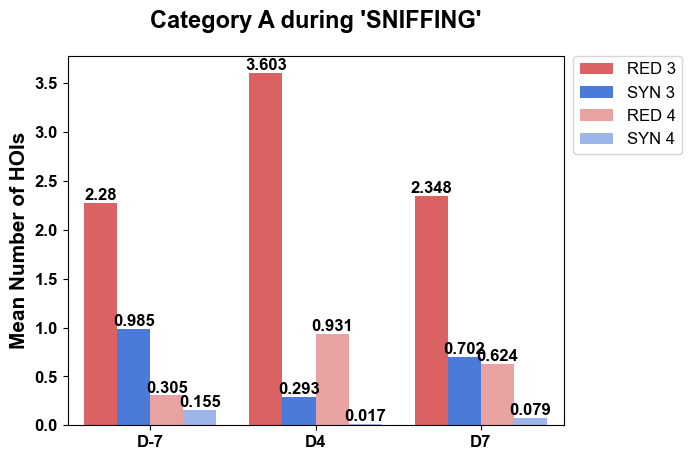

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


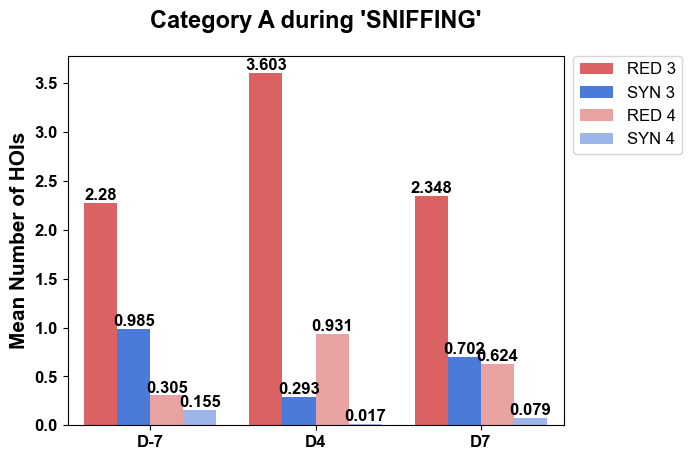

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


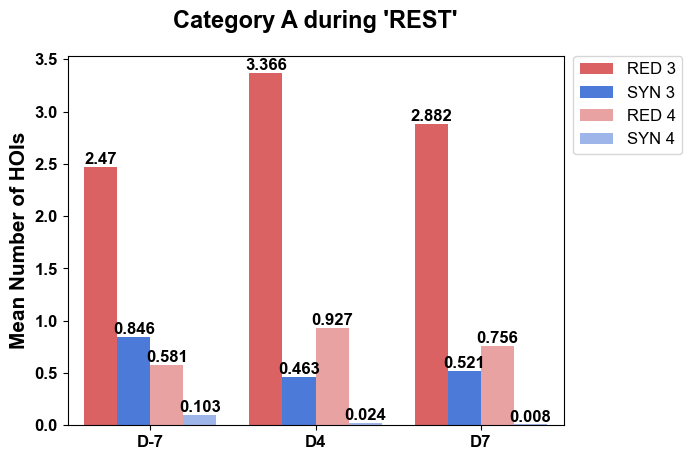

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


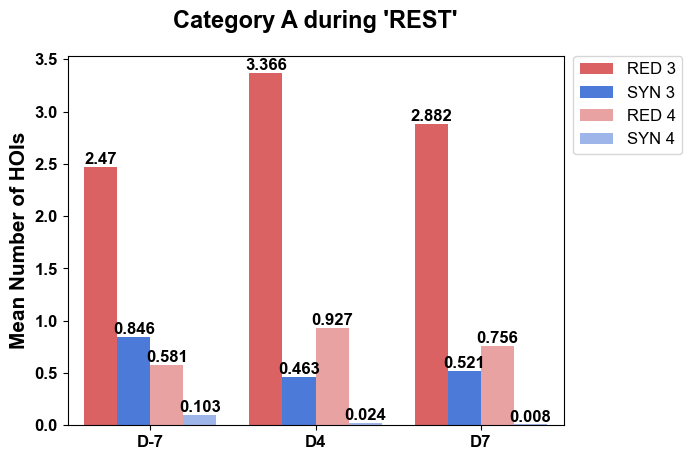

/tmp/ipykernel_46186/3167866213.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)


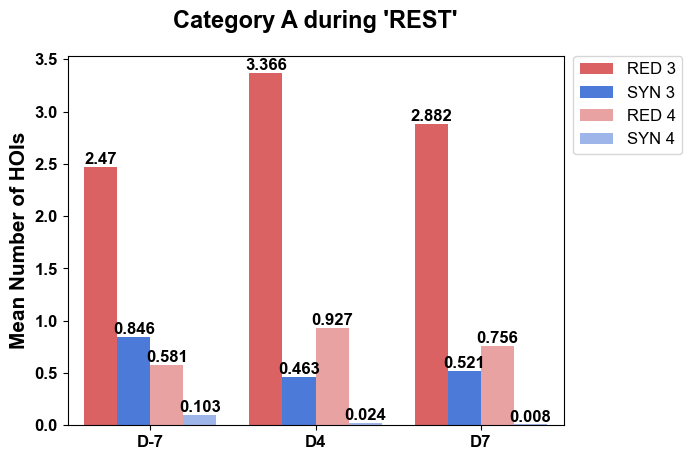

In [105]:
for group in [3,5]:
    df_plot=df_red_syn_interactions.query('timepoint == "D-7" | timepoint == "D4" | timepoint == "D7"')
    df_plot=df_plot.drop(['Total # HOIs ','#epochs'],axis=1)
    df_plot=df_plot.reset_index()
    df_plot=df_plot[df_plot.group==group]
    df_plot.columns=df_plot.columns.map(''.join)
    df_plot=pd.melt(df_plot, id_vars=['group','epoch','timepoint'], var_name='HOIs', value_name='Number of HOIs')
    df_plot=df_plot.rename(columns={"epoch":'Behavior'})
    df_plot['Behavior']=df_plot['Behavior'].map(rename_epoch)
    
    df_plot.loc[df_plot['HOIs']=='red3','HOIs']='RED 3'
    df_plot.loc[df_plot['HOIs']=='red4','HOIs']='RED 4'
    df_plot.loc[df_plot['HOIs']=='syn3','HOIs']='SYN 3'
    df_plot.loc[df_plot['HOIs']=='syn4','HOIs']='SYN 4'

    
    palette={'RED 3': get_palette_order('red')[3],
             'RED 4': get_palette_order('red')[4],
             'SYN 3': get_palette_order('syn')[3],
             'SYN 4': get_palette_order('syn')[4]
            }

    
    
    for behavior in ["'SNIFFING'", "'REST'", "'SLEEP'"]:
        g=sns.barplot(x='timepoint', y='Number of HOIs', data=df_plot[df_plot.Behavior==behavior],hue='HOIs',palette=palette)
        plt.title(f'{rename_group(group)} during {behavior}', fontsize=17, fontweight='bold', pad=20)
        
        plt.ylabel('Mean Number of HOIs', fontweight='bold', fontsize=15)
        plt.xlabel('', fontweight='bold', fontsize=15)
        
        g.set_xticklabels(g.get_xticklabels(), fontweight='bold', fontsize=12)
        g.set_yticklabels(g.get_yticklabels(), fontweight='bold', fontsize=12)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
        for i in range(len((g.containers))):
            g.bar_label(g.containers[i],fontweight='bold',fontsize=12)
        # plt.xticks(rotation=45)
        plt.savefig(SAVE_PATH_FIG/f'group {group}'/f'table2{behavior}',dpi=300,bbox_inches='tight')
        plt.show()

NameError: name 'df_red_syn_interactions' is not defined

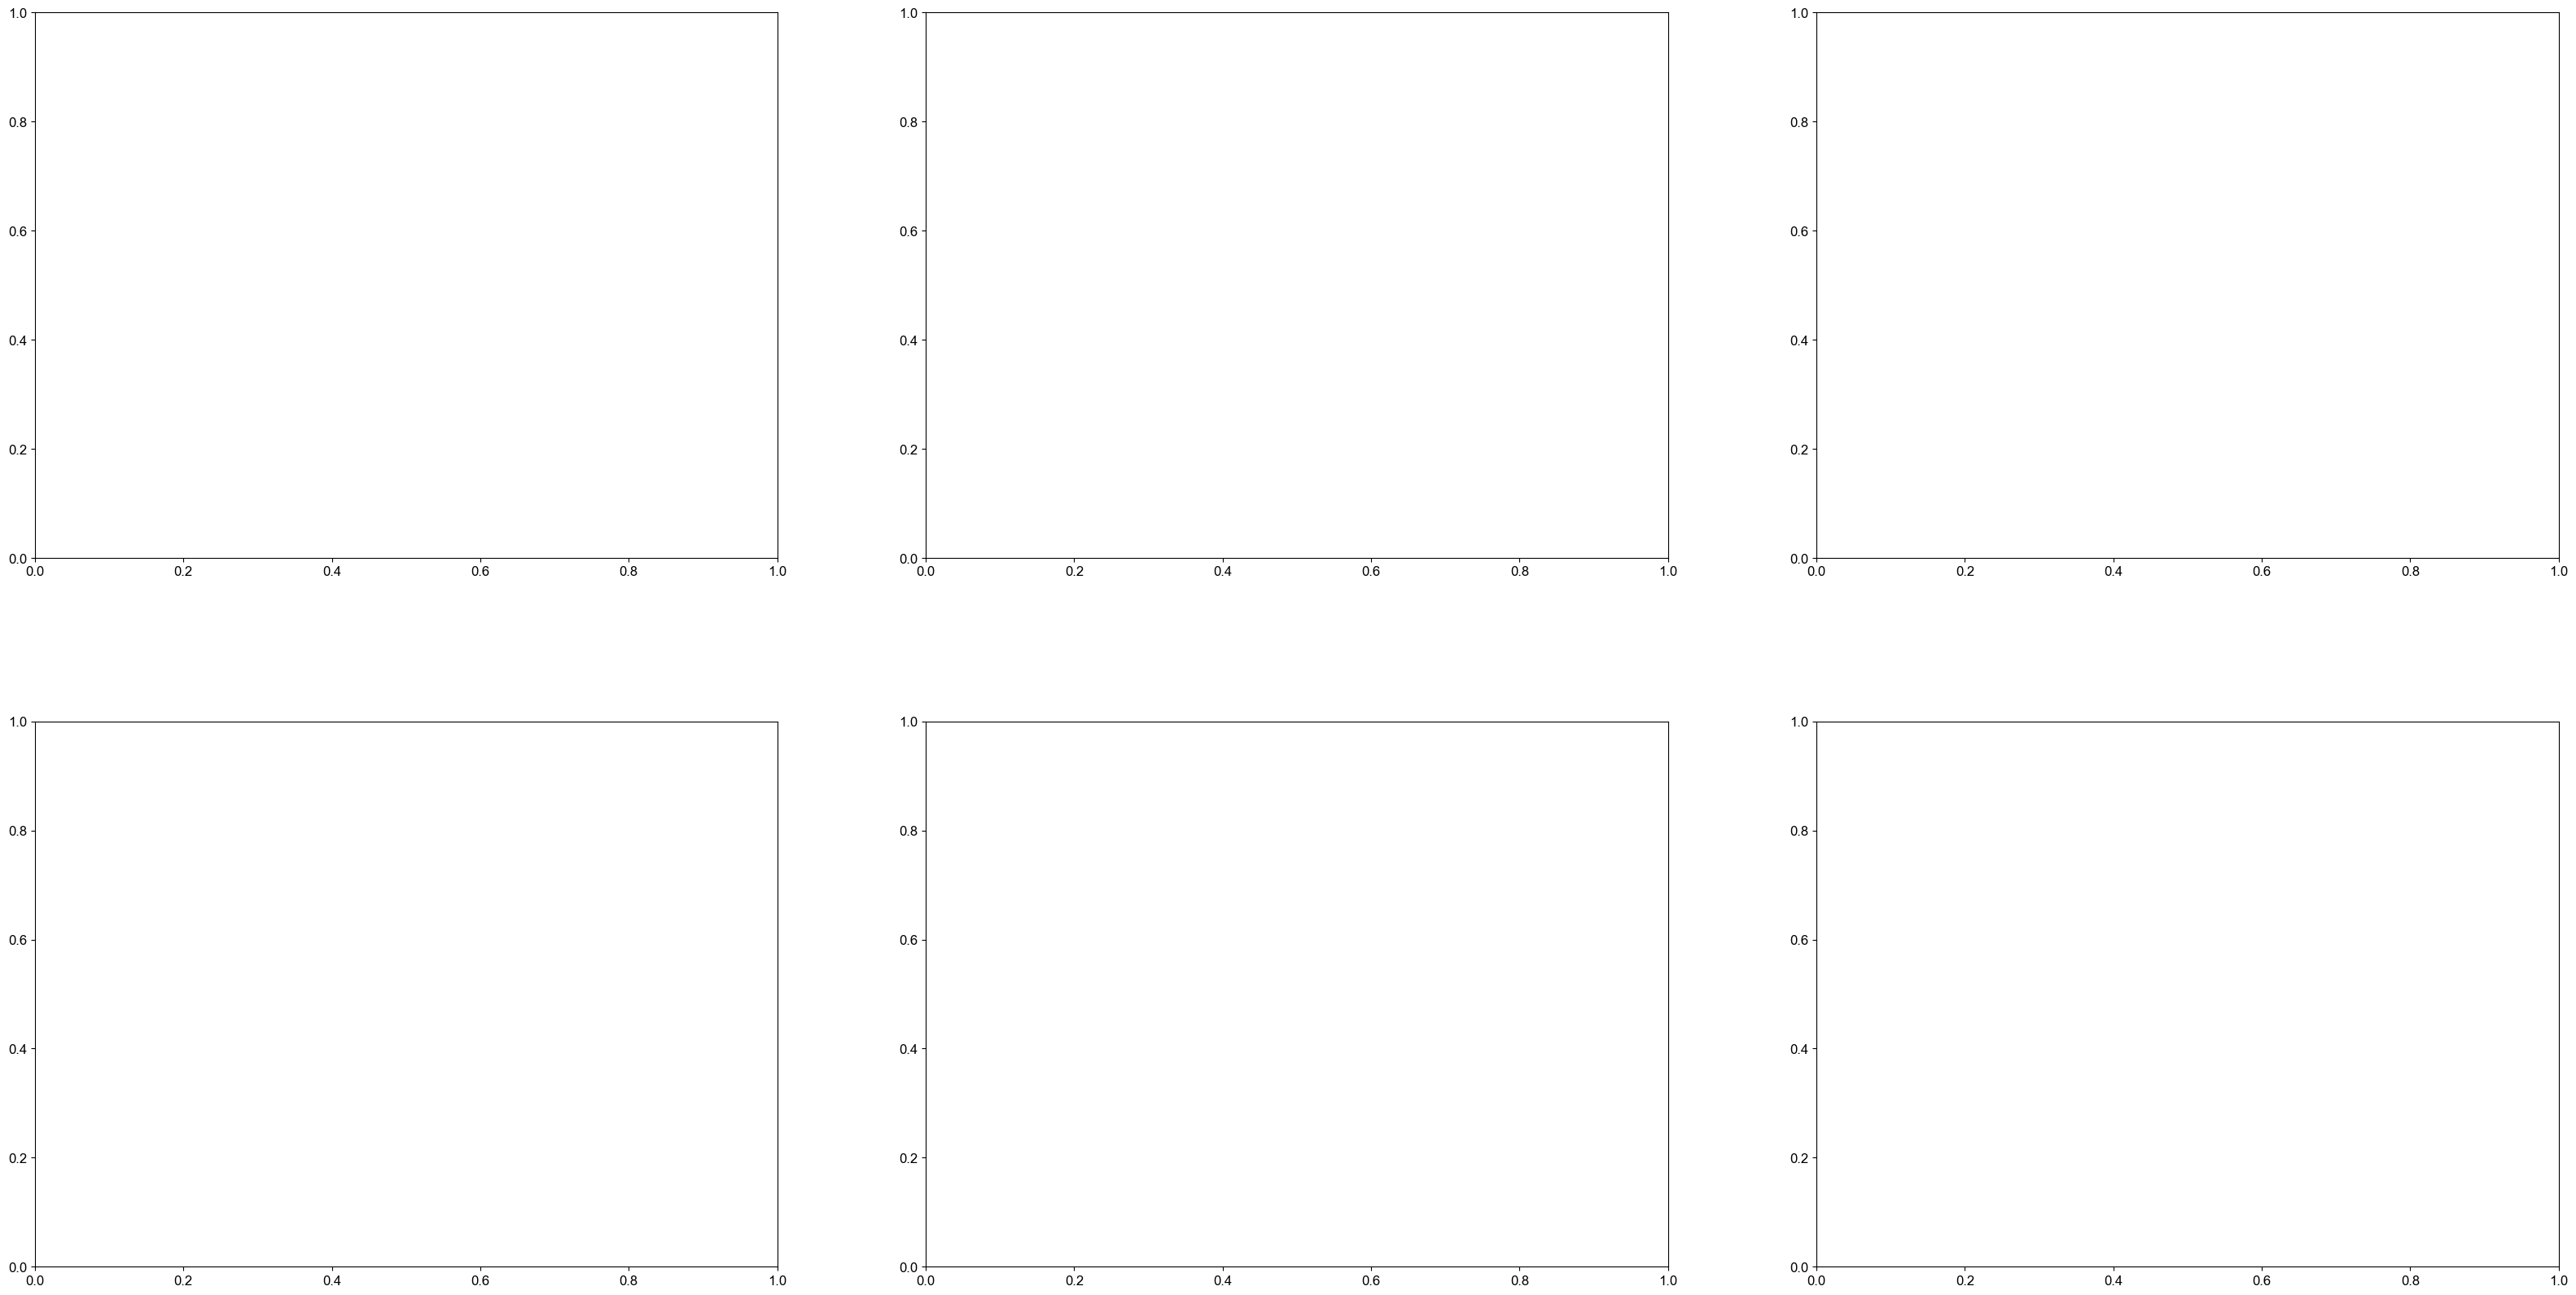

In [61]:

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(40, 20))
axes_number_i=0
axes_number_j=0


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.2)  # Adjust these values as needed


for group in [5,3]:
    df_plot=df_red_syn_interactions.query('timepoint == "D-7" | timepoint == "D4" | timepoint == "D7"')
    df_plot=df_plot.drop(['Total # HOIs ','#epochs'],axis=1)
    df_plot=df_plot.reset_index()
    df_plot=df_plot[df_plot.group==group]
    df_plot.columns=df_plot.columns.map(''.join)
    df_plot=pd.melt(df_plot, id_vars=['group','epoch','timepoint'], var_name='HOIs', value_name='Number of HOIs')
    df_plot=df_plot.rename(columns={"epoch":'Behavior'})
    df_plot['Behavior']=df_plot['Behavior'].map(rename_epoch)
    
    df_plot.loc[df_plot['HOIs']=='red3','HOIs']='RED 3'
    df_plot.loc[df_plot['HOIs']=='red4','HOIs']='RED 4'
    df_plot.loc[df_plot['HOIs']=='syn3','HOIs']='SYN 3'
    df_plot.loc[df_plot['HOIs']=='syn4','HOIs']='SYN 4'

    
    palette={'RED 3': get_palette_order('red')[3],
             'RED 4': get_palette_order('red')[4],
             'SYN 3': get_palette_order('syn')[3],
             'SYN 4': get_palette_order('syn')[4]
            }

    
    
    for behavior in ["'SNIFFING'", "'REST'", "'SLEEP'"]:
        sns.barplot(x='timepoint', y='Number of HOIs', data=df_plot[df_plot.Behavior==behavior],hue='HOIs',palette=palette,ax=axs[axes_number_i,axes_number_j])
        axs[axes_number_i,axes_number_j].set_title(f'{behavior}', fontsize=30, fontweight='bold', pad=20)
        
        axs[axes_number_i,axes_number_j].set_ylabel('Mean Number of HOIs', fontweight='bold', fontsize=27)
        axs[axes_number_i,axes_number_j].set_xlabel('Timepoints', fontweight='bold', fontsize=27)
        
        axs[axes_number_i,axes_number_j].set_xticklabels(g.get_xticklabels(), fontsize=25)
        axs[axes_number_i,axes_number_j].set_yticklabels(g.get_yticklabels(), fontsize=25)
        axs[axes_number_i,axes_number_j].set_ylim((0,4))
        # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
        # for i in range(len((axs[axes_number_i, axes_number_j].containers))):
        #     axs[axes_number_i, axes_number_j].bar_label(axs[axes_number_i,axes_number_j].containers[i],fontweight='bold',fontsize=25)
        axs[axes_number_i, axes_number_j].legend_.remove()

        axes_number_j+=1
    axes_number_j=0
    axes_number_i+=1
        # plt.xticks(rotation=45)
        # plt.savefig(SAVE_PATH_FIG/f'group {group}'/f'table2{behavior}',dpi=300,bbox_inches='tight')
export_legend(axs[0,0].legend(),SAVE_PATH_FIG/f'Figure3_legend.svg')
plt.savefig(SAVE_PATH_FIG/f'Figure3_table2.svg',dpi=600,bbox_inches='tight')
plt.show()

# Corr RED SYN

/tmp/ipykernel_77107/3764959382.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[n//3,n%3].set_xticklabels(axes[n//3,n%3].get_xticklabels(), fontweight='bold', fontsize=12)
/tmp/ipykernel_77107/3764959382.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[n//3,n%3].set_yticklabels(axes[n//3,n%3].get_yticklabels(), fontweight='bold', fontsize=12)
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_77107/3764959382.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[n//3,n%3].set_xticklabels(axes[n//3,n%3].get_xticklabels(), fontweight='bold', fontsize=12)
/tmp/ipykernel_77107/3764959382.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[n//3,n%3].set

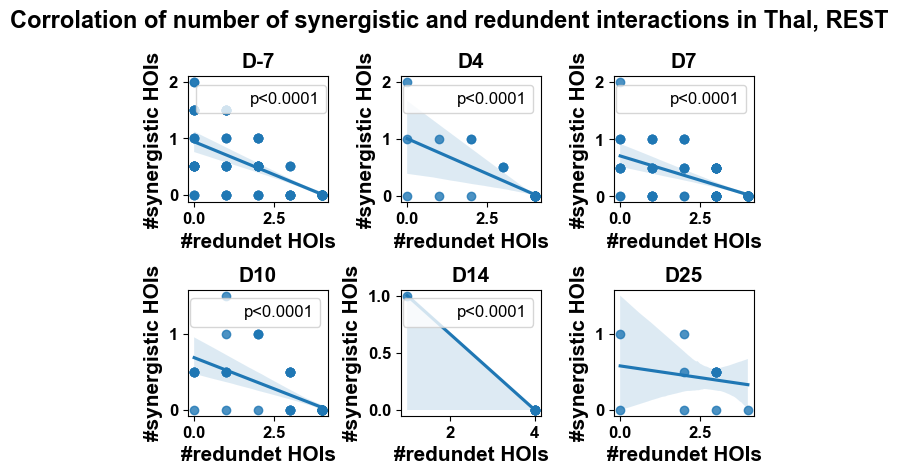

In [79]:
for group_num in [3,5]:
    df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
    df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
    
    for epoch in df_summary_ineractions_red.epoch.unique():
#         plt.close()
        df_epoch_red=df_summary_ineractions_red[df_summary_ineractions_red.epoch==epoch]
        df_epoch_syn=df_summary_ineractions_syn[df_summary_ineractions_syn.epoch==epoch]
        df_plot_red=df_epoch_red.drop(['epoch','rat','session','#session'],axis=1)
        df_plot_syn=df_epoch_syn.drop(['epoch','rat','session','#session'],axis=1)
        timepoints = sort_date(all_timepoints,df_plot_red.timepoint.unique().tolist())
        for region in df_plot_red.columns[1:]:
            plt.close()
            fig, axes = plt.subplots(2, 3)
            # for _, ax in np.ndenumerate(axes):
            #     ax.axis('off')
            fig.suptitle(f'Corrolation of number of synergistic and redundent interactions in {region}, {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
            for n,t1 in enumerate(timepoints):
                if df_plot_red[df_plot_red.timepoint==t1][region].shape[0]==0:
                    continue
                p=scipy.stats.pearsonr(df_plot_red[df_plot_red.timepoint==t1][region].values,df_plot_syn[df_plot_syn.timepoint==t1][region].values)[1]
                if p< 0.05:
#                     axes[n//3,n%3].text(0.5, 2, "Who's Hungy?",color='purple')
                    if p<0.0001:
                        label='p<0.0001'
                    elif p<0.001:
                        label='p<0.001'
                    elif p<0.01:
                        label='p<0.01'
                    else:
                        label='p<0.05'
                    empty_patch = mpatches.Patch(color='none', label=label) 
                    axes[n//3,n%3].legend(handles=[empty_patch],fontsize=12)
                sns.regplot(x=df_plot_red[df_plot_red.timepoint==t1][region].values,y=df_plot_syn[df_plot_syn.timepoint==t1][region].values,ax=axes[n//3,n%3])
                axes[n//3,n%3].set_title(t1, fontweight='bold', fontsize=15)
                axes[n//3,n%3].set_xlabel('#redundet HOIs',fontweight='bold', fontsize=15)
                axes[n//3,n%3].set_ylabel('#synergistic HOIs',fontweight='bold', fontsize=15)
                axes[n//3,n%3].set_xticklabels(axes[n//3,n%3].get_xticklabels(), fontweight='bold', fontsize=12)
                axes[n//3,n%3].set_yticklabels(axes[n//3,n%3].get_yticklabels(), fontweight='bold', fontsize=12)
            # Iterate over all axes and remove the empty ones
            for ax in axes.flat:
                if not ax.has_data():
                    fig.delaxes(ax)
            plt.tight_layout()
            plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'corr_red_syn_{region}_{epoch}.png',dpi=600,bbox_inches='tight')


/tmp/ipykernel_144242/2157565865.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[n//3,n%3].set_xticklabels(axes[n//3,n%3].get_xticklabels(), fontweight='bold', fontsize=12)
/tmp/ipykernel_144242/2157565865.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[n//3,n%3].set_yticklabels(axes[n//3,n%3].get_yticklabels(), fontweight='bold', fontsize=12)
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_144242/2157565865.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[n//3,n%3].set_xticklabels(axes[n//3,n%3].get_xticklabels(), fontweight='bold', fontsize=12)
/tmp/ipykernel_144242/2157565865.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[n//3,n%3]

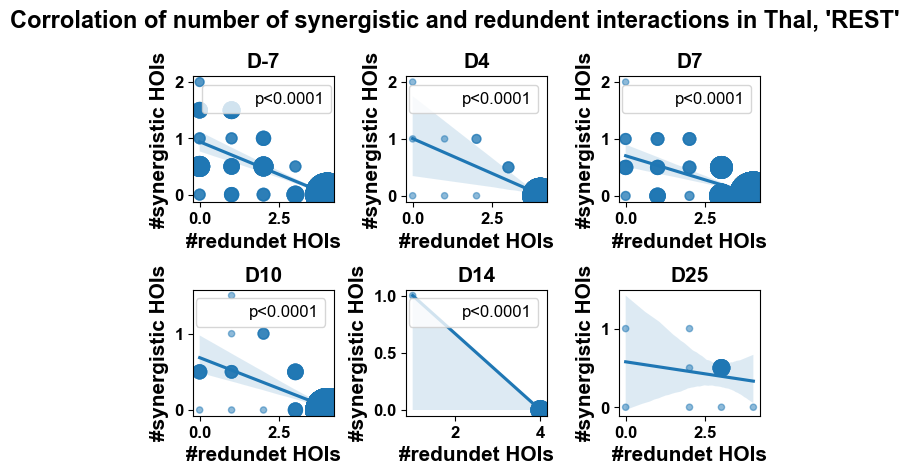

In [135]:
for group_num in [3,5]:
    df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
    df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
    
    for epoch in df_summary_ineractions_red.epoch.unique():
#         plt.close()
        df_epoch_red=df_summary_ineractions_red[df_summary_ineractions_red.epoch==epoch]
        df_epoch_syn=df_summary_ineractions_syn[df_summary_ineractions_syn.epoch==epoch]
        df_plot_red=df_epoch_red.drop(['epoch','rat','session','#session'],axis=1)
        df_plot_syn=df_epoch_syn.drop(['epoch','rat','session','#session'],axis=1)
        timepoints = sort_date(all_timepoints,df_plot_red.timepoint.unique().tolist())
        for region in df_plot_red.columns[1:]:
            plt.close()
            fig, axes = plt.subplots(2, 3)
            # for _, ax in np.ndenumerate(axes):
            #     ax.axis('off')
            fig.suptitle(f'Corrolation of number of synergistic and redundent interactions in {region}, {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
            for n,t1 in enumerate(timepoints):
                if df_plot_red[df_plot_red.timepoint==t1][region].shape[0]==0:
                    continue
                p=scipy.stats.pearsonr(df_plot_red[df_plot_red.timepoint==t1][region].values,df_plot_syn[df_plot_syn.timepoint==t1][region].values)[1]
                if p< 0.05:
#                     axes[n//3,n%3].text(0.5, 2, "Who's Hungy?",color='purple')
                    if p<0.0001:
                        label='p<0.0001'
                    elif p<0.001:
                        label='p<0.001'
                    elif p<0.01:
                        label='p<0.01'
                    else:
                        label='p<0.05'
                    empty_patch = mpatches.Patch(color='none', label=label) 
                    axes[n//3,n%3].legend(handles=[empty_patch],fontsize=12)
                x=df_plot_red[df_plot_red.timepoint==t1][region].values
                y=df_plot_syn[df_plot_syn.timepoint==t1][region].values
                
                data = pd.DataFrame({'x': x, 'y': y})
                # Calculate the frequency of each point
                counter = Counter(zip(data['x'], data['y']))
                data['size'] = data.apply(lambda row: counter[(row['x'], row['y'])], axis=1)
                
                # Scatter plot with point size based on frequency
                axes[n//3,n%3].scatter(data['x'], data['y'], s=data['size']*20, alpha=0.5)
                
                # Regression line
                sns.regplot(x='x', y='y', data=data, scatter=False,ax=axes[n//3,n%3])
                
                # sns.regplot(x=df_plot_red[df_plot_red.timepoint==t1][region].values,y=df_plot_syn[df_plot_syn.timepoint==t1][region].values,ax=axes[n//3,n%3])
                axes[n//3,n%3].set_title(t1, fontweight='bold', fontsize=15)
                axes[n//3,n%3].set_xlabel('#redundet HOIs',fontweight='bold', fontsize=15)
                axes[n//3,n%3].set_ylabel('#synergistic HOIs',fontweight='bold', fontsize=15)
                axes[n//3,n%3].set_xticklabels(axes[n//3,n%3].get_xticklabels(), fontweight='bold', fontsize=12)
                axes[n//3,n%3].set_yticklabels(axes[n//3,n%3].get_yticklabels(), fontweight='bold', fontsize=12)
            # Iterate over all axes and remove the empty ones
            for ax in axes.flat:
                if not ax.has_data():
                    fig.delaxes(ax)
            plt.tight_layout()
            plt.savefig(SAVE_PATH_FIG/f'group {group_num}'/'occurrence'/f'corr_red_syn_{region}_{epoch}.png',dpi=600,bbox_inches='tight')


/tmp/ipykernel_77132/3145152318.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_77132/3145152318.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_77132/3145152318.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_77132/3145152318.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

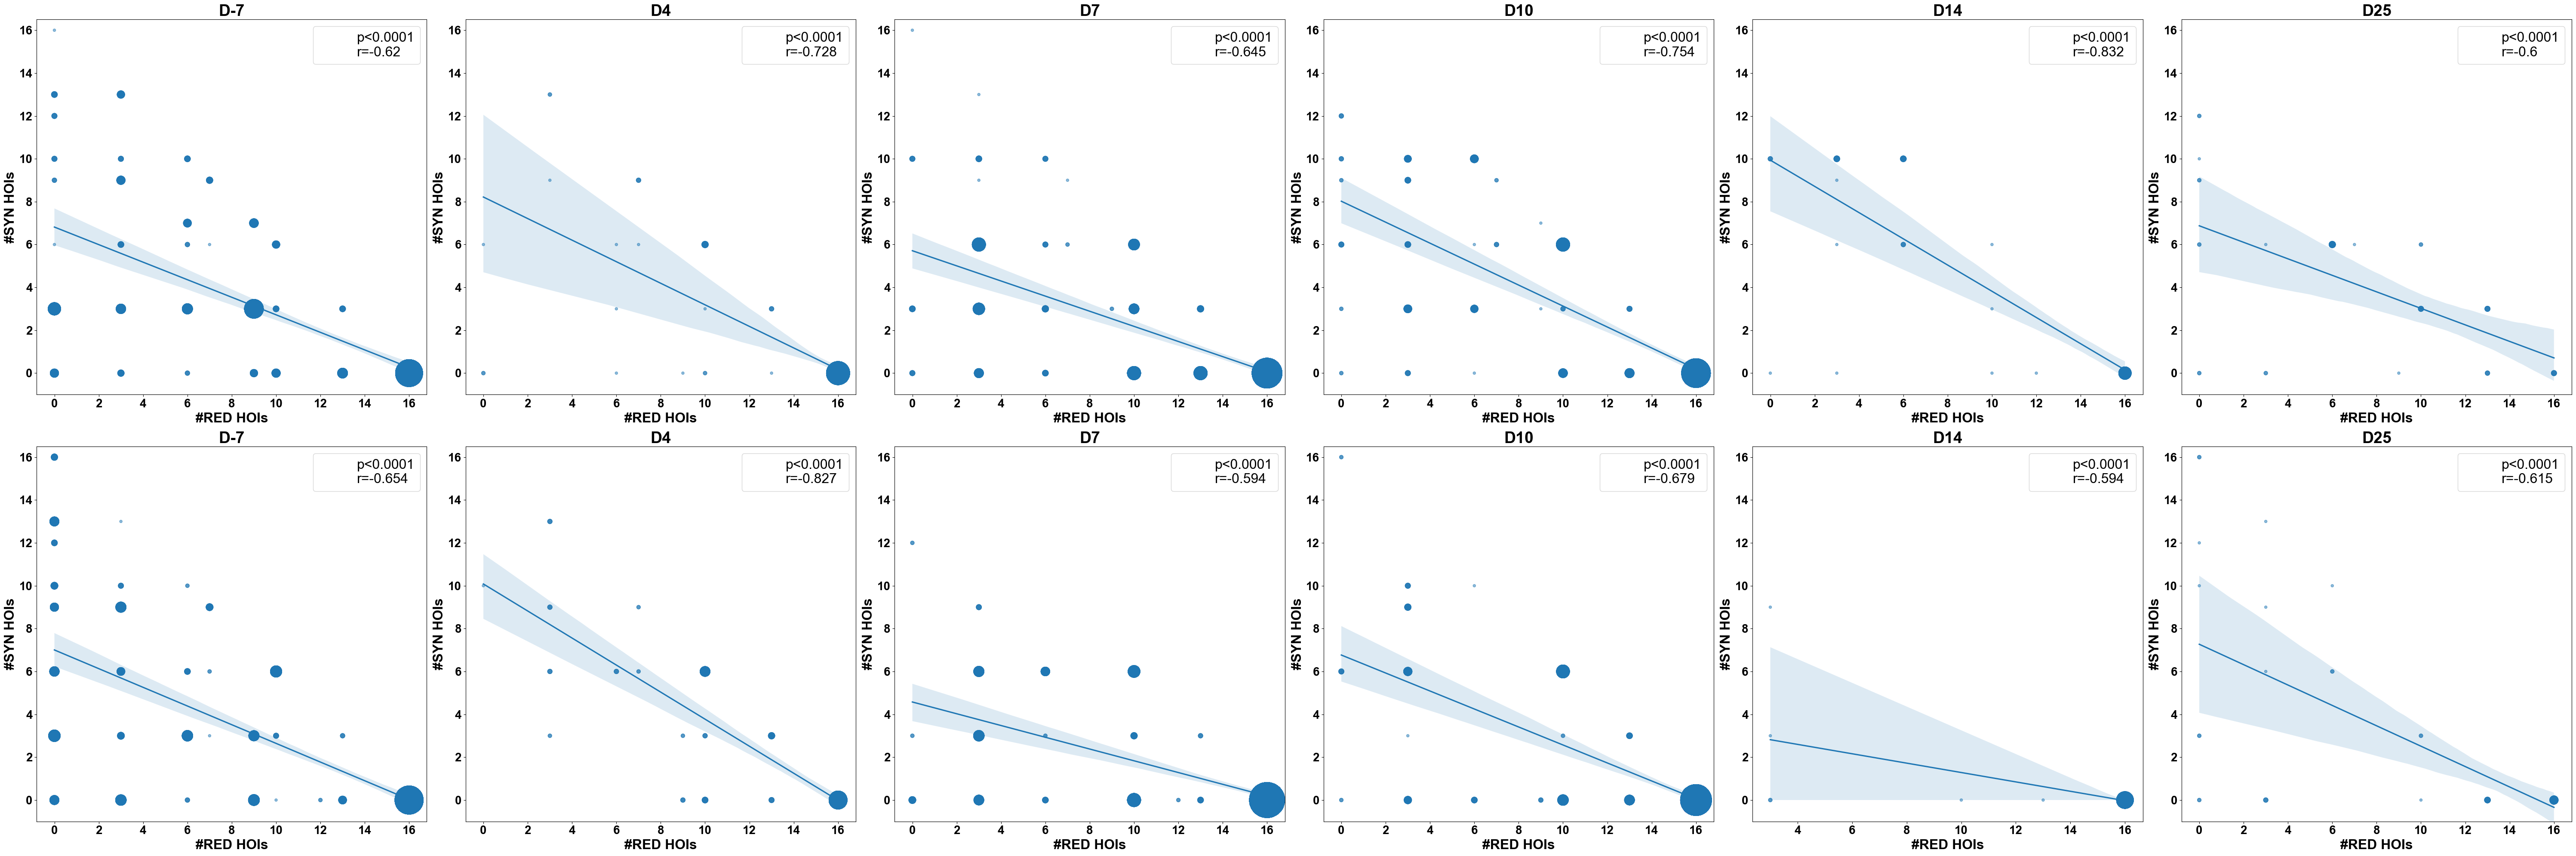

In [122]:

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(60,20))
axes_number_i=0
axes_number_j=0


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust these values as needed

for group_num in [5,3]:
    df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
    df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)

    df_summary_ineractions_red=df_summary_ineractions_red.drop(['epoch','rat','session','#session'],axis=1)
    df_summary_ineractions_syn=df_summary_ineractions_syn.drop(['epoch','rat','session','#session'],axis=1)

    df_summary_ineractions_red['Total']=df_summary_ineractions_red[df_summary_ineractions_red.columns[1:]].sum(axis=1)
    df_summary_ineractions_syn['Total']=df_summary_ineractions_syn[df_summary_ineractions_syn.columns[1:]].sum(axis=1)
    
    timepoints = sort_date(all_timepoints,df_summary_ineractions_syn.timepoint.unique().tolist())

    # for _, ax in np.ndenumerate(axes):
    #     ax.axis('off')
    # fig.suptitle(f'Corrolation of number of synergistic and redundent interactions in {region}, {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
    for n,t1 in enumerate(timepoints):
        if df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1]['Total'].shape[0]==0:
            continue
        p=scipy.stats.pearsonr(df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1]['Total'].values,df_summary_ineractions_syn[df_summary_ineractions_syn.timepoint==t1]['Total'].values)[1]
        r=scipy.stats.pearsonr(df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1]['Total'].values,df_summary_ineractions_syn[df_summary_ineractions_syn.timepoint==t1]['Total'].values)[0]
        r=round(r, 3)
        if p< 0.05:
#                     axes[n//3,n%3].text(0.5, 2, "Who's Hungy?",color='purple')
            if p<0.0001:
                label=f'p<0.0001\nr={r}'
            elif p<0.001:
                label=f'p<0.001\nr={r}'
            elif p<0.01:
                label=f'p<0.01\nr={r}'
            else:
                label=f'p<0.05\nr={r}'
            empty_patch = mpatches.Patch(color='none', label=label) 
            axes[axes_number_i,axes_number_j].legend(handles=[empty_patch],fontsize=23)
        x=df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1]['Total'].values
        y=df_summary_ineractions_syn[df_summary_ineractions_syn.timepoint==t1]['Total'].values
        
        data = pd.DataFrame({'x': x, 'y': y})
        # Calculate the frequency of each point
        counter = Counter(zip(data['x'], data['y']))
        data['size'] = data.apply(lambda row: counter[(row['x'], row['y'])], axis=1)
        
        # Scatter plot with point size based on frequency
        axes[axes_number_i,axes_number_j].scatter(data['x'], data['y'], s=data['size']*20, alpha=0.5)
        
        # Regression line
        sns.regplot(x='x', y='y', data=data, scatter=False,ax=axes[axes_number_i,axes_number_j])
        
        # sns.regplot(x=df_plot_red[df_plot_red.timepoint==t1][region].values,y=df_plot_syn[df_plot_syn.timepoint==t1][region].values,ax=axes[n//3,n%3])
        axes[axes_number_i,axes_number_j].set_title(t1, fontweight='bold', fontsize=27)
        axes[axes_number_i,axes_number_j].set_xlabel('#RED HOIs',fontweight='bold', fontsize=23)
        axes[axes_number_i,axes_number_j].set_ylabel('#SYN HOIs',fontweight='bold', fontsize=23)
        axes[axes_number_i,axes_number_j].set_ylim((-1,16.5))
        axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
        axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)

        axes_number_j+=1
    axes_number_i+=1
    axes_number_j=0
        # Iterate over all axes and remove the empty ones
for ax in axes.flat:
    if not ax.has_data():
        fig.delaxes(ax)
plt.tight_layout()
plt.savefig(SAVE_PATH_FIG/f'Figure7_corr_red_syn.svg',dpi=600,bbox_inches='tight')


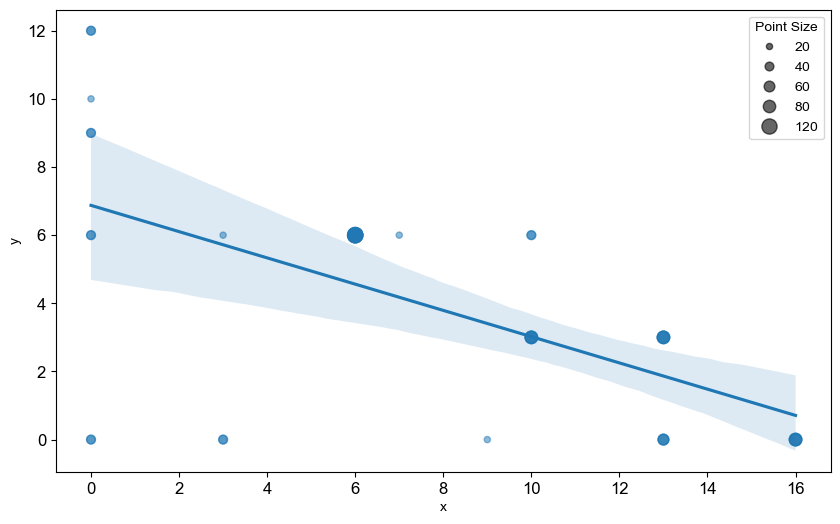

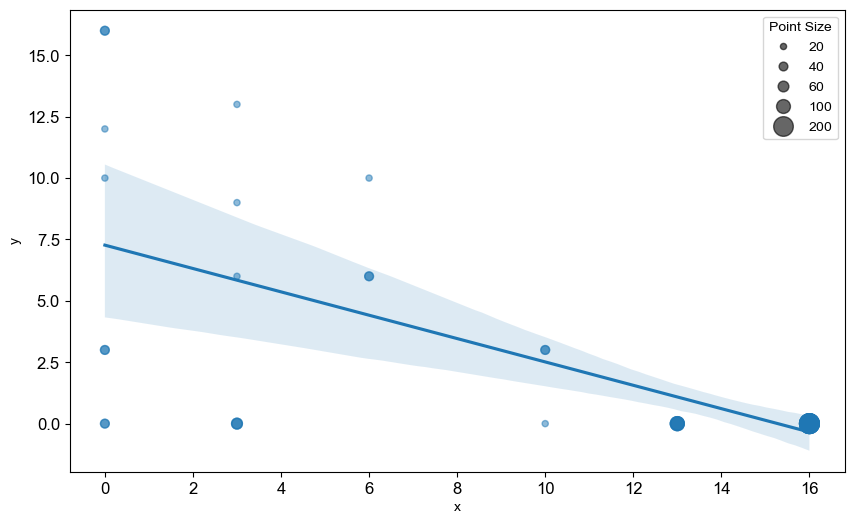

In [168]:
# legend
for group_num in [5,3]:
    df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
    df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)

    df_summary_ineractions_red=df_summary_ineractions_red.drop(['epoch','rat','session','#session'],axis=1)
    df_summary_ineractions_syn=df_summary_ineractions_syn.drop(['epoch','rat','session','#session'],axis=1)

    df_summary_ineractions_red['Total']=df_summary_ineractions_red[df_summary_ineractions_red.columns[1:]].sum(axis=1)
    df_summary_ineractions_syn['Total']=df_summary_ineractions_syn[df_summary_ineractions_syn.columns[1:]].sum(axis=1)

    x=df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1]['Total'].values
    y=df_summary_ineractions_syn[df_summary_ineractions_syn.timepoint==t1]['Total'].values
    
    data = pd.DataFrame({'x': x, 'y': y})
    # Calculate the frequency of each point
    # Create subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    counter = Counter(zip(data['x'], data['y']))
    data['size'] = data.apply(lambda row: counter[(row['x'], row['y'])], axis=1)

    # Scatter plot with point size based on frequency
    scatter = ax.scatter(data['x'], data['y'], s=data['size']*20, alpha=0.5)
    
    # Regression line
    sns.regplot(x='x', y='y', data=data, scatter=False)
    
    # Add legend for point sizes
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    size_legend = ax.legend(handles, labels, loc="best", title="Point Size")


    
    # Show plot
    plt.savefig(SAVE_PATH_FIG/f'Figure7_corr_red_syn{group}_legend.svg',dpi=600,bbox_inches='tight')

MS


/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

dHPC


/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

vHPC


/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

Thal


/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

MS


/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

SuM


/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

dHPC


/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

EC


/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
/tmp/ipykernel_147190/508904990.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=

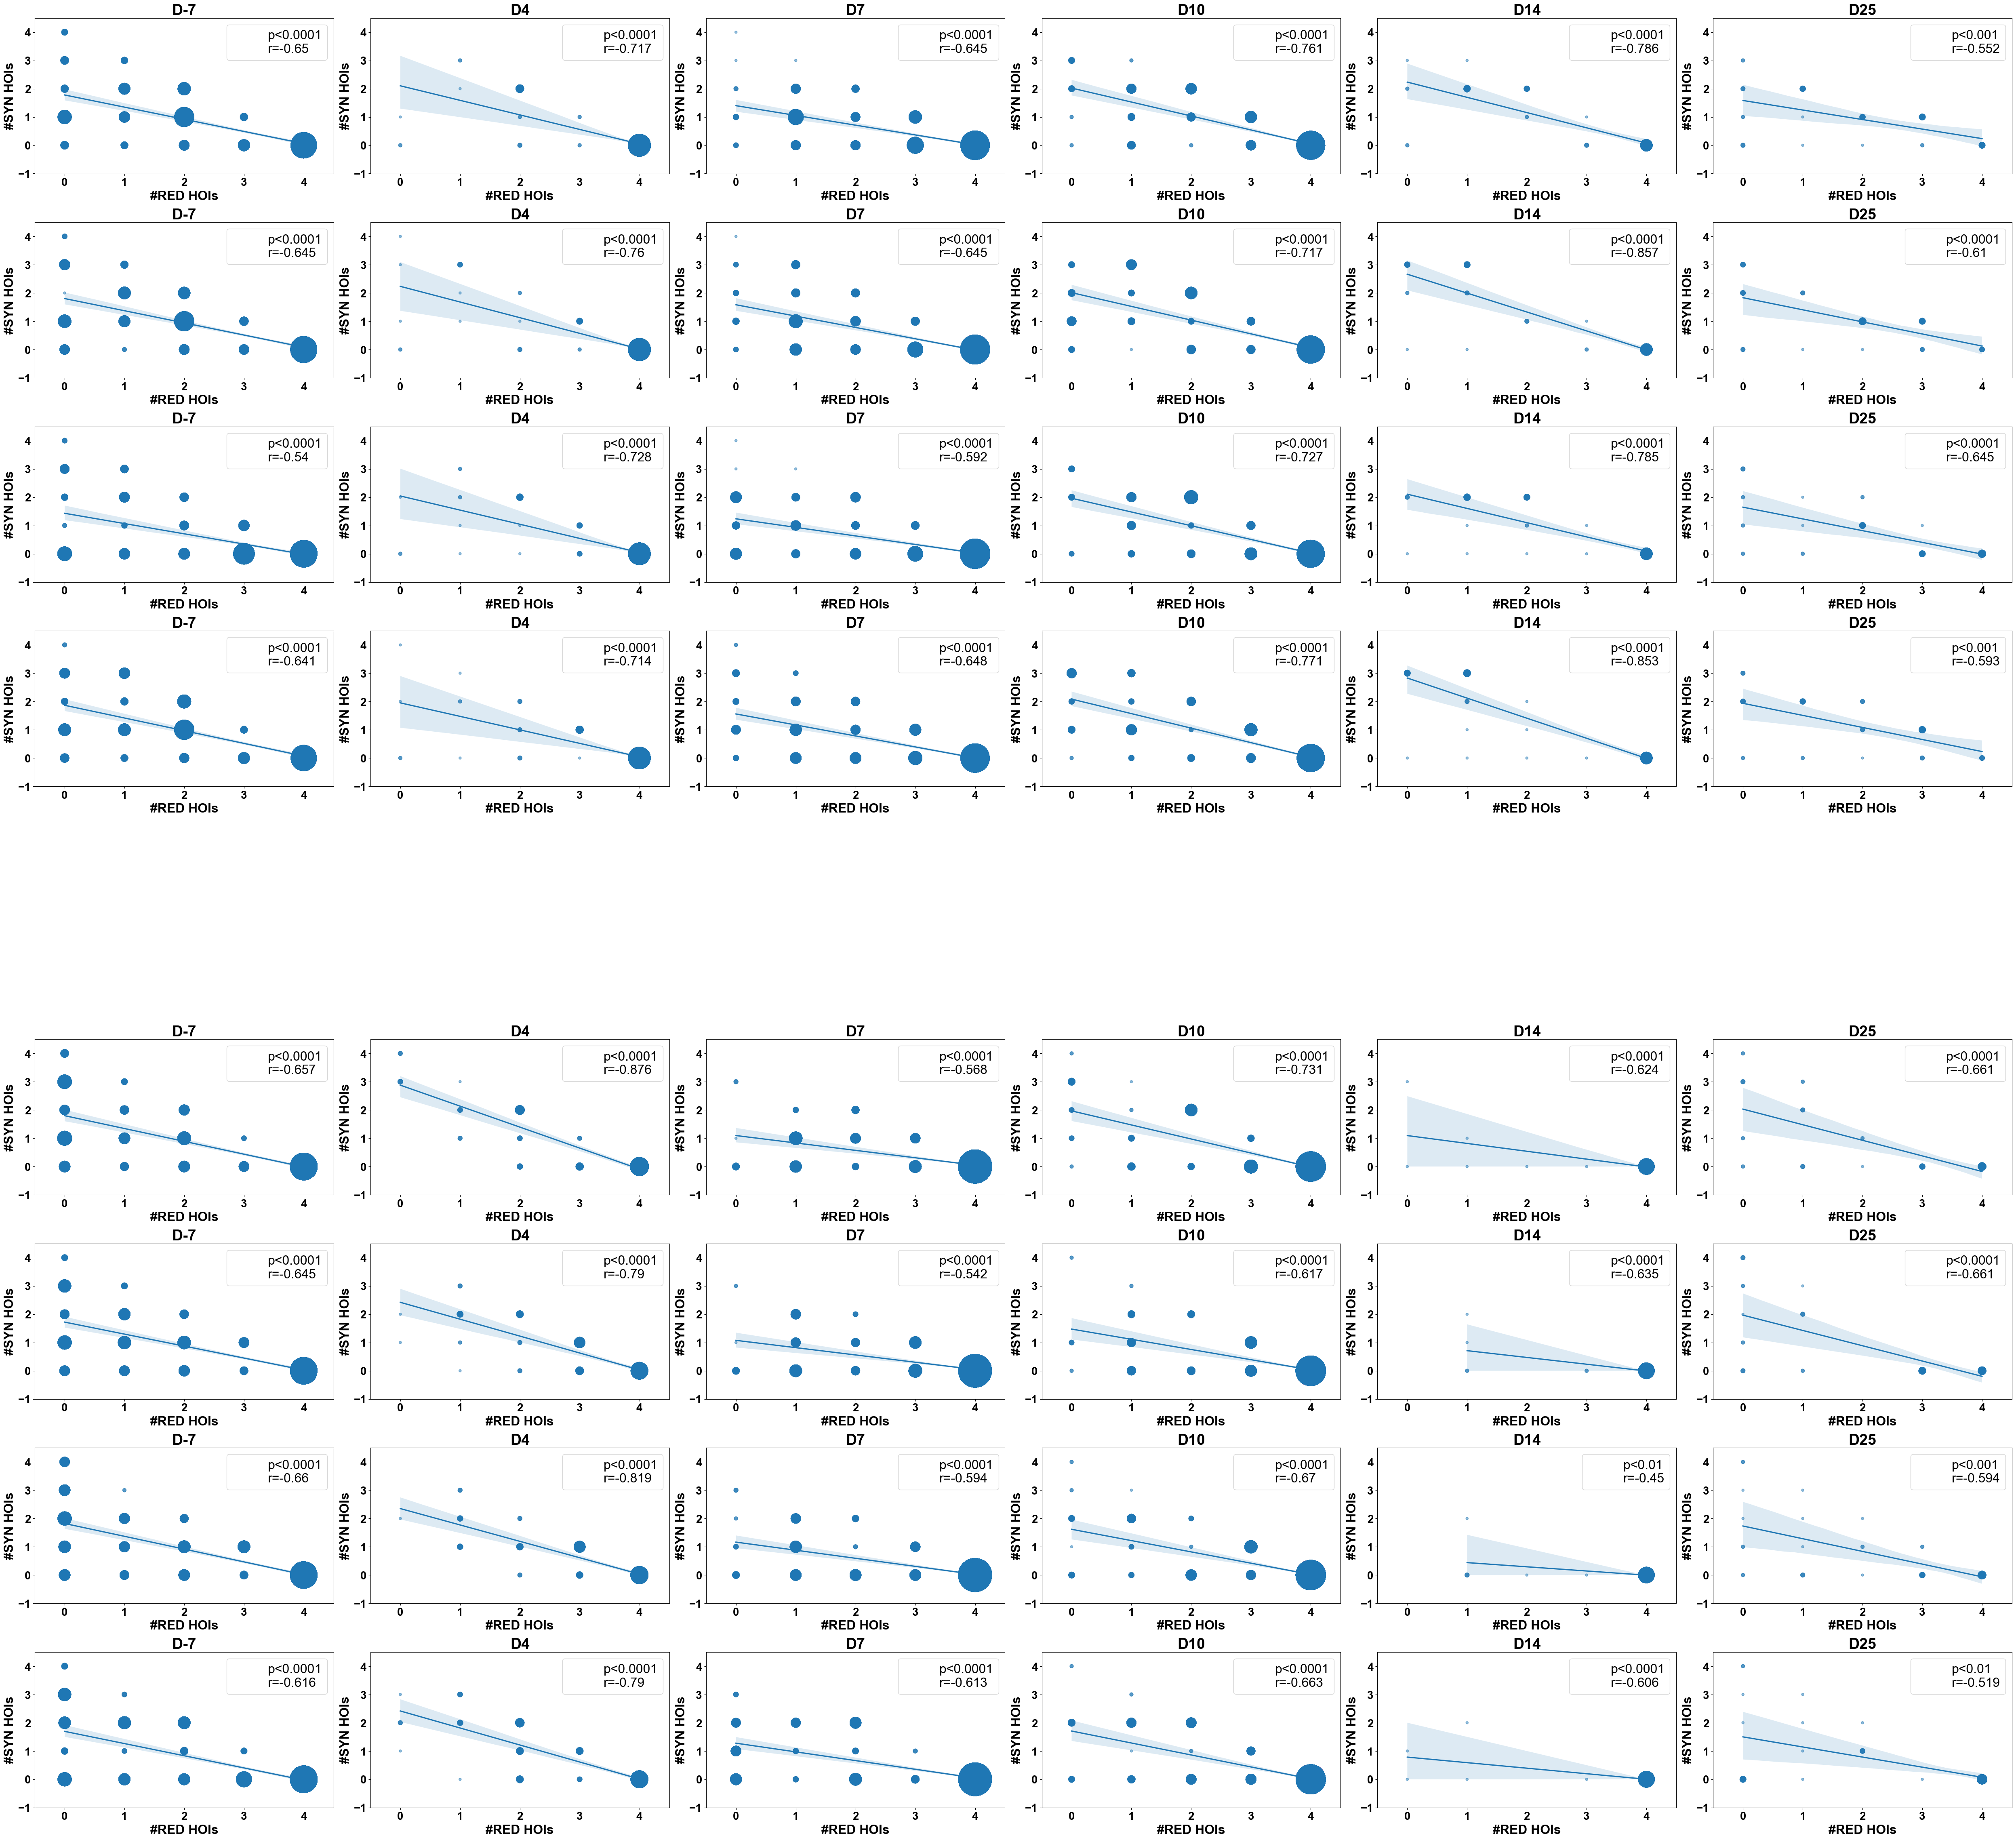

In [103]:

fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(50,50))
axes_number_i=0
axes_number_j=0


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust these values as needed

for group_num in [5,3]:
    df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
    df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)

    df_summary_ineractions_red=df_summary_ineractions_red.drop(['epoch','rat','session','#session'],axis=1)
    df_summary_ineractions_syn=df_summary_ineractions_syn.drop(['epoch','rat','session','#session'],axis=1)
    timepoints = sort_date(all_timepoints,df_summary_ineractions_syn.timepoint.unique().tolist())
    for region in df_summary_ineractions_red.columns[1:]:
        print(region)
        # for _, ax in np.ndenumerate(axes):
        #     ax.axis('off')
        # fig.suptitle(f'Corrolation of number of synergistic and redundent interactions in {region}, {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
        for n,t1 in enumerate(timepoints):
            if df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1][region].shape[0]==0:
                continue
            p=scipy.stats.pearsonr(df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1][region].values,df_summary_ineractions_syn[df_summary_ineractions_syn.timepoint==t1][region].values)[1]
            r=scipy.stats.pearsonr(df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1][region].values,df_summary_ineractions_syn[df_summary_ineractions_syn.timepoint==t1][region].values)[0]
            r=round(r, 3)
            if p< 0.05:
#                     axes[n//3,n%3].text(0.5, 2, "Who's Hungy?",color='purple')
                if p<0.0001:
                    label=f'p<0.0001\nr={r}'
                elif p<0.001:
                    label=f'p<0.001\nr={r}'
                elif p<0.01:
                    label=f'p<0.01\nr={r}'
                else:
                    label=f'p<0.05\nr={r}'
                empty_patch = mpatches.Patch(color='none', label=label) 
                axes[axes_number_i,axes_number_j].legend(handles=[empty_patch],fontsize=23)
            x=df_summary_ineractions_red[df_summary_ineractions_red.timepoint==t1][region].values
            y=df_summary_ineractions_syn[df_summary_ineractions_syn.timepoint==t1][region].values
            
            data = pd.DataFrame({'x': x, 'y': y})
            # Calculate the frequency of each point
            counter = Counter(zip(data['x'], data['y']))
            data['size'] = data.apply(lambda row: counter[(row['x'], row['y'])], axis=1)
            
            # Scatter plot with point size based on frequency
            axes[axes_number_i,axes_number_j].scatter(data['x'], data['y'], s=data['size']*20, alpha=0.5)
            
            # Regression line
            sns.regplot(x='x', y='y', data=data, scatter=False,ax=axes[axes_number_i,axes_number_j])
            
            # sns.regplot(x=df_plot_red[df_plot_red.timepoint==t1][region].values,y=df_plot_syn[df_plot_syn.timepoint==t1][region].values,ax=axes[n//3,n%3])
            axes[axes_number_i,axes_number_j].set_title(t1, fontweight='bold', fontsize=27)
            axes[axes_number_i,axes_number_j].set_xlabel('#RED HOIs',fontweight='bold', fontsize=23)
            axes[axes_number_i,axes_number_j].set_ylabel('#SYN HOIs',fontweight='bold', fontsize=23)
            axes[axes_number_i,axes_number_j].set_ylim((-1,4.5))
            axes[axes_number_i,axes_number_j].set_xlim((-0.5,4.5))
            axes[axes_number_i,axes_number_j].set_xticklabels(axes[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=20)
            axes[axes_number_i,axes_number_j].set_yticklabels(axes[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=20)
            axes_number_j+=1
        axes_number_i+=1
        axes_number_j=0
    axes_number_i+=1
    axes_number_j=0
        # Iterate over all axes and remove the empty ones
for ax in axes.flat:
    if not ax.has_data():
        fig.delaxes(ax)
plt.tight_layout()
plt.savefig(SAVE_PATH_FIG/f'Figure7_1_corr_red_syn.svg',dpi=600,bbox_inches='tight')


In [175]:
df_summary_ineractions_red

timepoint   MS  dHPC  vHPC  Thal
0           D7  4.0   4.0   4.0   4.0
1           D7  4.0   4.0   4.0   4.0
2           D7  4.0   4.0   4.0   4.0
3           D7  4.0   4.0   4.0   4.0
4           D7  4.0   4.0   4.0   4.0
...        ...  ...   ...   ...   ...
1091        D4  0.0   0.0   0.0   0.0
1092        D7  0.0   0.0   0.0   0.0
1093       D-7  0.0   0.0   0.0   0.0
1094       D-7  0.0   0.0   0.0   0.0
1095       D-7  0.0   0.0   0.0   0.0

[1096 rows x 5 columns]

0       16.0
1       16.0
2       16.0
3       16.0
4       16.0
        ... 
1085     7.0
1086     0.0
1087     0.0
1088     0.0
1089     0.0
Length: 1090, dtype: float64

In [109]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'stat_corr_red_syn.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
        df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
        
        for epoch in df_summary_ineractions_red.epoch.unique():
            df_stat=pd.DataFrame([])
            df_epoch_red=df_summary_ineractions_red[df_summary_ineractions_red.epoch==epoch]
            df_epoch_syn=df_summary_ineractions_syn[df_summary_ineractions_syn.epoch==epoch]
            df_plot_red=df_epoch_red.drop(['epoch','rat','session','#session'],axis=1)
            df_plot_syn=df_epoch_syn.drop(['epoch','rat','session','#session'],axis=1)
            timepoints = sort_date(all_timepoints,df_plot_red.timepoint.unique().tolist())
            for region in df_plot_red.columns[1:]:
                dic_data={}
                for n,t1 in enumerate(timepoints):
                    if df_plot_red[df_plot_red.timepoint==t1][region].shape[0]==0:
                        dic_data[t1]=1
                    else:
                        pval=scipy.stats.pearsonr(df_plot_red[df_plot_red.timepoint==t1][region].values,df_plot_syn[df_plot_syn.timepoint==t1][region].values)[1]
                        if pd.isna(pval):
                            print(group_num,epoch,region,t1)
                            dic_data[t1]='NA'
                            continue
                        dic_data[t1]=round(pval,3)
                df_region=pd.DataFrame(dic_data.values(),index=dic_data.keys(),columns=[region])
                df_stat=pd.concat([df_stat,df_region],axis=1)
                df_stat.to_excel(writer, sheet_name=f'group {group_num} - epoch {epoch}')
                # formating values in exel file
                # Get the xlsxwriter workbook and worksheet objects
                workbook = writer.book
                worksheet = writer.sheets[f'group {group_num} - epoch {epoch}']
                # Define a cell format with red fill for cells greater than 5
                red_fill = PatternFill(start_color='e66b63', end_color='e66b63', fill_type='solid')
                
                # Iterate through the DataFrame and apply formatting to cells greater than 5
                for row in range(2, df_stat.shape[0] + 73):
                    for col in range(2, df_stat.shape[1] + 3):
                        cell_value = worksheet.cell(row=row, column=col).value
                        if cell_value is not None and type(cell_value)!=str and cell_value < 0.05:
                            worksheet.cell(row=row, column=col).fill = red_fill


/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: Constant

3 SLEEP MS D4
3 SLEEP SuM D4
3 SLEEP dHPC D4
3 SLEEP EC D4
3 VC MS D14
3 VC SuM D14
3 VC dHPC D14
3 VC EC D14
5 SLEEP MS D4
5 SLEEP MS D7
5 SLEEP dHPC D7
5 SLEEP vHPC D7
5 SLEEP vHPC D25
5 SLEEP Thal D7
5 SLEEP Thal D25


/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [96]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'stat_corr_red_syn_all_behaviors.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
        df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
        
        df_stat=pd.DataFrame([])
        df_epoch_red=df_summary_ineractions_red
        df_epoch_syn=df_summary_ineractions_syn
        df_plot_red=df_epoch_red.drop(['epoch','rat','session','#session'],axis=1)
        df_plot_syn=df_epoch_syn.drop(['epoch','rat','session','#session'],axis=1)
        timepoints = sort_date(all_timepoints,df_plot_red.timepoint.unique().tolist())
        for region in df_plot_red.columns[1:]:
            dic_data={}
            for n,t1 in enumerate(timepoints):
                if df_plot_red[df_plot_red.timepoint==t1][region].shape[0]==0:
                    dic_data[t1]=1
                else:
                    pval=scipy.stats.pearsonr(df_plot_red[df_plot_red.timepoint==t1][region].values,df_plot_syn[df_plot_syn.timepoint==t1][region].values)[1]
                    if pd.isna(pval):
                        dic_data[t1]='NA'
                        continue
                    dic_data[t1]=round(pval,3)
            df_region=pd.DataFrame(dic_data.values(),index=dic_data.keys(),columns=[region])
            df_stat=pd.concat([df_stat,df_region],axis=1)
            df_stat.to_excel(writer, sheet_name=f'group {group_num}')
            # formating values in exel file
            # Get the xlsxwriter workbook and worksheet objects
            workbook = writer.book
            worksheet = writer.sheets[f'group {group_num}']
            # Define a cell format with red fill for cells greater than 5
            red_fill = PatternFill(start_color='e66b63', end_color='e66b63', fill_type='solid')
            
            # Iterate through the DataFrame and apply formatting to cells greater than 5
            for row in range(2, df_stat.shape[0] + 73):
                for col in range(2, df_stat.shape[1] + 3):
                    cell_value = worksheet.cell(row=row, column=col).value
                    if cell_value is not None and type(cell_value)!=str and cell_value < 0.05:
                        worksheet.cell(row=row, column=col).fill = red_fill


In [97]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'stat_corr_red_syn_all_behaviors_all_regions.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
        df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
        
        df_stat=pd.DataFrame([])
        df_epoch_red=df_summary_ineractions_red
        df_epoch_syn=df_summary_ineractions_syn
        df_plot_red=df_epoch_red.drop(['epoch','rat','session','#session'],axis=1)
        df_plot_syn=df_epoch_syn.drop(['epoch','rat','session','#session'],axis=1)

        
        df_plot_red['Total']=df_plot_red[df_plot_red.columns[1:]].sum(axis=1)
        df_plot_syn['Total']=df_plot_syn[df_plot_syn.columns[1:]].sum(axis=1)
        
        timepoints = sort_date(all_timepoints,df_plot_red.timepoint.unique().tolist())
        dic_data={}
        for n,t1 in enumerate(timepoints):
            if df_plot_red[df_plot_red.timepoint==t1]['Total'].shape[0]==0:
                dic_data[t1]=1
            else:
                pval=scipy.stats.pearsonr(df_plot_red[df_plot_red.timepoint==t1]['Total'].values,df_plot_syn[df_plot_syn.timepoint==t1]['Total'].values)[1]
                if pd.isna(pval):
                    dic_data[t1]='NA'
                    continue
                dic_data[t1]=round(pval,3)
        df_region=pd.DataFrame(dic_data.values(),index=dic_data.keys(),columns=['All regions'])
        df_stat=pd.concat([df_stat,df_region],axis=1)
        df_stat.to_excel(writer, sheet_name=f'group {group_num}')
        # formating values in exel file
        # Get the xlsxwriter workbook and worksheet objects
        workbook = writer.book
        worksheet = writer.sheets[f'group {group_num}']
        # Define a cell format with red fill for cells greater than 5
        red_fill = PatternFill(start_color='e66b63', end_color='e66b63', fill_type='solid')
        
        # Iterate through the DataFrame and apply formatting to cells greater than 5
        for row in range(2, df_stat.shape[0] + 73):
            for col in range(2, df_stat.shape[1] + 3):
                cell_value = worksheet.cell(row=row, column=col).value
                if cell_value is not None and type(cell_value)!=str and cell_value < 0.05:
                    worksheet.cell(row=row, column=col).fill = red_fill


In [99]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'corr_red_syn.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
        df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
        
        for epoch in df_summary_ineractions_red.epoch.unique():
            df_stat=pd.DataFrame([])
            df_epoch_red=df_summary_ineractions_red[df_summary_ineractions_red.epoch==epoch]
            df_epoch_syn=df_summary_ineractions_syn[df_summary_ineractions_syn.epoch==epoch]
            df_plot_red=df_epoch_red.drop(['epoch','rat','session','#session'],axis=1)
            df_plot_syn=df_epoch_syn.drop(['epoch','rat','session','#session'],axis=1)
            timepoints = sort_date(all_timepoints,df_plot_red.timepoint.unique().tolist())
            for region in df_plot_red.columns[1:]:
                dic_data={}
                for n,t1 in enumerate(timepoints):
                    if df_plot_red[df_plot_red.timepoint==t1][region].shape[0]==0:
                        dic_data[t1]=1
                    else:
                        pval=scipy.stats.pearsonr(df_plot_red[df_plot_red.timepoint==t1][region].values,df_plot_syn[df_plot_syn.timepoint==t1][region].values)[0]
                        if pd.isna(pval):
                            dic_data[t1]='NA'
                            continue
                        dic_data[t1]=round(pval,3)
                df_region=pd.DataFrame(dic_data.values(),index=dic_data.keys(),columns=[region])
                df_stat=pd.concat([df_stat,df_region],axis=1)
                df_stat.to_excel(writer, sheet_name=f'group {group_num} - epoch {epoch}')
                # formating values in exel file
                # Get the xlsxwriter workbook and worksheet objects
                workbook = writer.book
                worksheet = writer.sheets[f'group {group_num} - epoch {epoch}']
                # Define a cell format with red fill for cells greater than 5
                red_fill = PatternFill(start_color='e66b63', end_color='e66b63', fill_type='solid')
                
                # # Iterate through the DataFrame and apply formatting to cells greater than 5
                # for row in range(2, df_stat.shape[0] + 73):
                #     for col in range(2, df_stat.shape[1] + 3):
                #         cell_value = worksheet.cell(row=row, column=col).value
                #         if cell_value is not None and type(cell_value)!=str and cell_value < 0.05:
                #             worksheet.cell(row=row, column=col).fill = red_fill


/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/morteza/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: Constant

In [100]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'corr_red_syn_all_behaviors.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
        df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
        
        df_stat=pd.DataFrame([])
        df_epoch_red=df_summary_ineractions_red
        df_epoch_syn=df_summary_ineractions_syn
        df_plot_red=df_epoch_red.drop(['epoch','rat','session','#session'],axis=1)
        df_plot_syn=df_epoch_syn.drop(['epoch','rat','session','#session'],axis=1)
        timepoints = sort_date(all_timepoints,df_plot_red.timepoint.unique().tolist())
        for region in df_plot_red.columns[1:]:
            dic_data={}
            for n,t1 in enumerate(timepoints):
                if df_plot_red[df_plot_red.timepoint==t1][region].shape[0]==0:
                    dic_data[t1]=1
                else:
                    pval=scipy.stats.pearsonr(df_plot_red[df_plot_red.timepoint==t1][region].values,df_plot_syn[df_plot_syn.timepoint==t1][region].values)[0]
                    if pd.isna(pval):
                        dic_data[t1]='NA'
                        continue
                    dic_data[t1]=round(pval,3)
            df_region=pd.DataFrame(dic_data.values(),index=dic_data.keys(),columns=[region])
            df_stat=pd.concat([df_stat,df_region],axis=1)
            df_stat.to_excel(writer, sheet_name=f'group {group_num}')
            # formating values in exel file
            # Get the xlsxwriter workbook and worksheet objects
            workbook = writer.book
            worksheet = writer.sheets[f'group {group_num}']
            # Define a cell format with red fill for cells greater than 5
            red_fill = PatternFill(start_color='e66b63', end_color='e66b63', fill_type='solid')
            
            # Iterate through the DataFrame and apply formatting to cells greater than 5
            for row in range(2, df_stat.shape[0] + 73):
                for col in range(2, df_stat.shape[1] + 3):
                    cell_value = worksheet.cell(row=row, column=col).value
                    if cell_value is not None and type(cell_value)!=str and cell_value < 0.05:
                        worksheet.cell(row=row, column=col).fill = red_fill


In [101]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'corr_red_syn_all_behaviors_all_regions.xlsx',engine='openpyxl') as writer:
    for group_num in [3,5]:
        df_summary_ineractions_red=analysis_num_interactions_group(df,'red',group_num,True).fillna(0)
        df_summary_ineractions_syn=analysis_num_interactions_group(df,'syn',group_num,True).fillna(0)
        
        df_stat=pd.DataFrame([])
        df_epoch_red=df_summary_ineractions_red
        df_epoch_syn=df_summary_ineractions_syn
        df_plot_red=df_epoch_red.drop(['epoch','rat','session','#session'],axis=1)
        df_plot_syn=df_epoch_syn.drop(['epoch','rat','session','#session'],axis=1)

        
        df_plot_red['Total']=df_plot_red[df_plot_red.columns[1:]].sum(axis=1)
        df_plot_syn['Total']=df_plot_syn[df_plot_syn.columns[1:]].sum(axis=1)
        
        timepoints = sort_date(all_timepoints,df_plot_red.timepoint.unique().tolist())
        dic_data={}
        for n,t1 in enumerate(timepoints):
            if df_plot_red[df_plot_red.timepoint==t1]['Total'].shape[0]==0:
                dic_data[t1]=1
            else:
                pval=scipy.stats.pearsonr(df_plot_red[df_plot_red.timepoint==t1]['Total'].values,df_plot_syn[df_plot_syn.timepoint==t1]['Total'].values)[0]
                if pd.isna(pval):
                    dic_data[t1]='NA'
                    continue
                dic_data[t1]=round(pval,3)
        df_region=pd.DataFrame(dic_data.values(),index=dic_data.keys(),columns=['All regions'])
        df_stat=pd.concat([df_stat,df_region],axis=1)
        df_stat.to_excel(writer, sheet_name=f'group {group_num}')
        # formating values in exel file
        # Get the xlsxwriter workbook and worksheet objects
        workbook = writer.book
        worksheet = writer.sheets[f'group {group_num}']
        # Define a cell format with red fill for cells greater than 5
        red_fill = PatternFill(start_color='e66b63', end_color='e66b63', fill_type='solid')
        
        # Iterate through the DataFrame and apply formatting to cells greater than 5
        for row in range(2, df_stat.shape[0] + 73):
            for col in range(2, df_stat.shape[1] + 3):
                cell_value = worksheet.cell(row=row, column=col).value
                if cell_value is not None and type(cell_value)!=str and cell_value < 0.05:
                    worksheet.cell(row=row, column=col).fill = red_fill
